In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))

/tmp/ipykernel_266731/1256517549.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [2]:
import numpy as np
from tqdm import tqdm as tqdm
#from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import os
import optparse
import os.path as osp
import math
import torch_geometric
import torch
import sys
from torch_geometric.data import Data
import glob
from datetime import datetime
import random


from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import torch.jit as jit

In [3]:
# tt=torch.load("/grid_mnt/data__data.polcms/cms/sghosh/NEWPID_TICLDUMPER_DATA/ntup_pho_18082024/data_499.pt")
# np.unique(tt[0].clus2d_feat[:,5])

### set seed for reproducibility

In [3]:
seed = 42

In [4]:
torch.manual_seed(seed)
#torch.use_deterministic_algorithms(True) # not good: this makes the training break
random.seed(seed)

### create output directory to save checkpoints

In [5]:
#today = date.today()
now = datetime.now().strftime("%Y%m%d_%H%M%S")
out_dir = str(now)+'_checkpoints'
os.makedirs(out_dir, exist_ok=True) #check if output dir exist
print(out_dir)

20250314_115826_checkpoints


### tensors features

In [7]:
#########################################
# clus2d_feats = np.stack((ak.to_numpy(sel_clusters[ts].position_x),
#                          ak.to_numpy(sel_clusters[ts].position_y),
#                          ak.to_numpy(sel_clusters[ts].position_z),
#                          ak.to_numpy(sel_clusters[ts].energy),
#                          ak.to_numpy(sel_clusters[ts].cluster_time),
#                          ak.to_numpy(sel_clusters[ts].cluster_layer_id))).T

#                     #print(clus2d_feats.shape)
# clus3d_feats = np.stack((sel_tseta[ts][0],
#                          sel_tsphi[ts][0],
#                          sel_tsen[ts][0],
#                          sel_tst[ts][0],
#                          min(ak.to_numpy(sel_clusters[ts].cluster_layer_id)),
#                          max(ak.to_numpy(sel_clusters[ts].cluster_layer_id)))).T
# gun_feats = np.stack((sel_cpeta[ts][0],
#                       sel_cpphi[ts][0],
#                       sel_cpen[ts][0],
#                       sel_cpent[ts][0], 
#                       sel_ratem[ts][0]    trk_em/ sim_em
#                       sel_rattot[ts][0]   trk/sim
#                        )).T
########################################

### Load input data

In [6]:
from torch.utils.data import Dataset

class ClassificationDataset(Dataset):
    def __init__(self, datapath, numLC, feats, signal, ispi, abz):
        self.datapath_ = datapath
        self.numLC_ = numLC
        self.signal_ = signal
        self.ispi_ = ispi
        self.abz_ = abz
        self.feats_ = feats
        self.process = self.load_datafiles(self.datapath_)
        self.data = torch.stack(self.process[0],dim=0)
        self.labels = torch.stack(self.process[1],dim=0)
        self.masks = torch.stack(self.process[2],dim=0)
        self.info3d = torch.stack(self.process[3],dim=0)
        self.infogun = torch.stack(self.process[4],dim=0)


    def load_datafiles(self, filepath) :
        "filepath of the form /grid_mnt/data__data.polcms/cms/sghosh/NEWPID_DATA/ntup_pho_frac0p8/ "
        print("processing files from:",filepath)
        filelist = [filen for filen in glob.glob(filepath+'data*.pt')]
        output_tensor_list = []
        label = []
        mask_tensor_list = []
        info3d_tensor_list = []
        infogun_tensor_list = []
        
        ctot = 0
        cll = 0
        
        
        for i in tqdm(filelist):
            if (len(label)>50000):
                    break
            
            for filei in torch.load(i) :
                ctot += 1
                #print(filei.gun_feat)
                passpi = False
                passpu = False
                nlay = len(np.unique(filei.clus2d_feat[:,5]))
                ratrec_true = (filei.clus3d_feat[2]/filei.gun_feat[:,3]).item()

                if (self.signal_):
#                    if (nlay < 13) :
                    if (ratrec_true < 0.7):
                        cll += 1                        
                        continue
                else:
                    feat2da = filei.clus2d_feat
                    fracen26 = torch.sum(feat2da[feat2da[:,5] <=26][:,3])/torch.sum(feat2da[:,3])
                    if self.ispi_:
                        #if (nlay > 10)and(fracen26 > 0.7)and(min(feat2da[:,5]) < 15) :
                        passpi = True
                        if not(passpi):
                            cll += 1
                            continue
                        #print("self.ispi_ & nlay < 10 & fracen26< 0.7", self.ispi_, nlay , fracen26)
                    else:
                        #if ((nlay < 10)and(fracen26 < 0.7))or ((nlay > 10)and(fracen26 < 0.7)) or ((nlay < 10)and(fracen26 > 0.7)):
                        #if not((nlay > 10)and(fracen26 > 0.7)and(min(feat2da[:,5]) < 15)):
                        if not((nlay > 10)and(fracen26 > 0.6)and(min(feat2da[:,5]) < 15)and((np.average(filei.clus2d_feat[:,2], weights=filei.clus2d_feat[:,3])) < 360)):
                            passpu = True
                        else:
                            pass
                            #print("self.ispi_ & nlay < 10 & fracen26< 0.7", self.ispi_, nlay, fracen26)
                        if not(passpu):
                            cll += 1
                            continue
                        #print("self.ispi_ & nlay < 10 & fracen26< 0.7", self.ispi_, nlay, fracen26)
               
                
                
                
                
                
                optensor = self.transform_data(filei.clus2d_feat, self.numLC_)
                output_tensor_list.append(optensor[0])
                mask_tensor_list.append(optensor[1])
                info3d_tensor_list.append(filei.clus3d_feat[[0,1,2,4,5]])
                infogun_tensor_list.append(filei.gun_feat)
                if self.signal_:
                    label.append(torch.ones(1,dtype=torch.double))
                else:
                    label.append(torch.zeros(1,dtype=torch.double))
         
        
        print ("nskipped | ntotal:",cll," | ",ctot)
        return output_tensor_list, label, mask_tensor_list, info3d_tensor_list, infogun_tensor_list
                
    def transform_data(self, tensor, nLC) :            

        #feats = [0,1,2,5]
        target = torch.zeros(nLC, len(self.feats_))
        mask0 = torch.ones(nLC)
        source = tensor[:nLC,self.feats_]
        mask1 = torch.zeros(source.shape[0])
        if self.abz_:
            source[:,2] = np.abs(source[:,2])
        target[:source.shape[0], :] = source
        #source = source.T
        mask0[:source.shape[0]] = mask1
        mask0 
        #print(mask0)
        return target, mask0 > 0
    
        
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx): 
        return self.data[idx], self.labels[idx], self.masks[idx], self.info3d[idx], self.infogun[idx]

#### Photon dataset (energy spread: 10-1000 GeV)

In [7]:
pho_path = "/grid_mnt/data__data.polcms/cms/sghosh/NEWPID_TICLDUMPER_DATA/S2Rmin_pho_30072024/"
pho_dataset = ClassificationDataset(pho_path, 150, [0,1,5,3], True, False, True)

processing files from: /grid_mnt/data__data.polcms/cms/sghosh/NEWPID_TICLDUMPER_DATA/S2Rmin_pho_30072024/


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:15<00:00, 31.55it/s]


nskipped | ntotal: 119  |  50000


#### Pion dataset: pion sample from where high energy early showering pions are removed

In [8]:
hizpu_path = "/grid_mnt/data__data.polcms/cms/sghosh/NEWPID_TICLDUMPER_DATA/S2R0p9_pi_30072024/"
hizpu_dataset = ClassificationDataset(hizpu_path, 150, [0,1,5,3], False, False, True)

processing files from: /grid_mnt/data__data.polcms/cms/sghosh/NEWPID_TICLDUMPER_DATA/S2R0p9_pi_30072024/


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 484/500 [00:31<00:01, 15.23it/s]


nskipped | ntotal: 20625  |  70628


#### Pion dataset: low energy clusters within CEE + others (no CEE restrictions)

##### low energy pions removing the pi0

In [9]:
lowzpu_path = "/grid_mnt/data__data.polcms/cms/sghosh/NEWPID_TICLDUMPER_DATA/S2Rno_PUenrich_05082024/"
lowzpu_dataset = ClassificationDataset(lowzpu_path, 150, [0,1,5,3], False, False, True)

processing files from: /grid_mnt/data__data.polcms/cms/sghosh/NEWPID_TICLDUMPER_DATA/S2Rno_PUenrich_05082024/


 50%|████████████████████████████████████████████████████████████████████████████████████████▌                                                                                        | 3/6 [02:28<02:28, 49.53s/it]


nskipped | ntotal: 228603  |  287365


##### low energy pions with all inside: no skipping of pi0

In [10]:
unbiased_dataset = ClassificationDataset(lowzpu_path, 150, [0,1,5,3], False, True, True)

processing files from: /grid_mnt/data__data.polcms/cms/sghosh/NEWPID_TICLDUMPER_DATA/S2Rno_PUenrich_05082024/


 17%|█████████████████████████████▌                                                                                                                                                   | 1/6 [00:43<03:37, 43.50s/it]


nskipped | ntotal: 0  |  95549


In [11]:
print("lenpho:",len(pho_dataset), " lenhizpu:",len(hizpu_dataset), " lenlozpu:",len(lowzpu_dataset), " lenunbias:",len(unbiased_dataset))

lenpho: 49881  lenhizpu: 50003  lenlozpu: 58762  lenunbias: 95549


### Define training and testing datasets

In [12]:
nphos = len(pho_dataset)
idxstotsamp = np.arange(nphos)

#### ATTENTION!
## for training up to number 7, then we changed it for training number 8
lowzpu_dataset = unbiased_dataset # comment for training number 8 inference


### DEFINE Background COMPOSITION
hizpusel = torch.utils.data.Subset(hizpu_dataset, idxstotsamp[:int(0.3*nphos)])
lowzpusel = torch.utils.data.Subset(lowzpu_dataset, idxstotsamp[:int(0.7*nphos)])
#npusel = len(pho_dataset) - len(pisel)
#pusel = torch.utils.data.Subset(pu_dataset, idxstotsamp[:int(npusel)])

combdataset = torch.utils.data.ConcatDataset([pho_dataset, hizpusel, lowzpusel])

nsamp = len(combdataset)

idxs = np.arange(nsamp)
np.random.shuffle(idxs)
tridx = idxs[:int(0.8*nsamp)]
tsidx = idxs[int(0.8*nsamp):nsamp]
trdata = torch.utils.data.Subset(combdataset, tridx)
tsdata = torch.utils.data.Subset(combdataset, tsidx)

ntrainbatch = 600
## load train and test dataset
trainloader = torch.utils.data.DataLoader(trdata, batch_size=ntrainbatch ,shuffle=True)#, num_workers=2)
testloader = torch.utils.data.DataLoader(tsdata, batch_size=ntrainbatch,shuffle=True)#, num_workers=2)
## load all data, for plots later
totalloader = torch.utils.data.DataLoader(combdataset, batch_size=ntrainbatch,shuffle=True)#, num_workers=2)
## load unbiased dataset, for plots and inference later
unbiasloader = torch.utils.data.DataLoader(unbiased_dataset, batch_size=ntrainbatch,shuffle=True)


print("total samples") 
print("npho    ",len(pho_dataset))
print("nhizpu  ",len(hizpusel))
print("nlozpu  ",len(lowzpusel))
print("nTOT    ",nsamp)
print("nunbias ",len(unbiased_dataset))
print("N_train, N_test:",len(trdata),",",len(tsdata))

total samples
npho     49881
nhizpu   14964
nlozpu   34916
nTOT     99761
nunbias  95549
N_train, N_test: 79808 , 19953


### Define model

In [13]:
## Define model
## refer https://github.com/ludovicobuizza/HAR-Transformer/blob/main/src/transformer/transformer.py for batchnorm
import torch.nn as nn
import torch.nn.functional as F

class MHA_model(jit.ScriptModule):
    

    def __init__(
        self,
        input_dim = 6,
        dim_emb = 64,
        n_heads = 16,
        num_enclayers = 6,
        dim_feedforward = 64,
        n_seq = 150,
        output_dim = 2,
        norm=torch.tensor([1./100., 1./100., 1./100., 1./100.]),
    ):
        
        super(MHA_model, self).__init__()
        self.datanorm = nn.Parameter(norm, requires_grad=False) 
        self.emb_inp = nn.Sequential(
            nn.Linear(input_dim, dim_emb),
            nn.Dropout(0.1),
            nn.ELU(),
            #nn.LeakyReLU(negative_slope=0.4),
            nn.Linear(dim_emb, dim_emb),
            nn.Dropout(0.1),
#            nn.LeakyReLU(negative_slope=0.4),
#            nn.Linear(hidden_dim*2, hidden_dim),
            nn.ELU(),
            #nn.LeakyReLU(negative_slope=0.4),
        )
        
#        self.emb_inp =  nn.Linear(input_dim, dim_emb)      
        encoder_layer = nn.TransformerEncoderLayer(
                dim_emb,
                n_heads,
                dim_feedforward,
                dropout = 0.2,
                batch_first= True,
                activation=nn.ELU(),  #nn.LeakyReLU(negative_slope=0.4),
            )
        
        
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_enclayers)
        
        self.output_layer = nn.Sequential(nn.Linear(n_seq*dim_emb + 5, dim_emb//2),
                                    
                                    #nn.LeakyReLU(negative_slope=0.4),
                                    nn.Dropout(0.3),
                                    nn.ELU(),
                                    #nn.Softplus(),
                                    nn.Linear(dim_emb//2, dim_emb//2),#added
                                    nn.Dropout(0.3),
                                    nn.ELU(),
                                    nn.Linear(dim_emb//2, dim_emb//2),#added
                                    nn.Dropout(0.3),
                                    nn.ELU(),
                                    #nn.Softplus(),
                                    nn.Linear(dim_emb//2, output_dim)
                                   )
    
    
    @jit.script_method
    def forward(self, X, mask, info3d) :
        
        
        #project input to dim_emb dimensional space
        X = self.datanorm*X
        inp = self.emb_inp(X) #* math.sqrt(self.dim_embed)
        
        output = self.transformer_encoder(inp, src_key_padding_mask=mask)  # (batch, seq, feat)
        output = output.reshape(output.shape[0], -1)  # (batch, seq * feat)
        output = torch.concat((output,info3d), dim = -1)
        output = self.output_layer(output)  # (batch, num_classes)

        return F.log_softmax(output, dim=-1)

### define training and testing functions

In [14]:
### define training and testing functions
#from lr_modulation import *
device = torch.device('cuda:1')#('cuda' if torch.cuda.is_available() else 'cpu')
#device = torch.device('cpu')
#model = NetCNN().to(float) ### change to NetDNN().to(float) for DNN
#model = model.to(device)


model = MHA_model(n_seq=150,
        input_dim = 4,
        dim_emb = 16,#32
        n_heads = 16,
        num_enclayers = 6,#4
        dim_feedforward = 64,
        output_dim = 2)


model = model.to(device)


optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-3)
#scheduler = CyclicLRWithRestarts(optimizer, ntrainbatch, epoch_size, restart_period=10, t_mult=1.2, policy="cosine")
#scheduler = CyclicLRWithRestarts(optimizer, 200, 200, restart_period=30, t_mult=1.2, policy="cosine")
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer,50)
#lossfunction = nn.BCELoss()



def train(epoch):
    model.train()
    torch.cuda.empty_cache()
    loss = []
    true_preds, num_preds = 0., 0.
    iters = len(trainloader)
    cc = 0
    for data in tqdm(trainloader):  ### change to loaderDNN for DNN
            #datax, label = data[0].to(device), data[1].to(device)
            datax, label, masks, info3d = data[0].to(device), data[1].to(device), data[2].to(device), data[3].to(device)
            label = label.to(torch.long).squeeze()
            optimizer.zero_grad()
            result = model(datax, masks, info3d)
            #print(result)
            
            #print(label)
            #print(result.dtype)
            #lossc = lossfunction(result, label)
            lossc = F.nll_loss(result, label)
            
            loss.append(lossc.item()) 
            lossc.backward()
            optimizer.step()
            scheduler.step(epoch + cc / iters)
            cc += 1
            pred_labels = torch.argmax(result.cpu(), dim=-1) 
            true_preds += (pred_labels == label.cpu()).sum()
            num_preds += label.shape[0]
            
    acc = true_preds / num_preds
    #print( 'batches for train:',len(loss)) 
    print('train loss:',np.mean(np.array(loss)))
    print('train acc:',np.mean(np.array(acc)))
    return np.mean(np.array(loss)), np.array(acc)


def test(epoch):
    model.eval()
    loss = []
    true_preds, num_preds = 0., 0.
    for data in tqdm(testloader): ### change to loaderDNN for DNN
            datax, label, masks, info3d = data[0].to(device), data[1].to(device), data[2].to(device), data[3].to(device)            
            label = label.to(torch.long).squeeze()
            result = model(datax, masks, info3d)
            lossc = F.nll_loss(result, label)
            loss.append(lossc.item())
            
            pred_labels = torch.argmax(result.cpu(), dim=-1) 
            true_preds += (pred_labels == label.cpu()).sum()
            num_preds += label.shape[0]
            
            
    acc = true_preds / num_preds
    #print( 'batches for train:',len(loss)) 
    print('test loss:',np.mean(np.array(loss)))
    print('test acc:',np.mean(np.array(acc)))
    return np.mean(np.array(loss)), np.array(acc)

/opt/exp_soft/vo.gridcl.fr/software/torch/2.0.1/py311-cuda117/lib/python3.11/site-packages/torch/jit/_recursive.py:266: UserWarning: 'batch_first' was found in ScriptModule constants, but was not actually set in __init__. Consider removing it.
  warnings.warn("'{}' was found in ScriptModule constants, "


### Define output, training parameters, and launch training

epoch: 0
Learning rate: 0.001


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:39<00:00,  3.36it/s]


train loss: 0.33919242513713554
train acc: 0.8601519


  3%|███▍                                                                                                                | 1/34 [00:00<00:03,  9.93it/s]/opt/exp_soft/vo.gridcl.fr/software/torch/2.0.1/py311-cuda117/lib/python3.11/site-packages/torch/nn/modules/module.py:1501: UserWarning: FALLBACK path has been taken inside: runCudaFusionGroup. This is an indication that codegen Failed for some reason.
To debug try disable codegen fallback path via setting the env variable `export PYTORCH_NVFUSER_DISABLE=fallback`
 (Triggered internally at ../third_party/nvfuser/csrc/manager.cpp:335.)
  return forward_call(*args, **kwargs)
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00, 10.54it/s]


test loss: 0.09774148891515591
test acc: 0.9662206
new best acc: 0.9662206
epoch: 1
Learning rate: 0.0009990280304188672


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:28<00:00,  4.65it/s]


train loss: 0.13703123449500818
train acc: 0.9622594


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.55it/s]


test loss: 0.04847139339236652
test acc: 0.98571646
new best acc: 0.98571646
epoch: 2
Learning rate: 0.0009960866801513866


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:29<00:00,  4.60it/s]


train loss: 0.07726752057101634
train acc: 0.9806536


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.06it/s]


test loss: 0.025807558504097602
test acc: 0.9939859
new best acc: 0.9939859
epoch: 3
Learning rate: 0.0009911875023977943


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:30<00:00,  4.38it/s]


train loss: 0.048430142896388896
train acc: 0.98972535


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 11.91it/s]


test loss: 0.01819921889674494
test acc: 0.99624115
new best acc: 0.99624115
epoch: 4
Learning rate: 0.0009843498319744622


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:29<00:00,  4.58it/s]


train loss: 0.04188405618127158
train acc: 0.99357206


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 11.99it/s]


test loss: 0.022576458348125657
test acc: 0.9949882
epoch: 5
Learning rate: 0.0009756006540427169


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:30<00:00,  4.36it/s]


train loss: 0.05531687579472174
train acc: 0.9864299


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.46it/s]


test loss: 0.01983539024470648
test acc: 0.99669224
new best acc: 0.99669224
epoch: 6
Learning rate: 0.0009649744976107358


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:28<00:00,  4.63it/s]


train loss: 0.027737369064116543
train acc: 0.99451184


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:04<00:00,  8.05it/s]


test loss: 0.021372789998970215
test acc: 0.99684256
new best acc: 0.99684256
epoch: 7
Learning rate: 0.0009525132992633266


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:29<00:00,  4.57it/s]


train loss: 0.02674248049412715
train acc: 0.9949128


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 11.94it/s]


test loss: 0.018100842230256497
test acc: 0.99644166
epoch: 8
Learning rate: 0.0009382662376573867


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:30<00:00,  4.36it/s]


train loss: 0.023813100785378422
train acc: 0.99512583


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.21it/s]


test loss: 0.02536919999821454
test acc: 0.9954894
epoch: 9
Learning rate: 0.0009222895394362114


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:29<00:00,  4.61it/s]


train loss: 0.022344738013917273
train acc: 0.99545157


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 11.85it/s]


test loss: 0.01888018452154938
test acc: 0.99649173


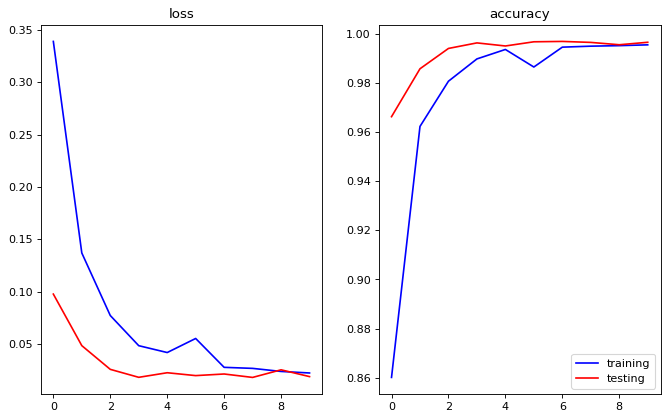

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.59it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


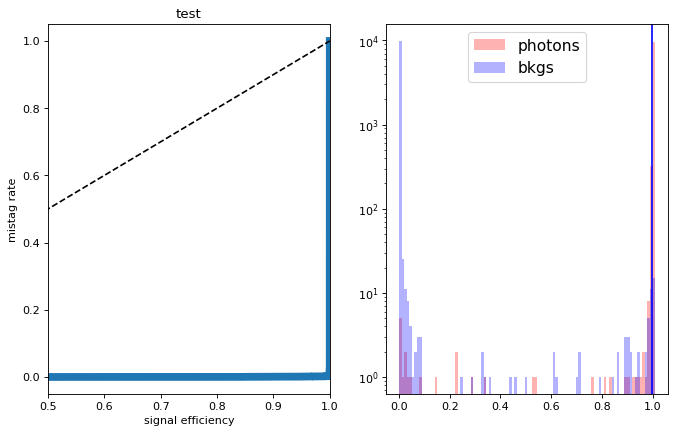

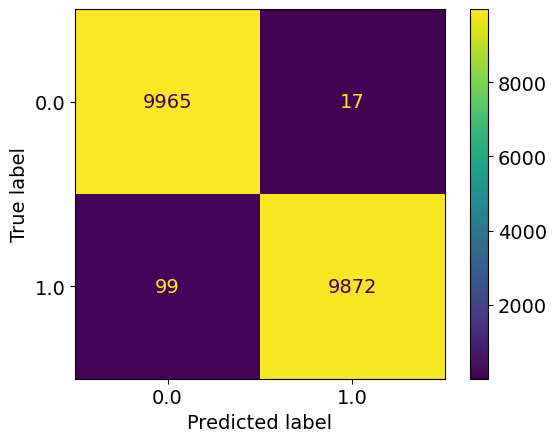

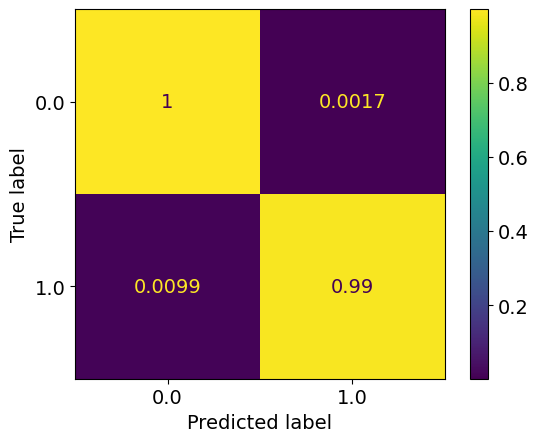

epoch: 10
Learning rate: 0.0009046462573286205


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:30<00:00,  4.35it/s]


train loss: 0.019877213374850575
train acc: 0.99585253


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.19it/s]


test loss: 0.02290121702582623
test acc: 0.99594045
epoch: 11
Learning rate: 0.0008854060213086439


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:29<00:00,  4.61it/s]


train loss: 0.018818532047535245
train acc: 0.9961157


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.36it/s]


test loss: 0.023608468757937075
test acc: 0.99614096
epoch: 12
Learning rate: 0.0008646447637978247


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:30<00:00,  4.39it/s]


train loss: 0.01851423211663322
train acc: 0.99647903


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.22it/s]


test loss: 0.01578175375898889
test acc: 0.99729365
new best acc: 0.99729365
epoch: 13
Learning rate: 0.0008424444199946417


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:29<00:00,  4.59it/s]


train loss: 0.018381942322463797
train acc: 0.99647903


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:04<00:00,  7.83it/s]


test loss: 0.014929253148586534
test acc: 0.9969428
epoch: 14
Learning rate: 0.0008188926045137138


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:28<00:00,  4.62it/s]


train loss: 0.016496806779056232
train acc: 0.9967547


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 11.96it/s]


test loss: 0.03751927609578963
test acc: 0.99478775
epoch: 15
Learning rate: 0.0007940822656109432


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:29<00:00,  4.59it/s]


train loss: 0.01561850180272569
train acc: 0.9967547


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:04<00:00,  8.14it/s]


test loss: 0.0141190535377438
test acc: 0.99714327
epoch: 16
Learning rate: 0.0007681113183592135


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:29<00:00,  4.60it/s]


train loss: 0.013829498718589989
train acc: 0.9972308


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.12it/s]


test loss: 0.021116657376082645
test acc: 0.9962913
epoch: 17
Learning rate: 0.00074108225822233


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:30<00:00,  4.36it/s]


train loss: 0.014478631353235122
train acc: 0.997068


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.36it/s]


test loss: 0.017860063630504394
test acc: 0.9972435
epoch: 18
Learning rate: 0.0007131017565522499


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:29<00:00,  4.57it/s]


train loss: 0.0132994407765331
train acc: 0.99730605


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 11.90it/s]


test loss: 0.011895862740215413
test acc: 0.99784493
new best acc: 0.99784493
epoch: 19
Learning rate: 0.0006842802396059903


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:30<00:00,  4.38it/s]


train loss: 0.011861391156154281
train acc: 0.99780726


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.48it/s]


test loss: 0.011400799920292068
test acc: 0.9980955
new best acc: 0.9980955


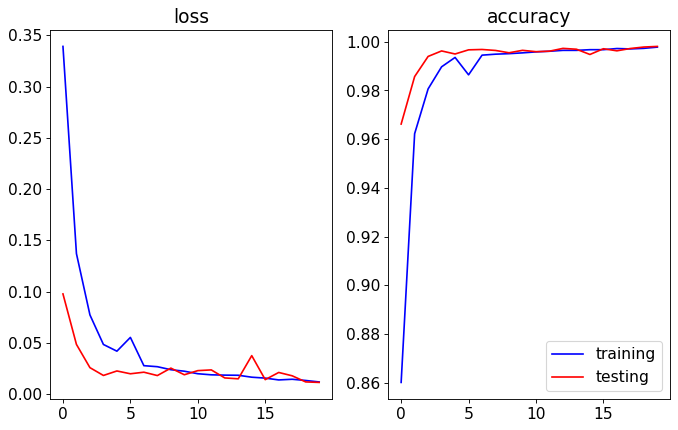

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.72it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


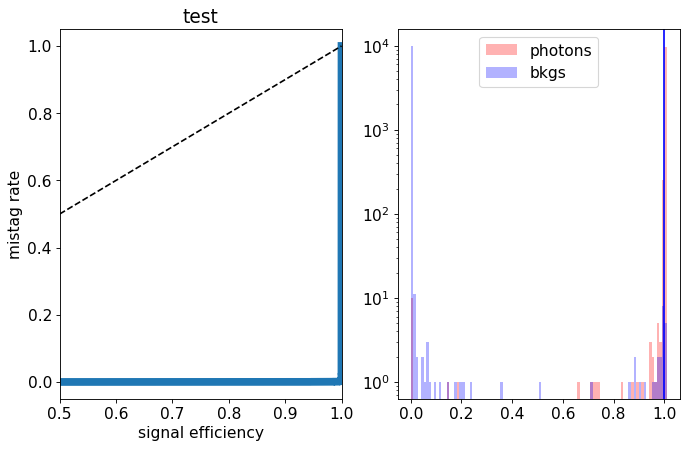

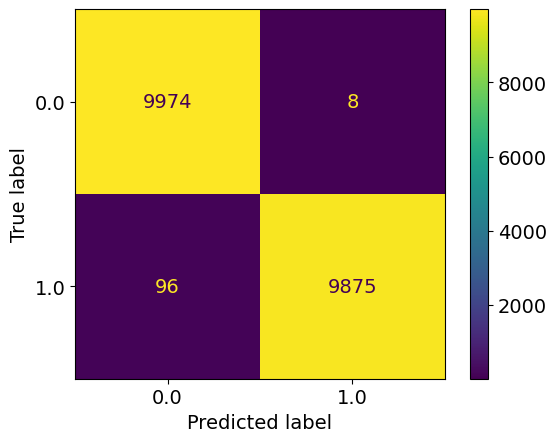

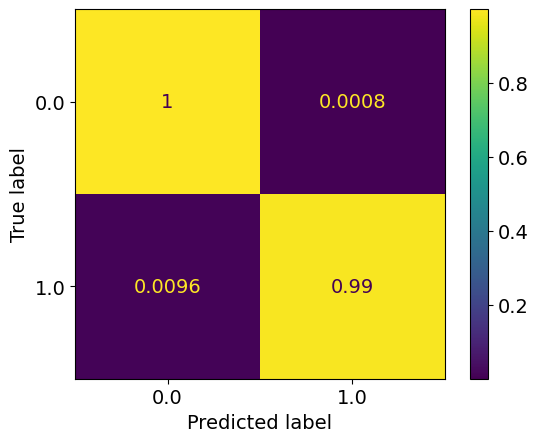

epoch: 20
Learning rate: 0.0006547314527436388


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:29<00:00,  4.58it/s]


train loss: 0.011252979902592278
train acc: 0.99744385


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.25it/s]


test loss: 0.01616122160853325
test acc: 0.9968927
epoch: 21
Learning rate: 0.0006245720115273849


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:30<00:00,  4.42it/s]


train loss: 0.01100435214653201
train acc: 0.9979451


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.18it/s]


test loss: 0.010341432018362063
test acc: 0.9982459
new best acc: 0.9982459
epoch: 22
Learning rate: 0.0005939209414931709


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:28<00:00,  4.63it/s]


train loss: 0.010174682968315224
train acc: 0.99807036


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.33it/s]


test loss: 0.015423649020128912
test acc: 0.9979452
epoch: 23
Learning rate: 0.0005628992084112799


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:30<00:00,  4.44it/s]


train loss: 0.009669703121059019
train acc: 0.99810797


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.30it/s]


test loss: 0.01344570665183068
test acc: 0.99714327
epoch: 24
Learning rate: 0.0005316292408897048


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:28<00:00,  4.62it/s]


train loss: 0.010941319515989905
train acc: 0.9979576


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:04<00:00,  8.31it/s]


test loss: 0.009569149769745041
test acc: 0.9980955
epoch: 25
Learning rate: 0.0005002344472043634


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:29<00:00,  4.59it/s]


train loss: 0.00845770251940516
train acc: 0.9980328


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.50it/s]


test loss: 0.006706853148005741
test acc: 0.99844635
new best acc: 0.99844635
epoch: 26
Learning rate: 0.0004688387282630152


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:29<00:00,  4.59it/s]


train loss: 0.009687658426275393
train acc: 0.9979827


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:04<00:00,  7.80it/s]


test loss: 0.011004205953753399
test acc: 0.9984965
new best acc: 0.9984965
epoch: 27
Learning rate: 0.0004375659886249822


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:29<00:00,  4.61it/s]


train loss: 0.00879650695489219
train acc: 0.99810797


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.50it/s]


test loss: 0.013037886267320975
test acc: 0.9976445
epoch: 28
Learning rate: 0.0004065396475064596


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:30<00:00,  4.41it/s]


train loss: 0.008237574712180883
train acc: 0.9982458


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.35it/s]


test loss: 0.00814943348083997
test acc: 0.9983962
epoch: 29
Learning rate: 0.0003758821517012554


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:28<00:00,  4.62it/s]


train loss: 0.007695022328416191
train acc: 0.99848384


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.52it/s]


test loss: 0.00900548935442537
test acc: 0.99819577


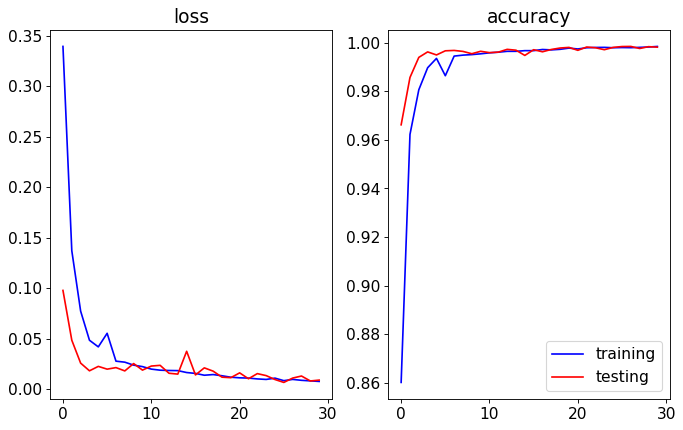

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.35it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


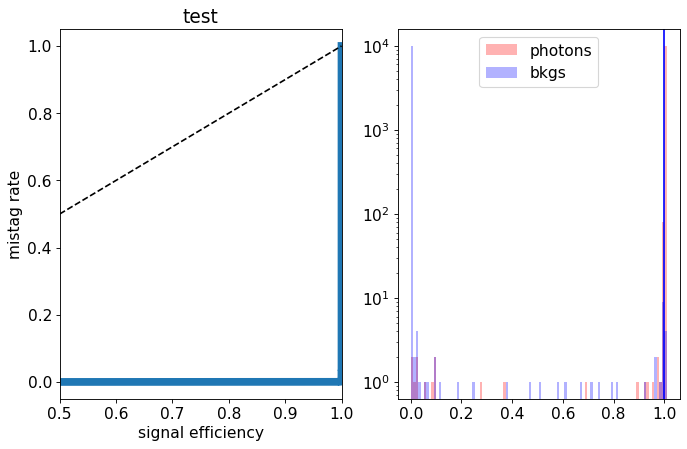

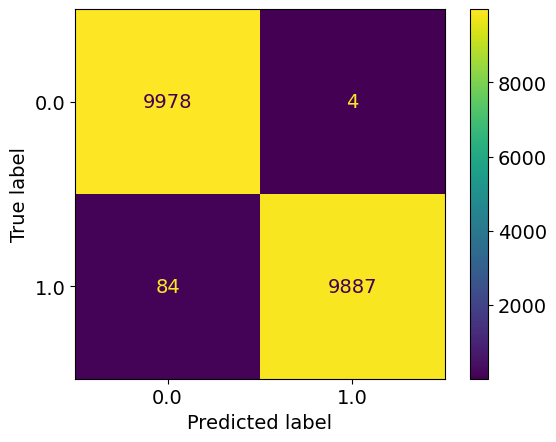

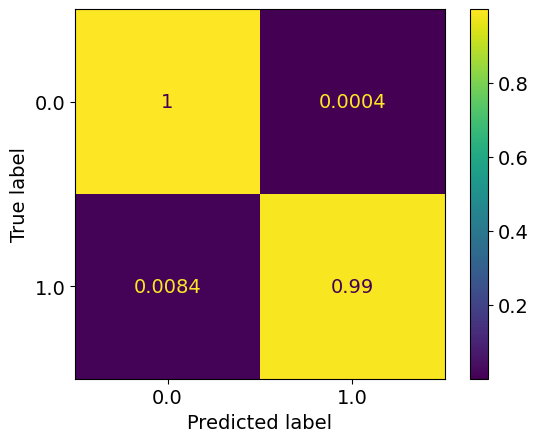

epoch: 30
Learning rate: 0.00034571449233923525


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:30<00:00,  4.39it/s]


train loss: 0.008581609555262527
train acc: 0.9982583


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.16it/s]


test loss: 0.01594844120453963
test acc: 0.9976946
epoch: 31
Learning rate: 0.0003161557273896085


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:29<00:00,  4.61it/s]


train loss: 0.008061875138951312
train acc: 0.99838364


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.49it/s]


test loss: 0.010662013179817657
test acc: 0.99819577
epoch: 32
Learning rate: 0.00028732251179351616


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:30<00:00,  4.43it/s]


train loss: 0.006721289932998002
train acc: 0.9986092


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.61it/s]


test loss: 0.007988036741534522
test acc: 0.998296
epoch: 33
Learning rate: 0.00025932863708027284


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:28<00:00,  4.63it/s]


train loss: 0.006293153263013393
train acc: 0.9985966


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.06it/s]


test loss: 0.011661631922090224
test acc: 0.9983461
epoch: 34
Learning rate: 0.00023228458228418658


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:30<00:00,  4.41it/s]


train loss: 0.0073981550010965074
train acc: 0.99864674


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.16it/s]


test loss: 0.006560776712404593
test acc: 0.9988473
new best acc: 0.9988473
epoch: 35
Learning rate: 0.00020629707793428436


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:28<00:00,  4.63it/s]


train loss: 0.006193726440829072
train acc: 0.9987846


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:04<00:00,  7.42it/s]


test loss: 0.014170029426422726
test acc: 0.9979452
epoch: 36
Learning rate: 0.00018146868483767388


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:28<00:00,  4.63it/s]


train loss: 0.006048079741221166
train acc: 0.9989475


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.31it/s]


test loss: 0.010045489824325586
test acc: 0.9986468
epoch: 37
Learning rate: 0.00015789738931889374


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:29<00:00,  4.62it/s]


train loss: 0.005644291952085584
train acc: 0.99882215


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:04<00:00,  7.78it/s]


test loss: 0.00585010545349488
test acc: 0.99889743
new best acc: 0.99889743
epoch: 38
Learning rate: 0.00013567621651265567


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:29<00:00,  4.57it/s]


train loss: 0.0054250747738370225
train acc: 0.9988848


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.00it/s]


test loss: 0.013040600316443829
test acc: 0.9979452
epoch: 39
Learning rate: 0.00011489286323613779


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:30<00:00,  4.42it/s]


train loss: 0.005937091642617341
train acc: 0.9988723


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.68it/s]


test loss: 0.009101235595554242
test acc: 0.9985466


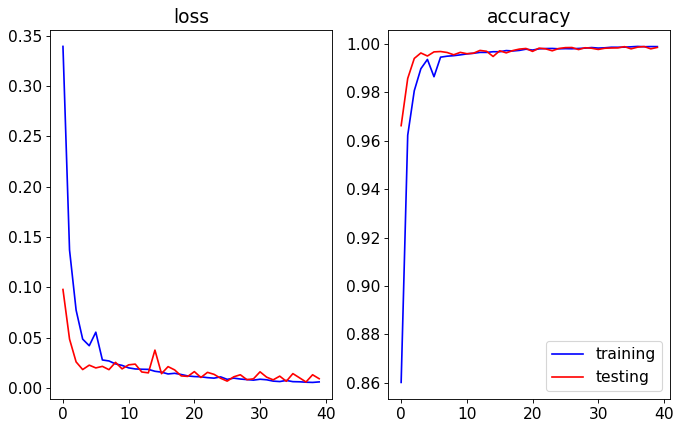

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.51it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


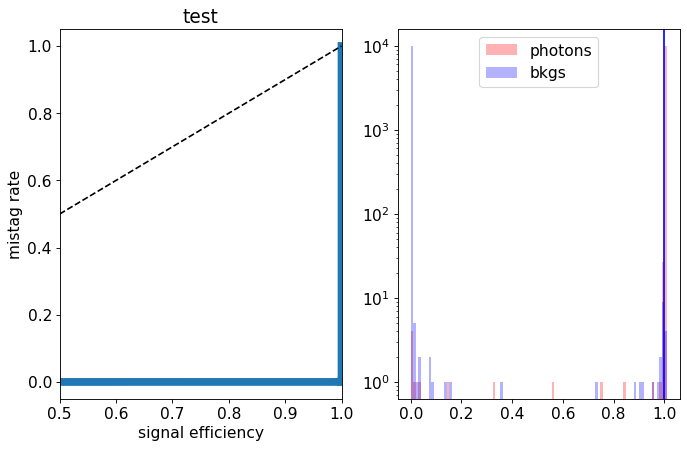

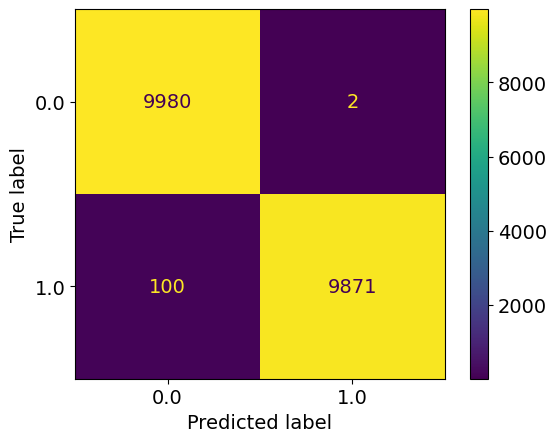

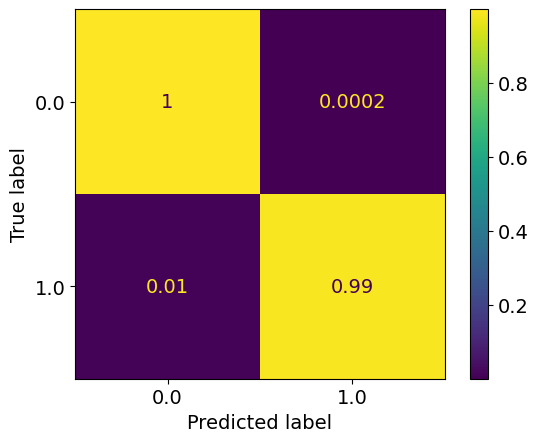

epoch: 40
Learning rate: 9.562935188971167e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:29<00:00,  4.62it/s]


train loss: 0.0056330153750952456
train acc: 0.99896


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.38it/s]


test loss: 0.003984480985080301
test acc: 0.9992482
new best acc: 0.9992482
epoch: 41
Learning rate: 7.796170675200053e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:30<00:00,  4.45it/s]


train loss: 0.00599385026856256
train acc: 0.9988974


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.41it/s]


test loss: 0.0062966484018323185
test acc: 0.99874705
epoch: 42
Learning rate: 6.195965394678333e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:29<00:00,  4.62it/s]


train loss: 0.005700862750588263
train acc: 0.9988974


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.40it/s]


test loss: 0.006176366351295403
test acc: 0.99889743
epoch: 43
Learning rate: 4.768634626584012e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:30<00:00,  4.46it/s]


train loss: 0.0052333440403141245
train acc: 0.9989224


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.73it/s]


test loss: 0.007180932225318603
test acc: 0.99874705
epoch: 44
Learning rate: 3.519811393373329e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:28<00:00,  4.65it/s]


train loss: 0.0055293377528815016
train acc: 0.99897254


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.15it/s]


test loss: 0.005314537390735364
test acc: 0.99919814
epoch: 45
Learning rate: 2.4544242298147113e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:30<00:00,  4.39it/s]


train loss: 0.005182126687262764
train acc: 0.9990352


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.21it/s]


test loss: 0.007116632682255767
test acc: 0.9988473
epoch: 46
Learning rate: 1.5766777323136307e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:29<00:00,  4.58it/s]


train loss: 0.005509584475788218
train acc: 0.9989475


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:04<00:00,  7.70it/s]


test loss: 0.007438746706791018
test acc: 0.9986969
epoch: 47
Learning rate: 8.900359652914913e-06


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:29<00:00,  4.59it/s]


train loss: 0.00518238968224842
train acc: 0.9990853


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.53it/s]


test loss: 0.0069306797648805395
test acc: 0.99874705
epoch: 48
Learning rate: 3.972087901059351e-06


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:29<00:00,  4.61it/s]


train loss: 0.0059472709974976
train acc: 0.99899757


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:04<00:00,  8.14it/s]


test loss: 0.007191676352455127
test acc: 0.99874705
epoch: 49
Learning rate: 1.0014117046612258e-06


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:28<00:00,  4.65it/s]


train loss: 0.005354354826997577
train acc: 0.9989099


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.02it/s]


test loss: 0.006905994476690413
test acc: 0.99874705


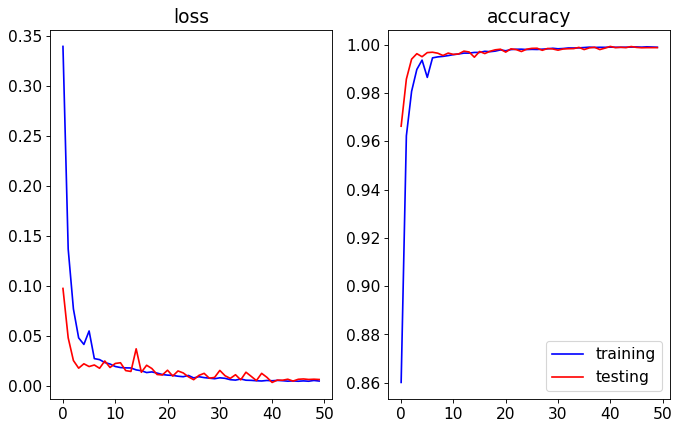

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.57it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


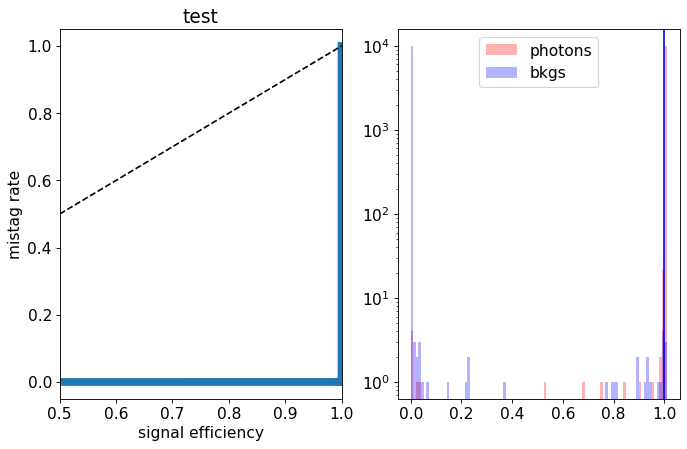

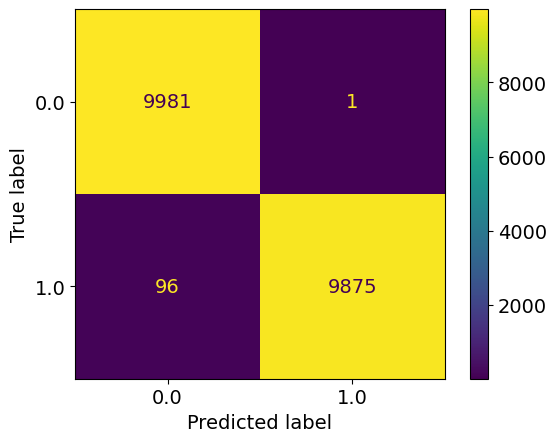

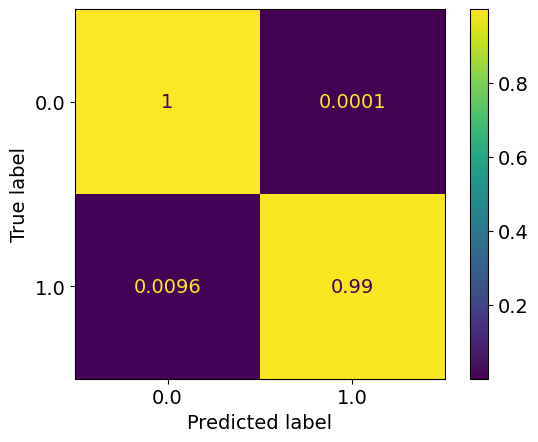

epoch: 50
Learning rate: 5.4965494655778717e-11


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:30<00:00,  4.32it/s]


train loss: 0.014351264978480984
train acc: 0.9967672


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.57it/s]


test loss: 0.011019428802542815
test acc: 0.9982459
epoch: 51
Learning rate: 0.0009990280304188672


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:29<00:00,  4.61it/s]


train loss: 0.011066174813991051
train acc: 0.99764436


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.21it/s]


test loss: 0.013934349791631629
test acc: 0.9974941
epoch: 52
Learning rate: 0.0009960866801513866


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:30<00:00,  4.38it/s]


train loss: 0.011942581570735062
train acc: 0.9974188


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.09it/s]


test loss: 0.020179265062083954
test acc: 0.9970431
epoch: 53
Learning rate: 0.0009911875023977943


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:28<00:00,  4.62it/s]


train loss: 0.010760448546385143
train acc: 0.9978448


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.02it/s]


test loss: 0.0068879881428341935
test acc: 0.9984965
epoch: 54
Learning rate: 0.0009843498319744622


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:30<00:00,  4.44it/s]


train loss: 0.009287662360619115
train acc: 0.9981706


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.38it/s]


test loss: 0.006862670244766591
test acc: 0.99889743
epoch: 55
Learning rate: 0.0009756006540427169


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:28<00:00,  4.63it/s]


train loss: 0.008596034266172782
train acc: 0.9982834


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.52it/s]


test loss: 0.012584966016126653
test acc: 0.99789506
epoch: 56
Learning rate: 0.0009649744976107358


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:29<00:00,  4.47it/s]


train loss: 0.008447000695529972
train acc: 0.99809545


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.40it/s]


test loss: 0.011593277979782816
test acc: 0.9983962
epoch: 57
Learning rate: 0.0009525132992633266


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:29<00:00,  4.60it/s]


train loss: 0.006955068603250522
train acc: 0.9984212


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:04<00:00,  7.87it/s]


test loss: 0.011181163967571994
test acc: 0.99819577
epoch: 58
Learning rate: 0.0009382662376573867


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:29<00:00,  4.61it/s]


train loss: 0.00794822458881944
train acc: 0.998321


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.44it/s]


test loss: 0.005937773304724454
test acc: 0.9988473
epoch: 59
Learning rate: 0.0009222895394362114


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:29<00:00,  4.58it/s]


train loss: 0.006808825215123205
train acc: 0.99843377


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:04<00:00,  7.73it/s]


test loss: 0.0098766773679599
test acc: 0.99844635


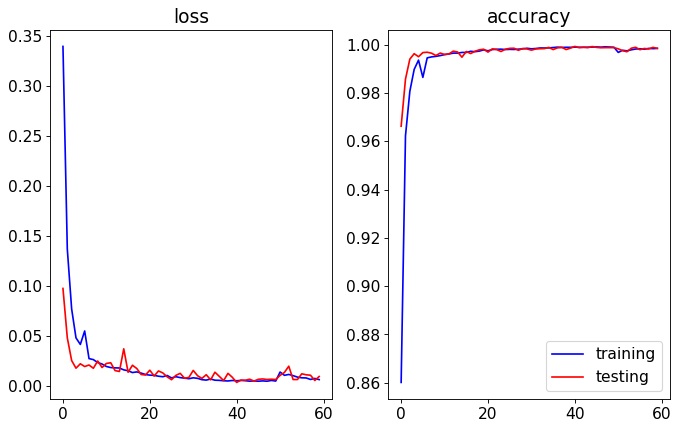

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.35it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


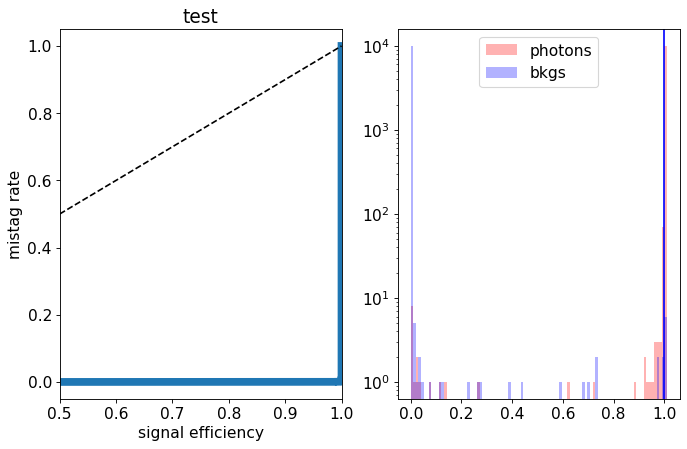

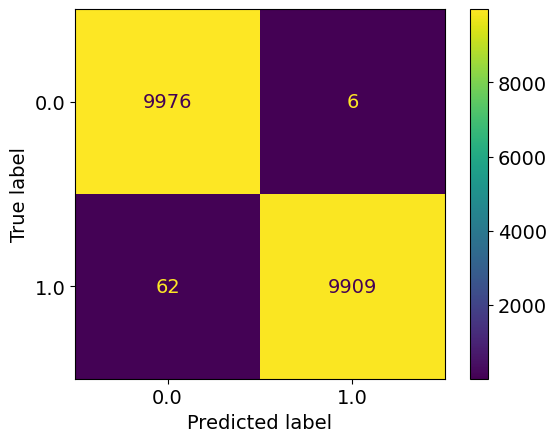

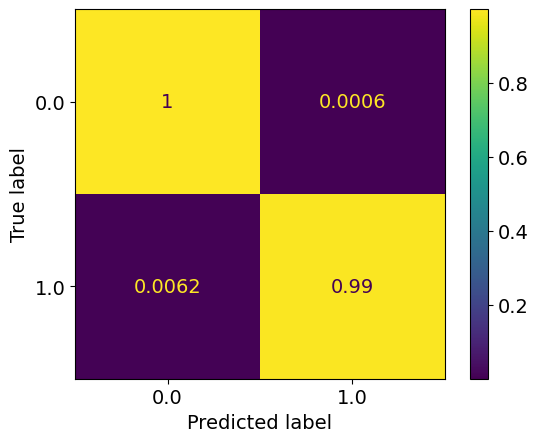

epoch: 60
Learning rate: 0.0009046462573286205


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:29<00:00,  4.59it/s]


train loss: 0.0071107468130362375
train acc: 0.9984588


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.05it/s]


test loss: 0.00406857713878808
test acc: 0.99929833
new best acc: 0.99929833
epoch: 61
Learning rate: 0.0008854060213086439


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:30<00:00,  4.33it/s]


train loss: 0.006986802052480599
train acc: 0.9984713


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 11.98it/s]


test loss: 0.009604028157227999
test acc: 0.998296
epoch: 62
Learning rate: 0.0008646447637978247


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:29<00:00,  4.59it/s]


train loss: 0.0072266230235439235
train acc: 0.99834603


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.49it/s]


test loss: 0.01251995237921519
test acc: 0.9976946
epoch: 63
Learning rate: 0.0008424444199946417


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:30<00:00,  4.38it/s]


train loss: 0.006860924825498692
train acc: 0.99839616


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.49it/s]


test loss: 0.01217357398296064
test acc: 0.9979452
epoch: 64
Learning rate: 0.0008188926045137139


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:28<00:00,  4.67it/s]


train loss: 0.00618508972414685
train acc: 0.9987971


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.86it/s]


test loss: 0.025699157035620267
test acc: 0.99644166
epoch: 65
Learning rate: 0.0007940822656109432


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:30<00:00,  4.41it/s]


train loss: 0.004949720458687047
train acc: 0.9989349


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.41it/s]


test loss: 0.005077887535917151
test acc: 0.99929833
epoch: 66
Learning rate: 0.0007681113183592136


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:28<00:00,  4.63it/s]


train loss: 0.007653846097901575
train acc: 0.99852145


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.38it/s]


test loss: 0.008662647352048894
test acc: 0.9985466
epoch: 67
Learning rate: 0.00074108225822233


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:30<00:00,  4.39it/s]


train loss: 0.006485968041461228
train acc: 0.99868435


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.20it/s]


test loss: 0.0030635988466415943
test acc: 0.9993986
new best acc: 0.9993986
epoch: 68
Learning rate: 0.0007131017565522502


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:29<00:00,  4.57it/s]


train loss: 0.006032221421074651
train acc: 0.998747


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:04<00:00,  8.18it/s]


test loss: 0.003944021405806264
test acc: 0.999148
epoch: 69
Learning rate: 0.0006842802396059904


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:29<00:00,  4.61it/s]


train loss: 0.005575626858974001
train acc: 0.9987971


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.36it/s]


test loss: 0.0057617950050829385
test acc: 0.9989976


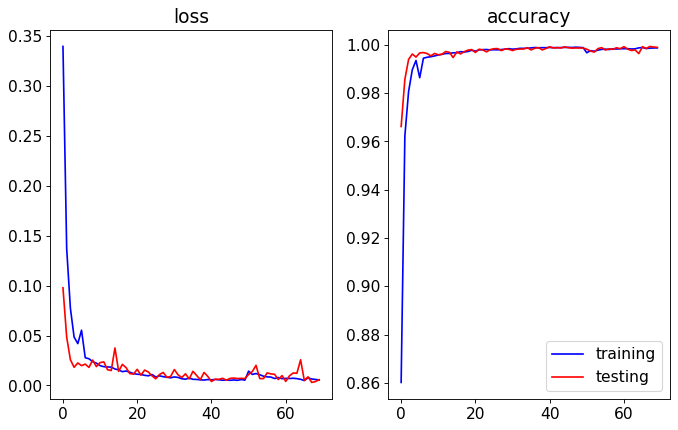

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.16it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


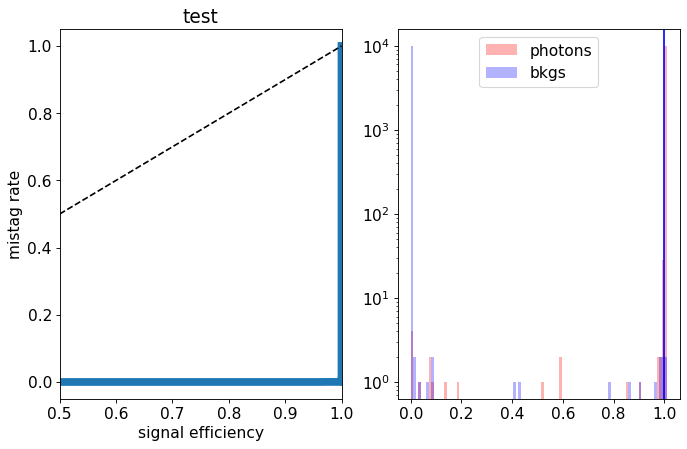

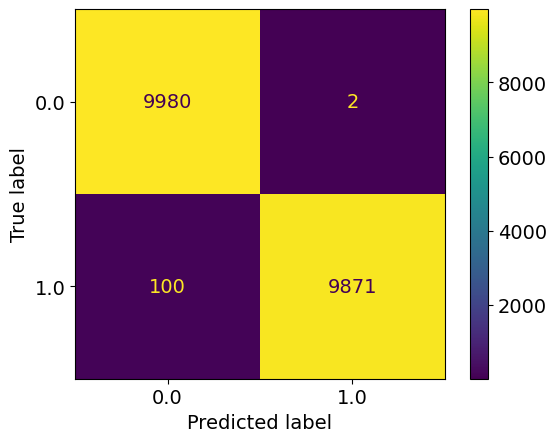

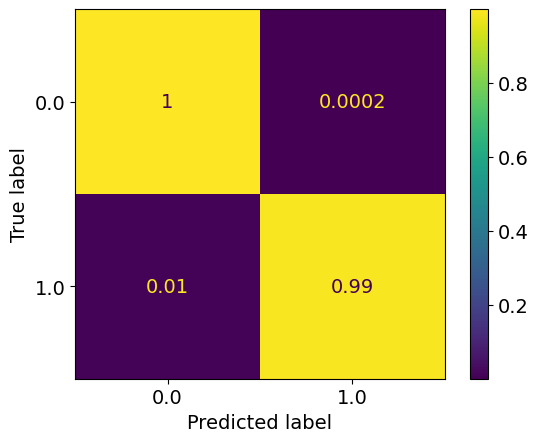

epoch: 70
Learning rate: 0.0006547314527436389


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:26<00:00,  5.07it/s]


train loss: 0.0066745680044905656
train acc: 0.9984964


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.09it/s]


test loss: 0.01785143552779837
test acc: 0.99784493
epoch: 71
Learning rate: 0.0006245720115273849


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:27<00:00,  4.81it/s]


train loss: 0.005694686362186252
train acc: 0.9987846


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.41it/s]


test loss: 0.01263125680101412
test acc: 0.99844635
epoch: 72
Learning rate: 0.000593920941493171


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:30<00:00,  4.40it/s]


train loss: 0.005825558245807987
train acc: 0.9988848


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.60it/s]


test loss: 0.0037689336515822364
test acc: 0.999148
epoch: 73
Learning rate: 0.00056289920841128


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:28<00:00,  4.63it/s]


train loss: 0.004305265894256977
train acc: 0.99896


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.43it/s]


test loss: 0.0029409971465843695
test acc: 0.99934846
epoch: 74
Learning rate: 0.0005316292408897048


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:30<00:00,  4.45it/s]


train loss: 0.004450154432995634
train acc: 0.99896


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.44it/s]


test loss: 0.0034977192513658043
test acc: 0.99929833
epoch: 75
Learning rate: 0.0005002344472043636


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:28<00:00,  4.63it/s]


train loss: 0.004935169947609903
train acc: 0.99896


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.37it/s]


test loss: 0.002555956133497899
test acc: 0.9995489
new best acc: 0.9995489
epoch: 76
Learning rate: 0.00046883872826301544


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:30<00:00,  4.42it/s]


train loss: 0.004358163644704574
train acc: 0.9990978


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.39it/s]


test loss: 0.004061091096677901
test acc: 0.9992482
epoch: 77
Learning rate: 0.0004375659886249823


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:28<00:00,  4.63it/s]


train loss: 0.004085505560156048
train acc: 0.9990603


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.55it/s]


test loss: 0.007061576215461016
test acc: 0.9988473
epoch: 78
Learning rate: 0.0004065396475064596


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:30<00:00,  4.40it/s]


train loss: 0.0046776811826414666
train acc: 0.9988974


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.18it/s]


test loss: 0.01598323292946091
test acc: 0.9980454
epoch: 79
Learning rate: 0.0003758821517012555


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:28<00:00,  4.63it/s]


train loss: 0.0037770806678719365
train acc: 0.9992231


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:04<00:00,  8.18it/s]


test loss: 0.02378939931718679
test acc: 0.99729365


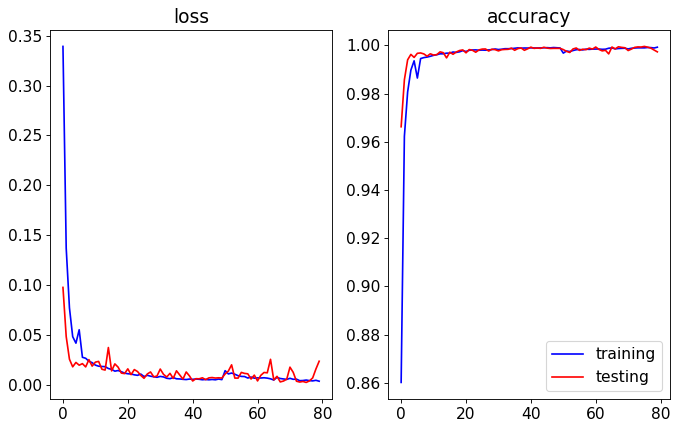

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.59it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


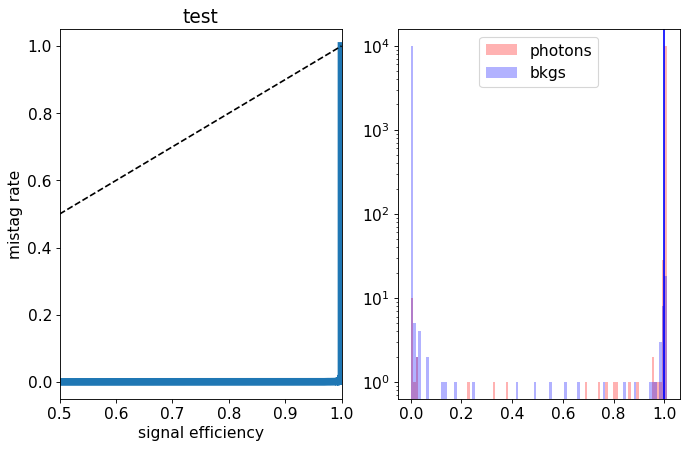

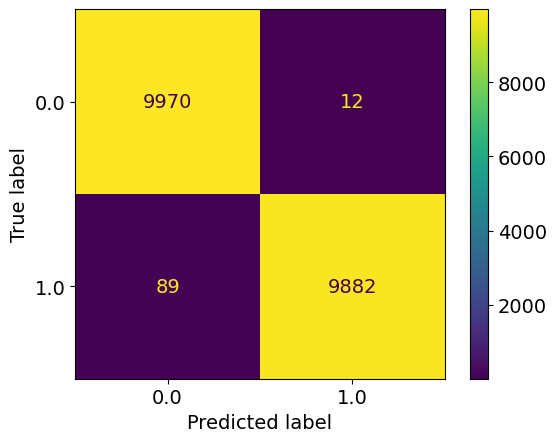

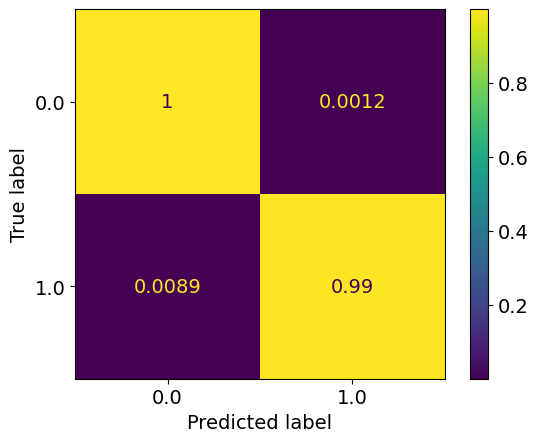

epoch: 80
Learning rate: 0.00034571449233923536


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:28<00:00,  4.63it/s]


train loss: 0.003927836988718334
train acc: 0.99913543


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.30it/s]


test loss: 0.030700640392724916
test acc: 0.99649173
epoch: 81
Learning rate: 0.00031615572738960855


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:30<00:00,  4.34it/s]


train loss: 0.004295559826310474
train acc: 0.99899757


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.39it/s]


test loss: 0.010150850444442253
test acc: 0.9986969
epoch: 82
Learning rate: 0.00028732251179351616


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:29<00:00,  4.62it/s]


train loss: 0.0036902953308065242
train acc: 0.9994111


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.33it/s]


test loss: 0.005527059813332739
test acc: 0.99919814
epoch: 83
Learning rate: 0.00025932863708027284


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:30<00:00,  4.39it/s]


train loss: 0.0033186112959268017
train acc: 0.9993359


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 11.88it/s]


test loss: 0.005645267764390821
test acc: 0.9990979
epoch: 84
Learning rate: 0.00023228458228418658


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:28<00:00,  4.62it/s]


train loss: 0.0033878519155479654
train acc: 0.99927324


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.30it/s]


test loss: 0.005651304760719348
test acc: 0.9992482
epoch: 85
Learning rate: 0.00020629707793428436


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:30<00:00,  4.46it/s]


train loss: 0.0035755098661906935
train acc: 0.9990728


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.50it/s]


test loss: 0.005819118123070951
test acc: 0.99904776
epoch: 86
Learning rate: 0.00018146868483767388


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:28<00:00,  4.63it/s]


train loss: 0.003433672180746264
train acc: 0.9993359


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.36it/s]


test loss: 0.0034883353918150795
test acc: 0.9994487
epoch: 87
Learning rate: 0.00015789738931889374


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:30<00:00,  4.43it/s]


train loss: 0.0036160015060615015
train acc: 0.9992357


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.51it/s]


test loss: 0.0065421526519460075
test acc: 0.9990979
epoch: 88
Learning rate: 0.00013567621651265567


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:28<00:00,  4.65it/s]


train loss: 0.0032650653477965044
train acc: 0.99916047


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.43it/s]


test loss: 0.005428794739340692
test acc: 0.9990979
epoch: 89
Learning rate: 0.00011489286323613779


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:30<00:00,  4.37it/s]


train loss: 0.0027039271986560283
train acc: 0.99944866


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.50it/s]


test loss: 0.01214562504693623
test acc: 0.9983461


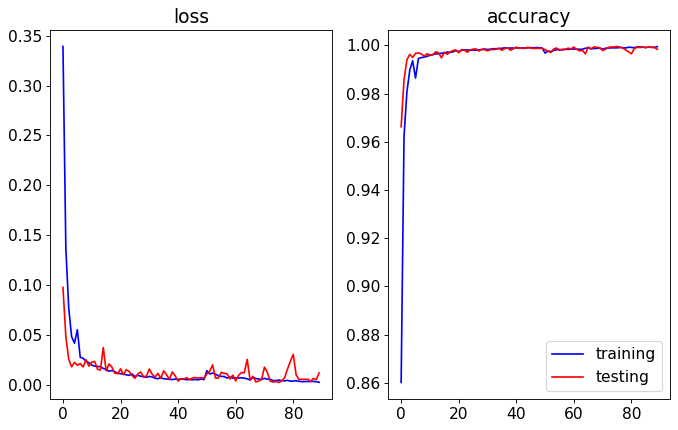

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.48it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


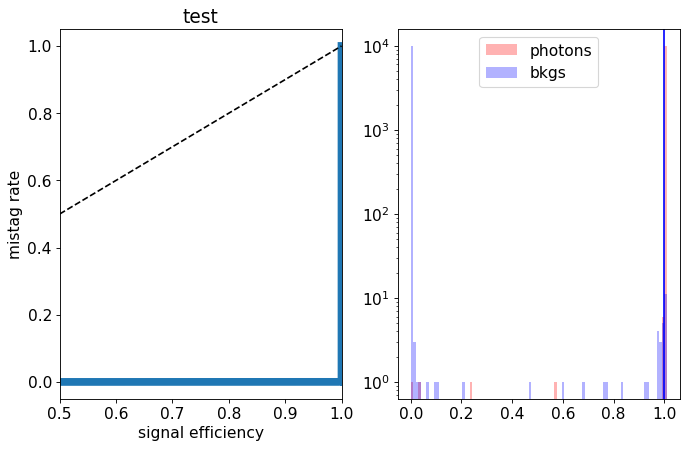

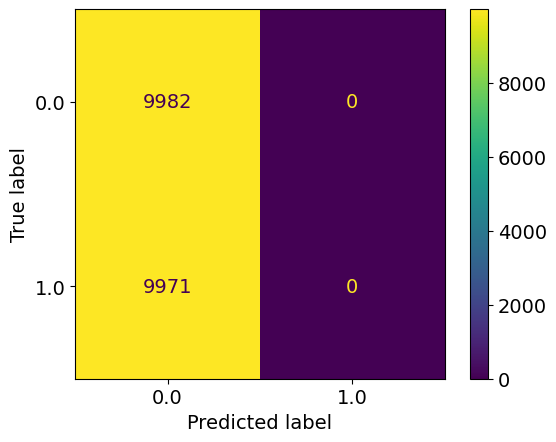

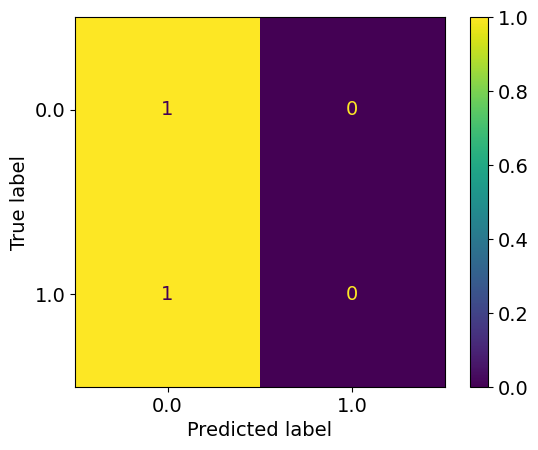

epoch: 90
Learning rate: 9.562935188971167e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:30<00:00,  4.41it/s]


train loss: 0.0033106966262992964
train acc: 0.9992607


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.16it/s]


test loss: 0.008234689351560139
test acc: 0.99889743
epoch: 91
Learning rate: 7.796170675200053e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:29<00:00,  4.61it/s]


train loss: 0.0030971819245162657
train acc: 0.99934846


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 11.82it/s]


test loss: 0.012165031929974646
test acc: 0.998296
epoch: 92
Learning rate: 6.195965394678333e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:30<00:00,  4.43it/s]


train loss: 0.003094090497835345
train acc: 0.9993359


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.24it/s]


test loss: 0.007118573714740078
test acc: 0.99904776
epoch: 93
Learning rate: 4.768634626584012e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:29<00:00,  4.59it/s]


train loss: 0.0032502635631452607
train acc: 0.99931085


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.24it/s]


test loss: 0.006925598021307041
test acc: 0.9990979
epoch: 94
Learning rate: 3.519811393373329e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:30<00:00,  4.38it/s]


train loss: 0.0029048039407744406
train acc: 0.99929833


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.43it/s]


test loss: 0.005955233084674148
test acc: 0.99929833
epoch: 95
Learning rate: 2.4544242298147113e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:29<00:00,  4.60it/s]


train loss: 0.0029640763203187545
train acc: 0.9994236


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.37it/s]


test loss: 0.005706645802369787
test acc: 0.99929833
epoch: 96
Learning rate: 1.5766777323136307e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:30<00:00,  4.36it/s]


train loss: 0.003121502461053473
train acc: 0.9992357


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.63it/s]


test loss: 0.0057729623500001786
test acc: 0.9992482
epoch: 97
Learning rate: 8.900359652914913e-06


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:28<00:00,  4.63it/s]


train loss: 0.003078758166420405
train acc: 0.99931085


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.44it/s]


test loss: 0.005652810693938036
test acc: 0.99929833
epoch: 98
Learning rate: 3.972087901059351e-06


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:30<00:00,  4.38it/s]


train loss: 0.0029845414052345662
train acc: 0.9993735


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.64it/s]


test loss: 0.005704873666060754
test acc: 0.99929833
epoch: 99
Learning rate: 1.0014117046612258e-06


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:29<00:00,  4.62it/s]


train loss: 0.002597004541060944
train acc: 0.99948627


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:04<00:00,  8.29it/s]


test loss: 0.0056974522801648345
test acc: 0.99929833


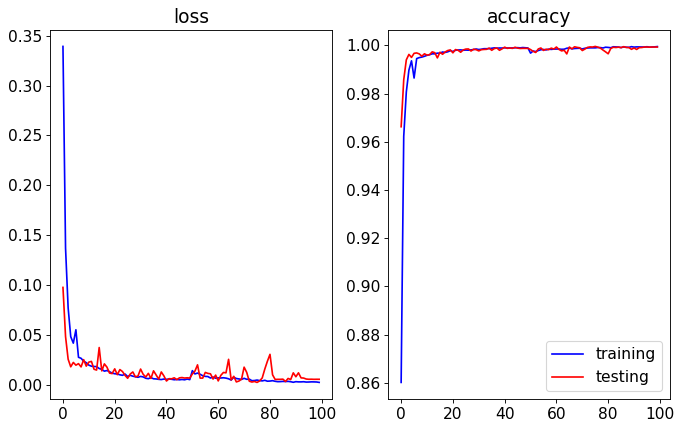

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 11.96it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


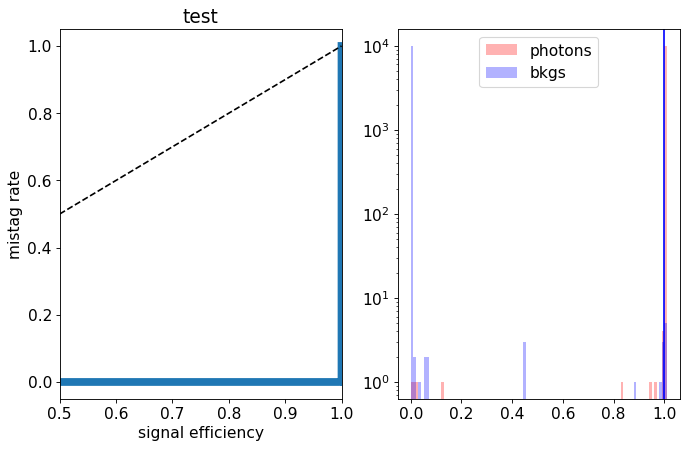

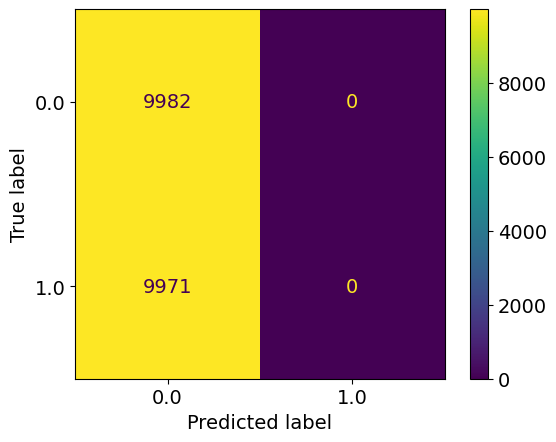

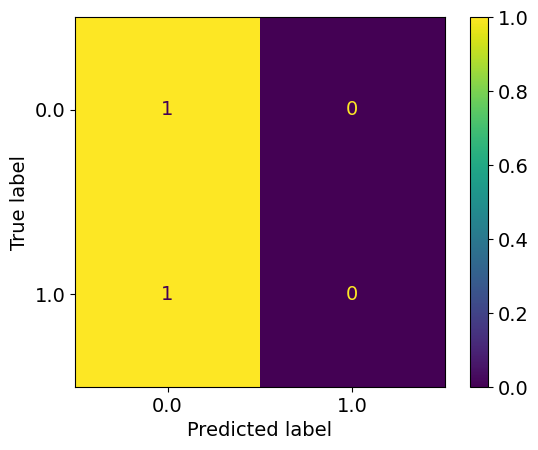

epoch: 100
Learning rate: 5.4965494655778717e-11


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:29<00:00,  4.59it/s]


train loss: 0.007977450028437175
train acc: 0.99827087


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.24it/s]


test loss: 0.010326847844281166
test acc: 0.9980454
epoch: 101
Learning rate: 0.0009990280304188672


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:30<00:00,  4.37it/s]


train loss: 0.00707180983340889
train acc: 0.99837106


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 11.87it/s]


test loss: 0.005146999542917119
test acc: 0.9989976
epoch: 102
Learning rate: 0.0009960866801513866


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:29<00:00,  4.58it/s]


train loss: 0.00837365295827981
train acc: 0.99810797


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.32it/s]


test loss: 0.0021025810718894636
test acc: 0.9995489
epoch: 103
Learning rate: 0.0009911875023977943


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:30<00:00,  4.36it/s]


train loss: 0.0054873252967754796
train acc: 0.99885976


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.56it/s]


test loss: 0.004799236785652952
test acc: 0.9990979
epoch: 104
Learning rate: 0.0009843498319744622


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:28<00:00,  4.62it/s]


train loss: 0.005680370226149426
train acc: 0.99885976


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.54it/s]


test loss: 0.0028103623603248492
test acc: 0.9993986
epoch: 105
Learning rate: 0.0009756006540427169


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:30<00:00,  4.37it/s]


train loss: 0.0070567026203533
train acc: 0.99835855


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.16it/s]


test loss: 0.00677807849780537
test acc: 0.99889743
epoch: 106
Learning rate: 0.0009649744976107358


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:29<00:00,  4.59it/s]


train loss: 0.006526578833051929
train acc: 0.9984964


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 11.78it/s]


test loss: 0.007785920620516235
test acc: 0.9986468
epoch: 107
Learning rate: 0.0009525132992633266


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:30<00:00,  4.36it/s]


train loss: 0.007403413979854624
train acc: 0.9984087


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.38it/s]


test loss: 0.00463388556287595
test acc: 0.99889743
epoch: 108
Learning rate: 0.0009382662376573867


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:29<00:00,  4.61it/s]


train loss: 0.005587570884628477
train acc: 0.9989349


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.07it/s]


test loss: 0.003802100441815693
test acc: 0.9992482
epoch: 109
Learning rate: 0.0009222895394362114


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:30<00:00,  4.37it/s]


train loss: 0.004715236949855887
train acc: 0.99897254


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.19it/s]


test loss: 0.0038273610150424734
test acc: 0.99919814


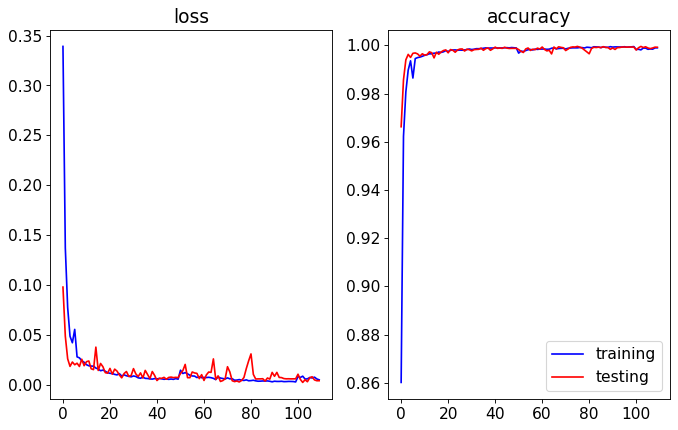

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.09it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


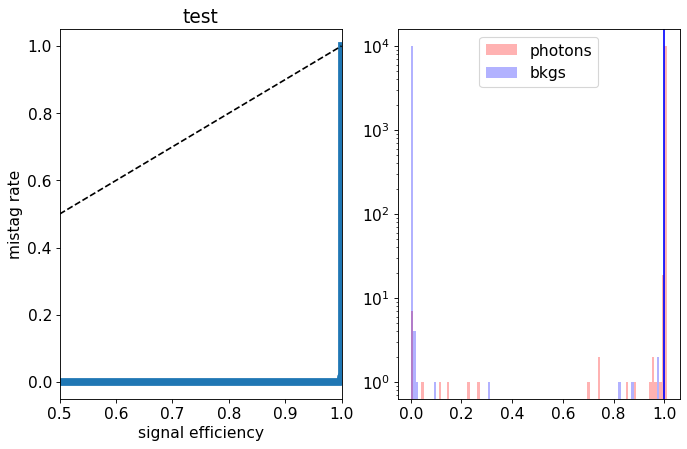

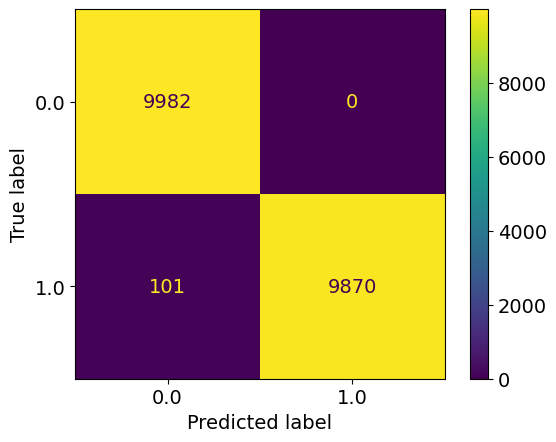

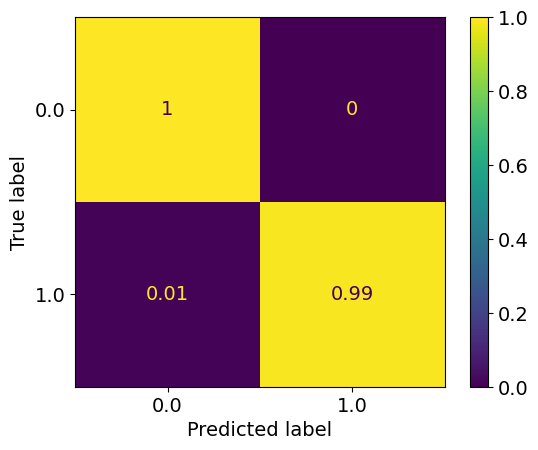

epoch: 110
Learning rate: 0.0009046462573286205


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:30<00:00,  4.40it/s]


train loss: 0.005695740672335752
train acc: 0.998772


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.37it/s]


test loss: 0.001986021332811456
test acc: 0.99959904
new best acc: 0.99959904
epoch: 111
Learning rate: 0.0008854060213086439


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:29<00:00,  4.58it/s]


train loss: 0.005129962189139431
train acc: 0.9989224


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.35it/s]


test loss: 0.008501938504496731
test acc: 0.9987972
epoch: 112
Learning rate: 0.0008646447637978247


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:30<00:00,  4.37it/s]


train loss: 0.0048836374511146766
train acc: 0.99901015


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.32it/s]


test loss: 0.004927226015078478
test acc: 0.9989976
epoch: 113
Learning rate: 0.0008424444199946417


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:29<00:00,  4.61it/s]


train loss: 0.0052290769017417915
train acc: 0.99880964


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.15it/s]


test loss: 0.006805348948987825
test acc: 0.9987972
epoch: 114
Learning rate: 0.0008188926045137139


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:30<00:00,  4.36it/s]


train loss: 0.00481262477006179
train acc: 0.99901015


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.24it/s]


test loss: 0.008660892834852267
test acc: 0.9985466
epoch: 115
Learning rate: 0.0007940822656109432


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:29<00:00,  4.60it/s]


train loss: 0.004543057451747257
train acc: 0.9990728


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.10it/s]


test loss: 0.006898956235482475
test acc: 0.9987972
epoch: 116
Learning rate: 0.0007681113183592136


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:30<00:00,  4.39it/s]


train loss: 0.005583710094945116
train acc: 0.9988974


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.17it/s]


test loss: 0.006686941981498172
test acc: 0.9986468
epoch: 117
Learning rate: 0.00074108225822233


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:28<00:00,  4.63it/s]


train loss: 0.00425355443081544
train acc: 0.9989099


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 11.88it/s]


test loss: 0.001987976128139939
test acc: 0.9996993
new best acc: 0.9996993
epoch: 118
Learning rate: 0.0007131017565522502


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:30<00:00,  4.35it/s]


train loss: 0.0040278531182661595
train acc: 0.999173


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.29it/s]


test loss: 0.0053402327876296216
test acc: 0.9992482
epoch: 119
Learning rate: 0.0006842802396059904


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:29<00:00,  4.61it/s]


train loss: 0.003005631433525331
train acc: 0.9993359


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.10it/s]


test loss: 0.034718695218171884
test acc: 0.99669224


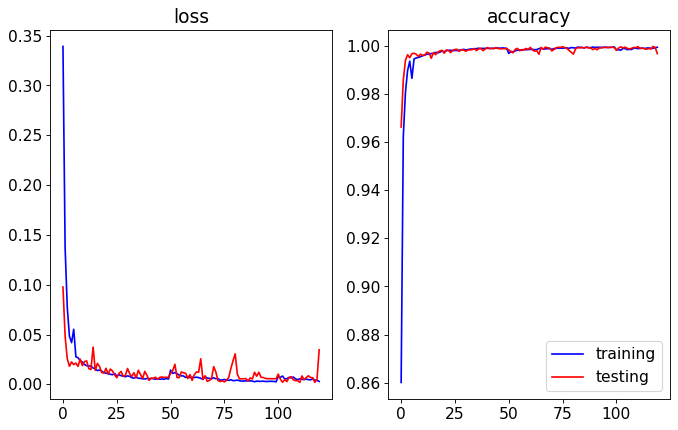

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:04<00:00,  7.94it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


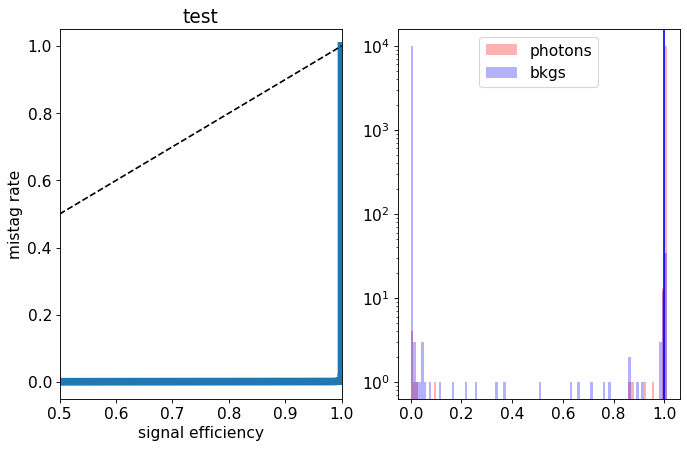

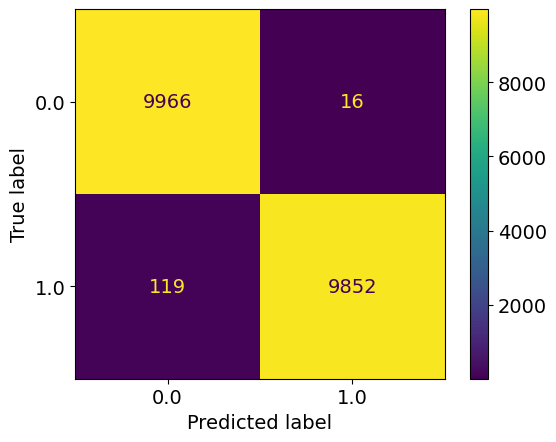

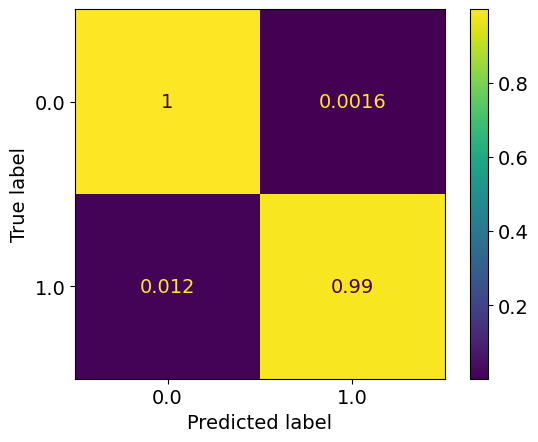

epoch: 120
Learning rate: 0.0006547314527436389


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:29<00:00,  4.59it/s]


train loss: 0.004364648842124213
train acc: 0.9990477


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.39it/s]


test loss: 0.01427669224149497
test acc: 0.99819577
epoch: 121
Learning rate: 0.0006245720115273849


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:30<00:00,  4.41it/s]


train loss: 0.004566730890026031
train acc: 0.99902266


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.31it/s]


test loss: 0.0057583547375673685
test acc: 0.9989475
epoch: 122
Learning rate: 0.000593920941493171


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:28<00:00,  4.64it/s]


train loss: 0.0037011764080928703
train acc: 0.99928576


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.63it/s]


test loss: 0.007750250650088099
test acc: 0.9988473
epoch: 123
Learning rate: 0.00056289920841128


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:30<00:00,  4.37it/s]


train loss: 0.0037127037898814583
train acc: 0.99913543


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.48it/s]


test loss: 0.005872108606059565
test acc: 0.99904776
epoch: 124
Learning rate: 0.0005316292408897048


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:29<00:00,  4.57it/s]


train loss: 0.0037294011732473026
train acc: 0.9990978


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 11.99it/s]


test loss: 0.0016850931093519558
test acc: 0.9995489
epoch: 125
Learning rate: 0.0005002344472043636


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:30<00:00,  4.35it/s]


train loss: 0.0037164231339850075
train acc: 0.9992482


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.46it/s]


test loss: 0.0027896543531112077
test acc: 0.9994487
epoch: 126
Learning rate: 0.00046883872826301544


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:29<00:00,  4.61it/s]


train loss: 0.0040109840244725485
train acc: 0.99918556


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 11.98it/s]


test loss: 0.00744756460207608
test acc: 0.9990979
epoch: 127
Learning rate: 0.0004375659886249823


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:29<00:00,  4.47it/s]


train loss: 0.0036006359915898346
train acc: 0.99914795


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.70it/s]


test loss: 0.004302931620383636
test acc: 0.9993986
epoch: 128
Learning rate: 0.0004065396475064596


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:28<00:00,  4.66it/s]


train loss: 0.003163428365286251
train acc: 0.9993359


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.37it/s]


test loss: 0.0028323687807775473
test acc: 0.99964917
epoch: 129
Learning rate: 0.000375882151701255


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:30<00:00,  4.46it/s]


train loss: 0.0024640304542361863
train acc: 0.999361


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.64it/s]


test loss: 0.009937000695404955
test acc: 0.9988473


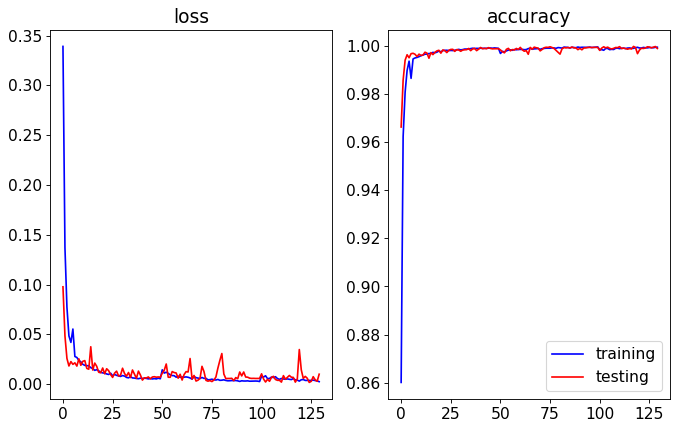

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.64it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


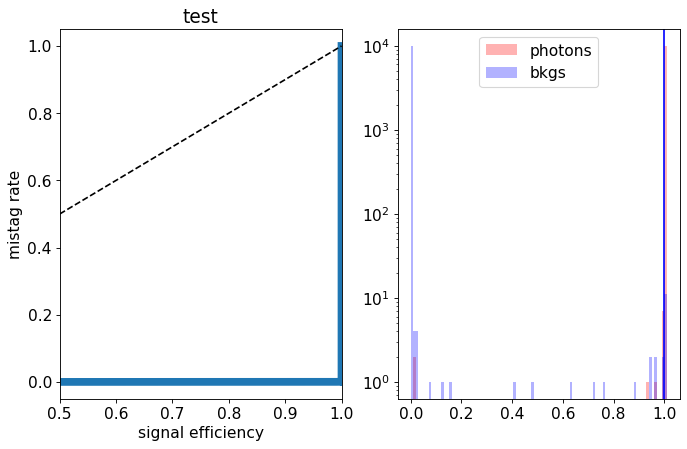

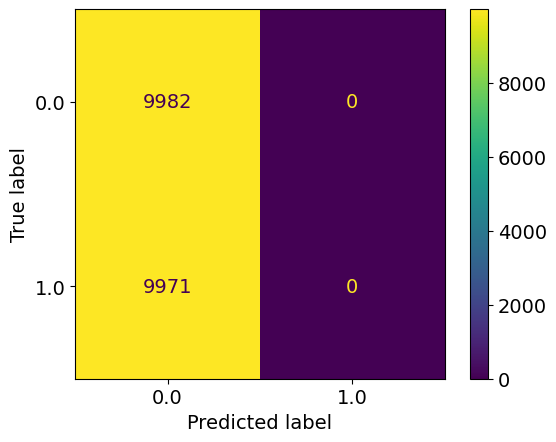

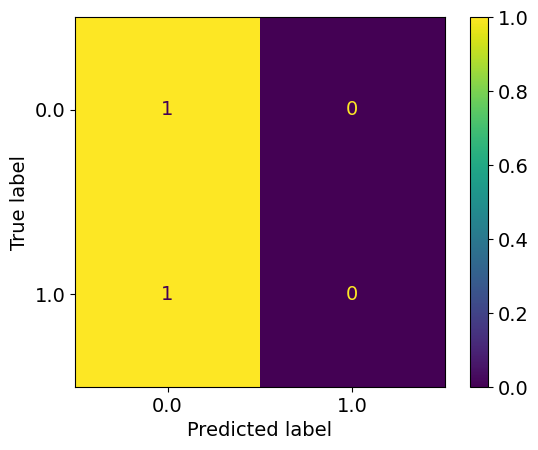

epoch: 130
Learning rate: 0.000345714492339235


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:30<00:00,  4.40it/s]


train loss: 0.0036062573496714483
train acc: 0.99911034


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.45it/s]


test loss: 0.004709444135338307
test acc: 0.99929833
epoch: 131
Learning rate: 0.0003161557273896083


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:28<00:00,  4.64it/s]


train loss: 0.002969283199436442
train acc: 0.9992357


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.46it/s]


test loss: 0.0012149594176809183
test acc: 0.9998496
new best acc: 0.9998496
epoch: 132
Learning rate: 0.0002873225117935158


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:29<00:00,  4.47it/s]


train loss: 0.002981679816214827
train acc: 0.9992231


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.48it/s]


test loss: 0.0028335445164131166
test acc: 0.99949884
epoch: 133
Learning rate: 0.0002593286370802722


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:28<00:00,  4.65it/s]


train loss: 0.0025718268038531916
train acc: 0.999386


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.55it/s]


test loss: 0.0029067343976143653
test acc: 0.9995489
epoch: 134
Learning rate: 0.0002322845822841862


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:29<00:00,  4.49it/s]


train loss: 0.002296068423125255
train acc: 0.9993985


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.68it/s]


test loss: 0.004045931628569346
test acc: 0.99934846
epoch: 135
Learning rate: 0.00020629707793428403


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:28<00:00,  4.65it/s]


train loss: 0.0025996740138785456
train acc: 0.9994236


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.63it/s]


test loss: 0.0026549495165385777
test acc: 0.9994487
epoch: 136
Learning rate: 0.00018146868483767353


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:29<00:00,  4.48it/s]


train loss: 0.002074157065267308
train acc: 0.99946123


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.69it/s]


test loss: 0.004742141961412982
test acc: 0.9994487
epoch: 137
Learning rate: 0.00015789738931889325


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:28<00:00,  4.69it/s]


train loss: 0.0022541433955707156
train acc: 0.99947375


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.67it/s]


test loss: 0.0064988950884095975
test acc: 0.99919814
epoch: 138
Learning rate: 0.00013567621651265532


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:29<00:00,  4.53it/s]


train loss: 0.002631639096200581
train acc: 0.999386


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.75it/s]


test loss: 0.0036748186634034444
test acc: 0.9993986
epoch: 139
Learning rate: 0.00011489286323613752


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:28<00:00,  4.70it/s]


train loss: 0.0023276168275067413
train acc: 0.9995489


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.65it/s]


test loss: 0.008910544350280328
test acc: 0.99904776


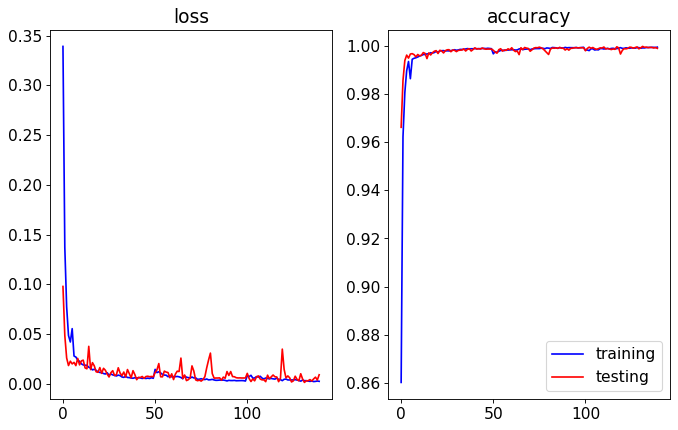

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00,  9.11it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


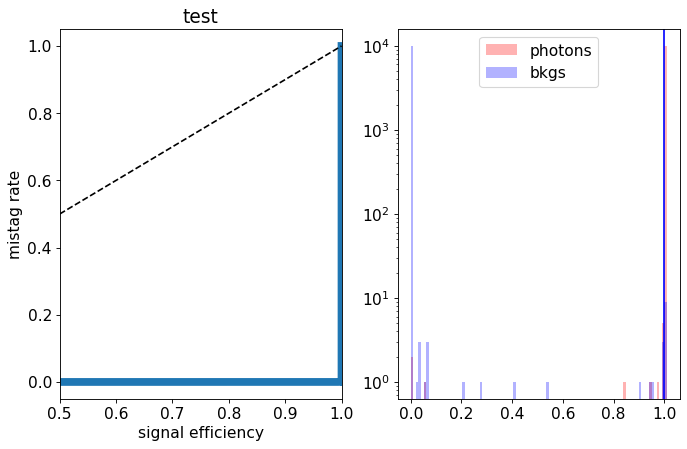

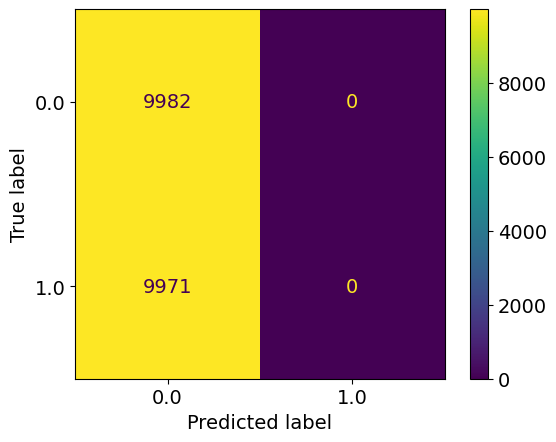

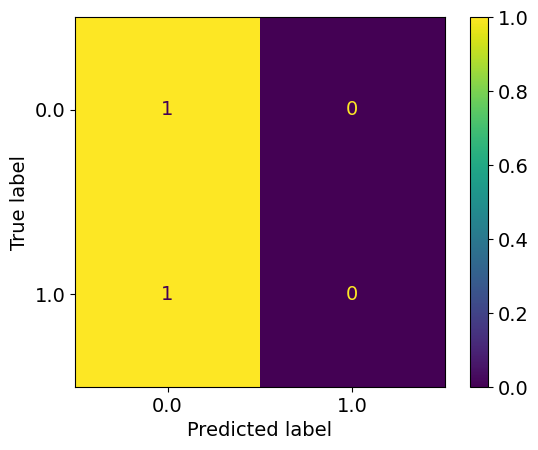

epoch: 140
Learning rate: 9.56293518897114e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:28<00:00,  4.70it/s]


train loss: 0.002459772630749312
train acc: 0.9993985


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.83it/s]


test loss: 0.00701331003491249
test acc: 0.99919814
epoch: 141
Learning rate: 7.79617067520002e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:29<00:00,  4.53it/s]


train loss: 0.0017941652814178228
train acc: 0.99961156


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.60it/s]


test loss: 0.006614799588341371
test acc: 0.9993986
epoch: 142
Learning rate: 6.195965394678321e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:28<00:00,  4.69it/s]


train loss: 0.0019342934876761713
train acc: 0.999574


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.63it/s]


test loss: 0.006087647712540386
test acc: 0.9992482
epoch: 143
Learning rate: 4.7686346265839844e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:29<00:00,  4.52it/s]


train loss: 0.0025564209699815133
train acc: 0.99943614


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.81it/s]


test loss: 0.0075266766853829175
test acc: 0.999148
epoch: 144
Learning rate: 3.5198113933733125e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:28<00:00,  4.71it/s]


train loss: 0.002618476820577883
train acc: 0.9993735


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.81it/s]


test loss: 0.006133972283601718
test acc: 0.9992482
epoch: 145
Learning rate: 2.4544242298147e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:29<00:00,  4.54it/s]


train loss: 0.002116747782782846
train acc: 0.99947375


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.71it/s]


test loss: 0.007409825266847055
test acc: 0.999148
epoch: 146
Learning rate: 1.5766777323136195e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:28<00:00,  4.69it/s]


train loss: 0.0024741597430400007
train acc: 0.9995239


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.70it/s]


test loss: 0.00773536277037495
test acc: 0.999148
epoch: 147
Learning rate: 8.900359652914802e-06


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:29<00:00,  4.52it/s]


train loss: 0.0026464355571296262
train acc: 0.9995239


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.60it/s]


test loss: 0.007452568821428287
test acc: 0.999148
epoch: 148
Learning rate: 3.972087901059351e-06


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:28<00:00,  4.66it/s]


train loss: 0.0021742966424399264
train acc: 0.99946123


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.49it/s]


test loss: 0.007353207750171048
test acc: 0.999148
epoch: 149
Learning rate: 1.0014117046611704e-06


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:29<00:00,  4.48it/s]


train loss: 0.0019260072487071087
train acc: 0.999574


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.49it/s]


test loss: 0.007304146297902098
test acc: 0.999148


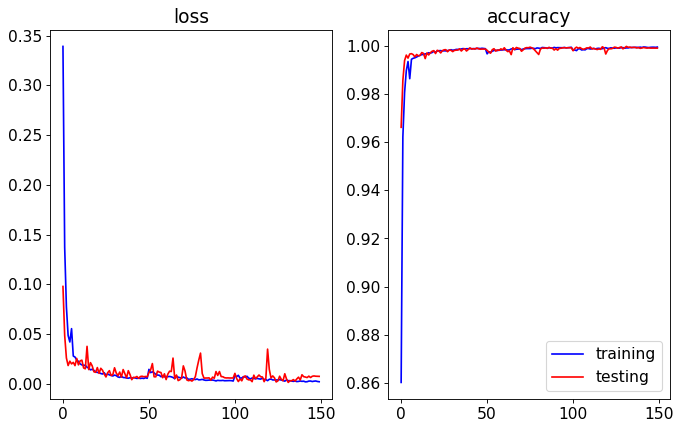

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.76it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


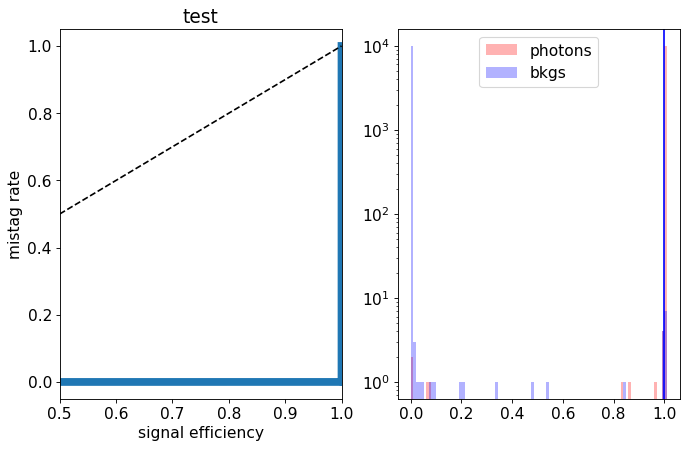

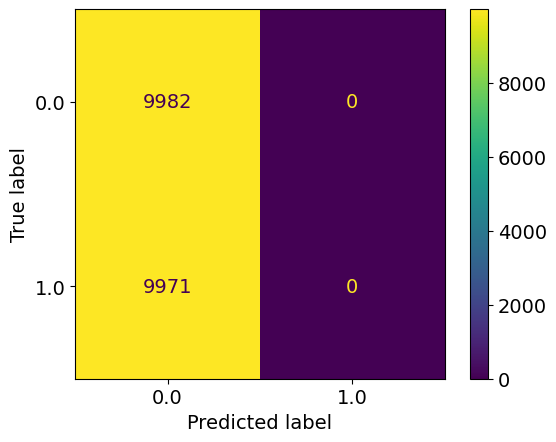

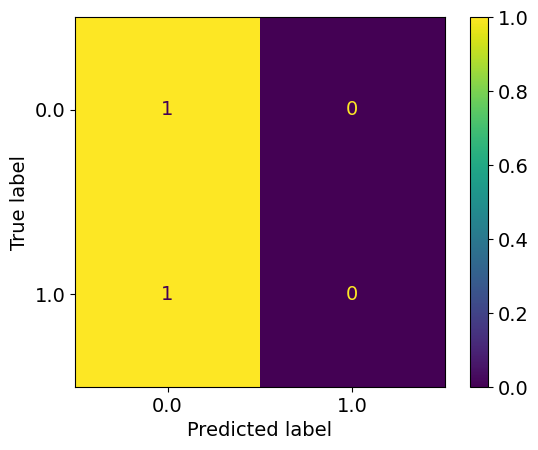

epoch: 150
Learning rate: 5.4965494655778717e-11


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:28<00:00,  4.68it/s]


train loss: 0.007307131902704367
train acc: 0.9983335


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00,  9.11it/s]


test loss: 0.016307435333882334
test acc: 0.997444
epoch: 151
Learning rate: 0.0009990280304188672


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:28<00:00,  4.69it/s]


train loss: 0.004463081994270315
train acc: 0.9988848


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.67it/s]


test loss: 0.0020187053350778183
test acc: 0.99959904
epoch: 152
Learning rate: 0.0009960866801513866


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:29<00:00,  4.52it/s]


train loss: 0.006076366398973285
train acc: 0.998772


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.82it/s]


test loss: 0.004216161682715083
test acc: 0.9994487
epoch: 153
Learning rate: 0.0009911875023977943


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:28<00:00,  4.70it/s]


train loss: 0.004524811348007338
train acc: 0.9988723


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.58it/s]


test loss: 0.009184361704716834
test acc: 0.9986969
epoch: 154
Learning rate: 0.0009843498319744622


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:29<00:00,  4.54it/s]


train loss: 0.005637293004295296
train acc: 0.9988723


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.65it/s]


test loss: 0.004724179290402684
test acc: 0.99949884
epoch: 155
Learning rate: 0.0009756006540427168


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:28<00:00,  4.71it/s]


train loss: 0.004502094553884748
train acc: 0.9990352


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.84it/s]


test loss: 0.007091770354906568
test acc: 0.999148
epoch: 156
Learning rate: 0.0009649744976107356


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:29<00:00,  4.54it/s]


train loss: 0.004330804676413467
train acc: 0.99899757


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.77it/s]


test loss: 0.0072687874473891115
test acc: 0.9987972
epoch: 157
Learning rate: 0.0009525132992633265


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:28<00:00,  4.70it/s]


train loss: 0.004645397272187482
train acc: 0.99896


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.81it/s]


test loss: 0.003318611829005182
test acc: 0.99934846
epoch: 158
Learning rate: 0.0009382662376573865


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:29<00:00,  4.53it/s]


train loss: 0.004252751848332367
train acc: 0.99901015


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.69it/s]


test loss: 0.006254701752804881
test acc: 0.9987972
epoch: 159
Learning rate: 0.0009222895394362112


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:28<00:00,  4.70it/s]


train loss: 0.0038814673242276473
train acc: 0.999173


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.82it/s]


test loss: 0.02114751885218378
test acc: 0.9972435


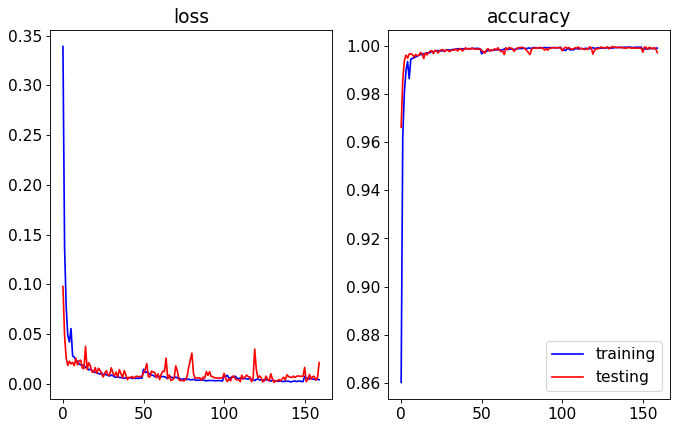

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.71it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


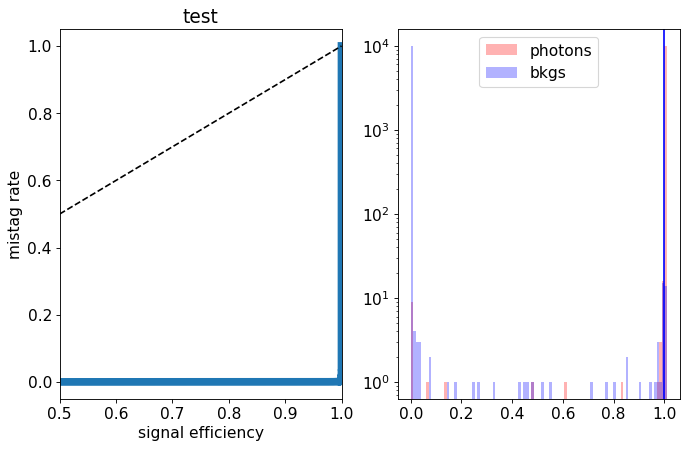

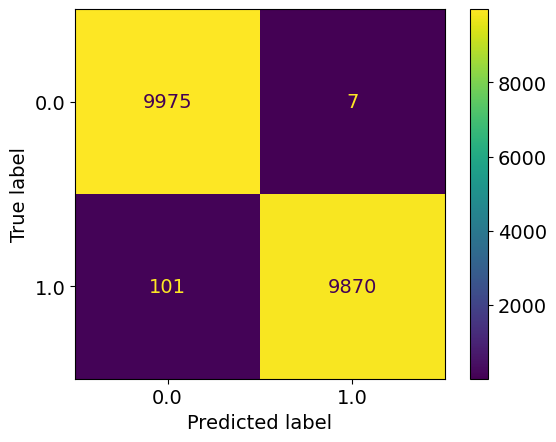

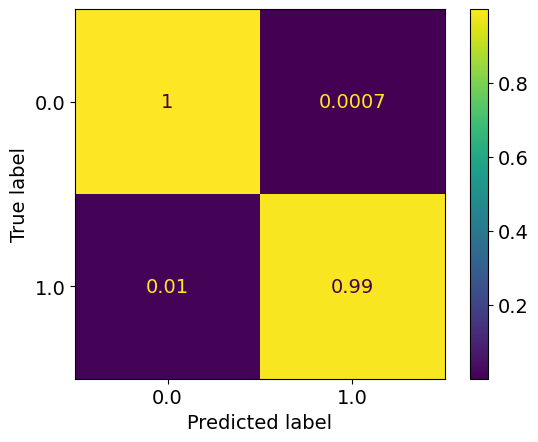

epoch: 160
Learning rate: 0.0009046462573286203


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:29<00:00,  4.53it/s]


train loss: 0.0045592956068585
train acc: 0.9990352


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.84it/s]


test loss: 0.008428524606833488
test acc: 0.9987972
epoch: 161
Learning rate: 0.0008854060213086437


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:28<00:00,  4.71it/s]


train loss: 0.0038374267686193167
train acc: 0.99916047


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00,  9.16it/s]


test loss: 0.0056499720375788095
test acc: 0.999148
epoch: 162
Learning rate: 0.0008646447637978243


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:28<00:00,  4.69it/s]


train loss: 0.0042860769072057565
train acc: 0.9990603


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.72it/s]


test loss: 0.003138284881109311
test acc: 0.9993986
epoch: 163
Learning rate: 0.0008424444199946415


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:28<00:00,  4.67it/s]


train loss: 0.0036004986926203475
train acc: 0.9990978


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00,  9.06it/s]


test loss: 0.003925396748202842
test acc: 0.999148
epoch: 164
Learning rate: 0.0008188926045137135


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:28<00:00,  4.65it/s]


train loss: 0.002982810586652351
train acc: 0.99928576


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.74it/s]


test loss: 0.00427945977450447
test acc: 0.99934846
epoch: 165
Learning rate: 0.0007940822656109428


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:29<00:00,  4.50it/s]


train loss: 0.002641035482020482
train acc: 0.99946123


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.73it/s]


test loss: 0.00295003716677751
test acc: 0.99934846
epoch: 166
Learning rate: 0.0007681113183592132


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:28<00:00,  4.66it/s]


train loss: 0.004280756736880537
train acc: 0.99911034


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.83it/s]


test loss: 0.0026585218106768738
test acc: 0.9995489
epoch: 167
Learning rate: 0.0007410822582223297


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:29<00:00,  4.54it/s]


train loss: 0.0029720020825390013
train acc: 0.9993735


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.67it/s]


test loss: 0.004577183997664804
test acc: 0.999148
epoch: 168
Learning rate: 0.0007131017565522497


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:28<00:00,  4.70it/s]


train loss: 0.0023987844476466473
train acc: 0.99948627


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.72it/s]


test loss: 0.008813174934743618
test acc: 0.9986468
epoch: 169
Learning rate: 0.00068428023960599


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:29<00:00,  4.53it/s]


train loss: 0.00310746743580307
train acc: 0.9992607


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.83it/s]


test loss: 0.0012611572970067228
test acc: 0.99979955


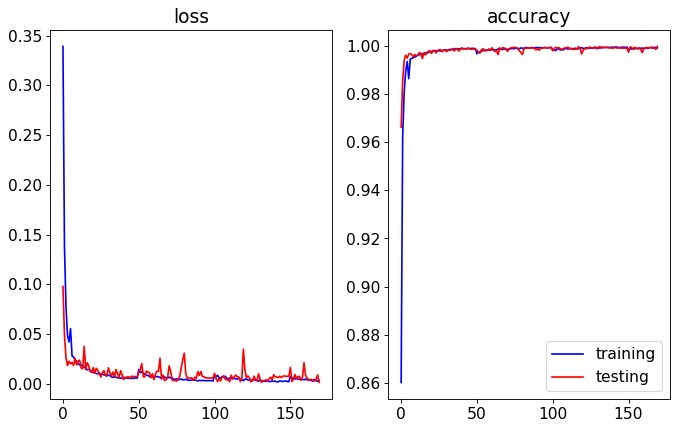

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.82it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


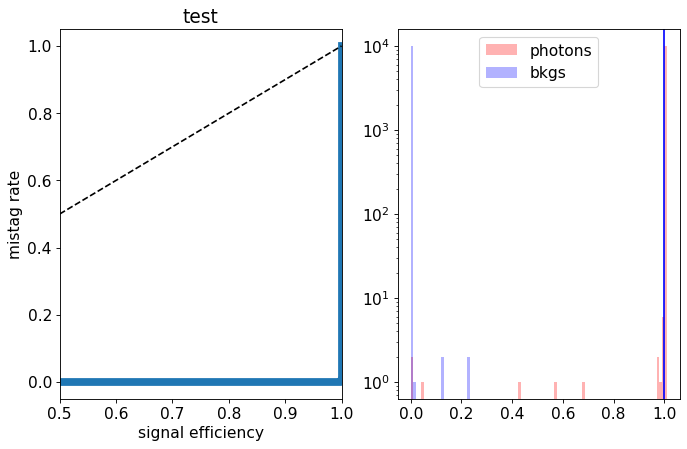

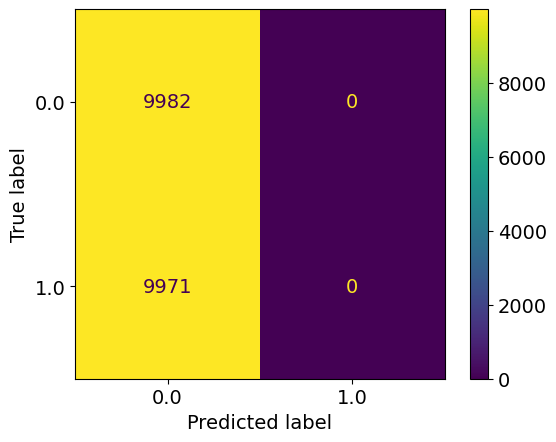

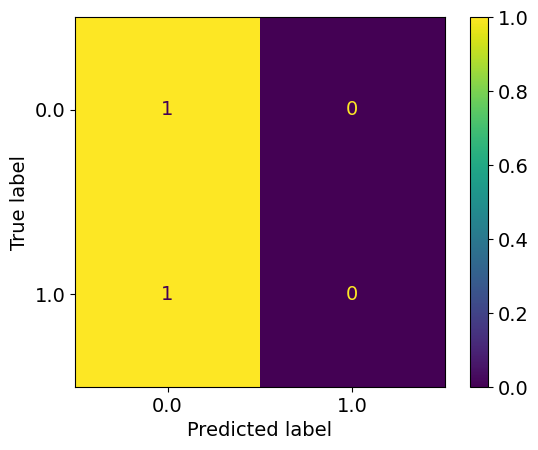

epoch: 170
Learning rate: 0.0006547314527436385


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:28<00:00,  4.70it/s]


train loss: 0.0030544138751911
train acc: 0.999173


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.77it/s]


test loss: 0.0019972544546856754
test acc: 0.99959904
epoch: 171
Learning rate: 0.0006245720115273845


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:29<00:00,  4.54it/s]


train loss: 0.002540940979033893
train acc: 0.9994988


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.82it/s]


test loss: 0.00444436305998487
test acc: 0.9993986
epoch: 172
Learning rate: 0.0005939209414931706


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:28<00:00,  4.70it/s]


train loss: 0.003577120689550951
train acc: 0.9992357


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.75it/s]


test loss: 0.0013116257371971066
test acc: 0.9997494
epoch: 173
Learning rate: 0.0005628992084112796


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:29<00:00,  4.54it/s]


train loss: 0.0029995480180698892
train acc: 0.9994111


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.75it/s]


test loss: 0.001544983193483546
test acc: 0.9995489
epoch: 174
Learning rate: 0.0005316292408897043


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:28<00:00,  4.70it/s]


train loss: 0.0045887310448391085
train acc: 0.9990477


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00,  9.25it/s]


test loss: 0.010254670100485608
test acc: 0.9986468
epoch: 175
Learning rate: 0.0005002344472043631


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:28<00:00,  4.71it/s]


train loss: 0.0025520297228882275
train acc: 0.9994236


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.74it/s]


test loss: 0.007834883378954563
test acc: 0.99904776
epoch: 176
Learning rate: 0.000468838728263015


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:28<00:00,  4.71it/s]


train loss: 0.002691097309929685
train acc: 0.9995113


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00,  9.16it/s]


test loss: 0.004171863650659913
test acc: 0.99929833
epoch: 177
Learning rate: 0.0004375659886249818


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:28<00:00,  4.72it/s]


train loss: 0.0023908127216451087
train acc: 0.9994988


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 13.01it/s]


test loss: 0.00443290138099238
test acc: 0.9990979
epoch: 178
Learning rate: 0.0004065396475064592


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:29<00:00,  4.56it/s]


train loss: 0.002646789949423366
train acc: 0.9993985


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.79it/s]


test loss: 0.005001906057532355
test acc: 0.9992482
epoch: 179
Learning rate: 0.000375882151701255


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:28<00:00,  4.72it/s]


train loss: 0.0023095952093076925
train acc: 0.9994236


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.82it/s]


test loss: 0.0041656456309623535
test acc: 0.99919814


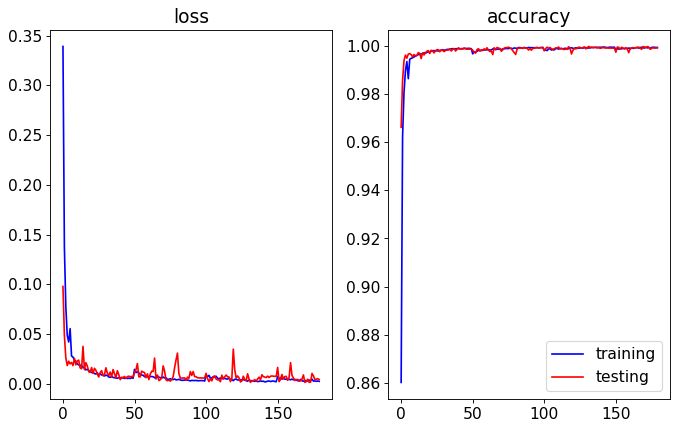

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.75it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


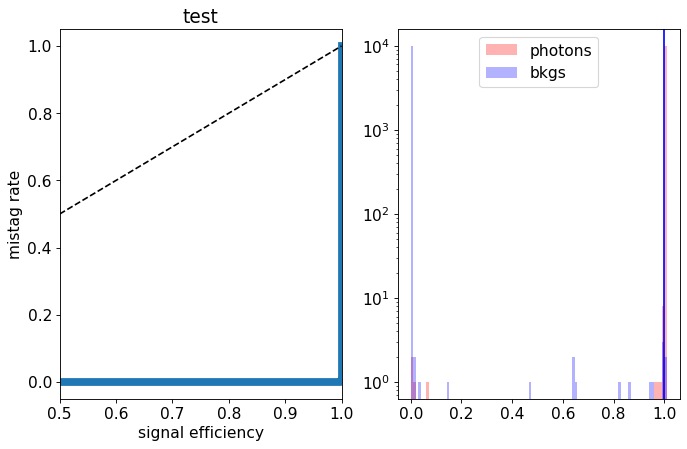

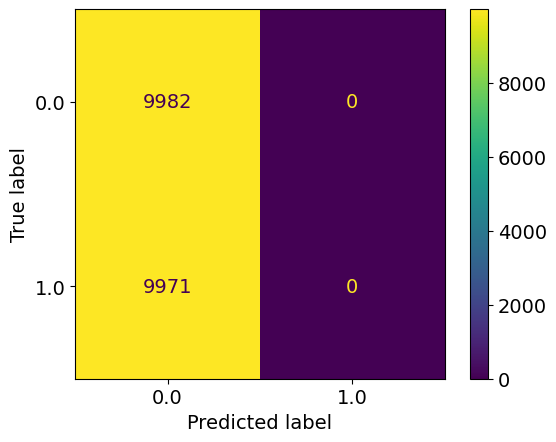

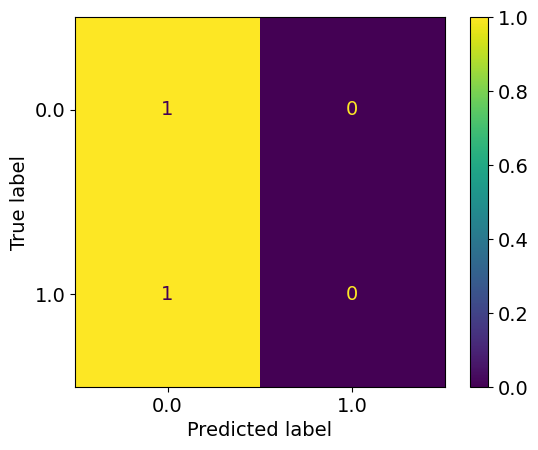

epoch: 180
Learning rate: 0.000345714492339235


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:29<00:00,  4.54it/s]


train loss: 0.002251847026692182
train acc: 0.9995865


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.84it/s]


test loss: 0.008814988230590322
test acc: 0.9985466
epoch: 181
Learning rate: 0.0003161557273896083


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:28<00:00,  4.71it/s]


train loss: 0.0021740014737635866
train acc: 0.9995614


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.80it/s]


test loss: 0.005243719225704677
test acc: 0.99919814
epoch: 182
Learning rate: 0.0002873225117935158


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:29<00:00,  4.55it/s]


train loss: 0.00261408597106677
train acc: 0.9994111


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.77it/s]


test loss: 0.007316418432169236
test acc: 0.9989976
epoch: 183
Learning rate: 0.0002593286370802722


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:28<00:00,  4.71it/s]


train loss: 0.0021412661548308462
train acc: 0.99947375


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.71it/s]


test loss: 0.0075018629235177195
test acc: 0.99874705
epoch: 184
Learning rate: 0.0002322845822841862


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:29<00:00,  4.54it/s]


train loss: 0.0018329938432530138
train acc: 0.9996617


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.81it/s]


test loss: 0.0026660690129735255
test acc: 0.99949884
epoch: 185
Learning rate: 0.00020629707793428403


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:28<00:00,  4.71it/s]


train loss: 0.002570546249485029
train acc: 0.99947375


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00,  9.27it/s]


test loss: 0.0023985763588044717
test acc: 0.99959904
epoch: 186
Learning rate: 0.00018146868483767353


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:28<00:00,  4.71it/s]


train loss: 0.002112354960350351
train acc: 0.9995239


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.76it/s]


test loss: 0.004865110098063099
test acc: 0.9993986
epoch: 187
Learning rate: 0.00015789738931889325


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:28<00:00,  4.71it/s]


train loss: 0.0022333929838481057
train acc: 0.999574


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00,  9.26it/s]


test loss: 0.019232955933786097
test acc: 0.9979452
epoch: 188
Learning rate: 0.00013567621651265532


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:28<00:00,  4.71it/s]


train loss: 0.002449104602965914
train acc: 0.9994236


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.85it/s]


test loss: 0.006372351281452846
test acc: 0.9990979
epoch: 189
Learning rate: 0.00011489286323613752


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:29<00:00,  4.54it/s]


train loss: 0.002177979682596403
train acc: 0.99947375


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.59it/s]


test loss: 0.004319481658353843
test acc: 0.999148


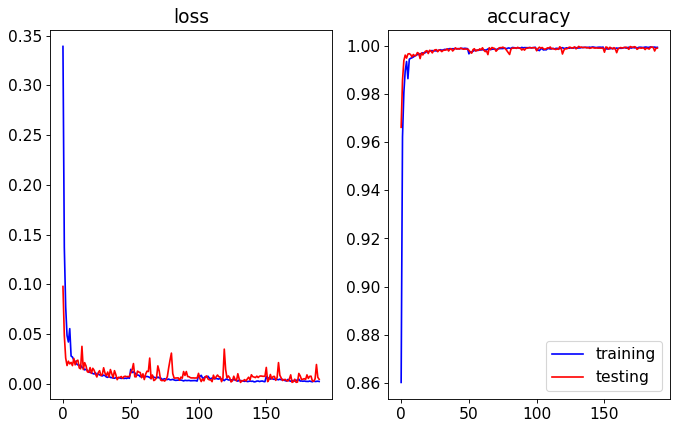

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.64it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


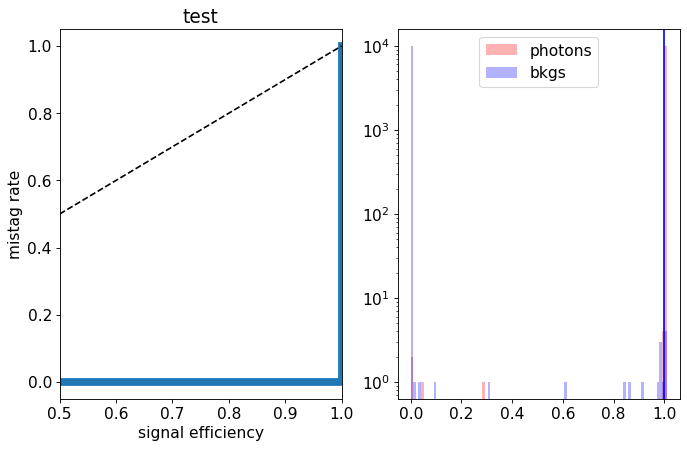

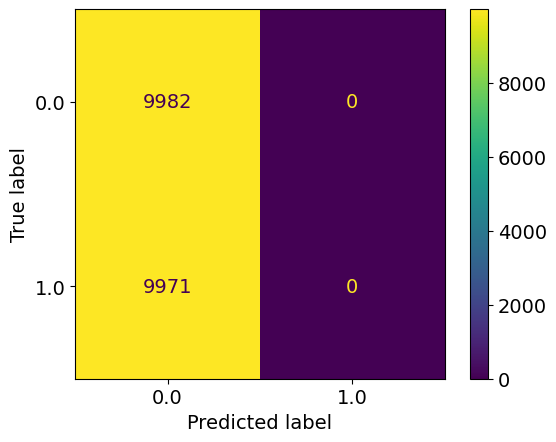

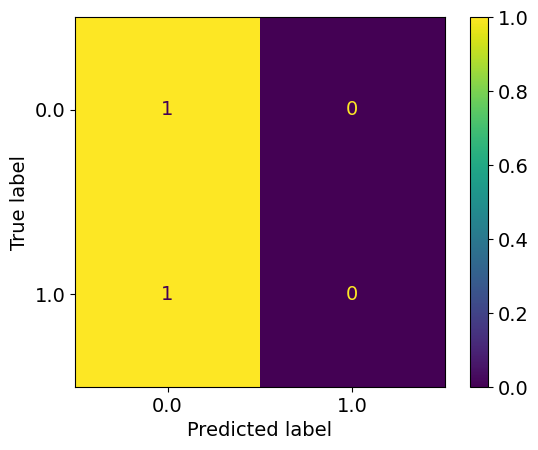

epoch: 190
Learning rate: 9.56293518897114e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:28<00:00,  4.72it/s]


train loss: 0.0020667047294355414
train acc: 0.99947375


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.76it/s]


test loss: 0.002421524680734787
test acc: 0.9995489
epoch: 191
Learning rate: 7.79617067520002e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:29<00:00,  4.53it/s]


train loss: 0.002214176973447437
train acc: 0.9995239


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.71it/s]


test loss: 0.0034605604133142796
test acc: 0.99934846
epoch: 192
Learning rate: 6.195965394678321e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:28<00:00,  4.71it/s]


train loss: 0.001420652288288693
train acc: 0.99976194


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.67it/s]


test loss: 0.0040185764380356054
test acc: 0.99934846
epoch: 193
Learning rate: 4.7686346265839844e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:29<00:00,  4.53it/s]


train loss: 0.0014612299821047641
train acc: 0.9996742


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.65it/s]


test loss: 0.003603426928239568
test acc: 0.9993986
epoch: 194
Learning rate: 3.5198113933733125e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:28<00:00,  4.69it/s]


train loss: 0.0017311723493738968
train acc: 0.99964917


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.85it/s]


test loss: 0.004312307724654165
test acc: 0.9993986
epoch: 195
Learning rate: 2.4544242298147e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:29<00:00,  4.54it/s]


train loss: 0.001984973383432996
train acc: 0.99964917


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.83it/s]


test loss: 0.00523285115182167
test acc: 0.9990979
epoch: 196
Learning rate: 1.5766777323136195e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:28<00:00,  4.71it/s]


train loss: 0.0017201352275151294
train acc: 0.99963665


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00,  9.13it/s]


test loss: 0.005215905455794072
test acc: 0.99919814
epoch: 197
Learning rate: 8.900359652914802e-06


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:28<00:00,  4.72it/s]


train loss: 0.0016536788639271761
train acc: 0.9995489


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.75it/s]


test loss: 0.004652197034986022
test acc: 0.99929833
epoch: 198
Learning rate: 3.972087901059351e-06


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:28<00:00,  4.71it/s]


train loss: 0.0017126186511048408
train acc: 0.9996617


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00,  9.17it/s]


test loss: 0.004853272786944087
test acc: 0.9992482
epoch: 199
Learning rate: 1.0014117046611704e-06


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:28<00:00,  4.71it/s]


train loss: 0.0017943997945948597
train acc: 0.9996241


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.76it/s]


test loss: 0.004958925976728486
test acc: 0.9992482


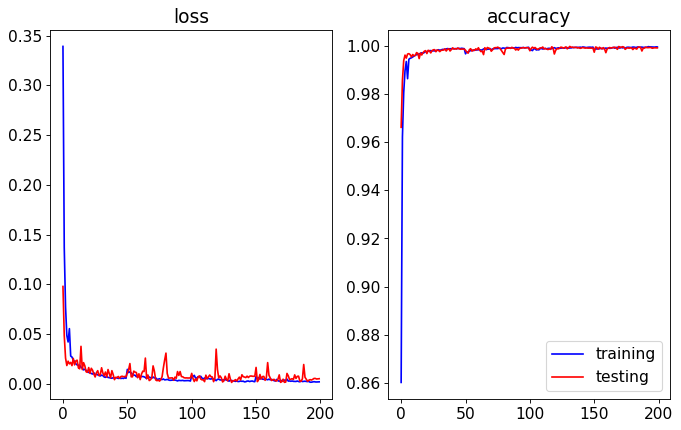

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.77it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


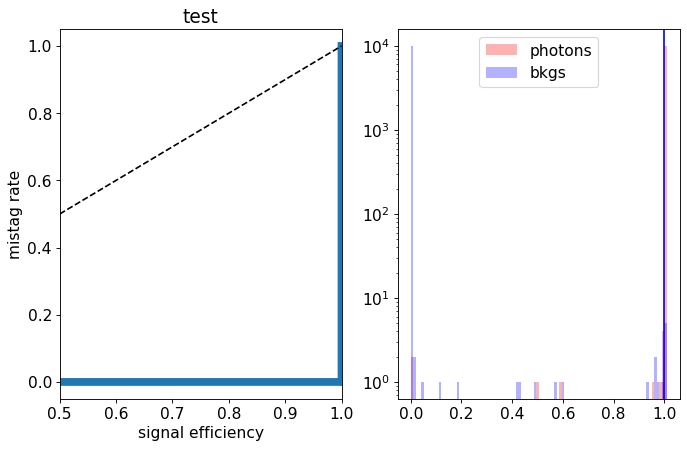

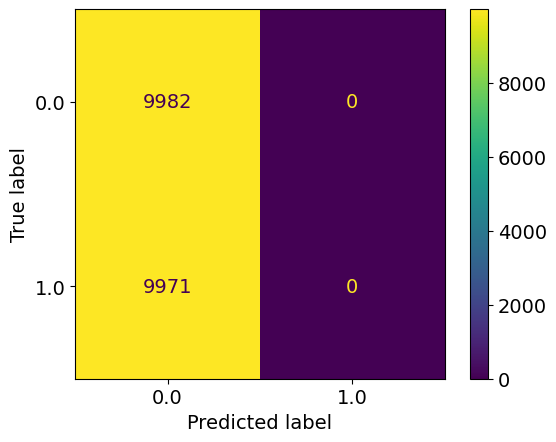

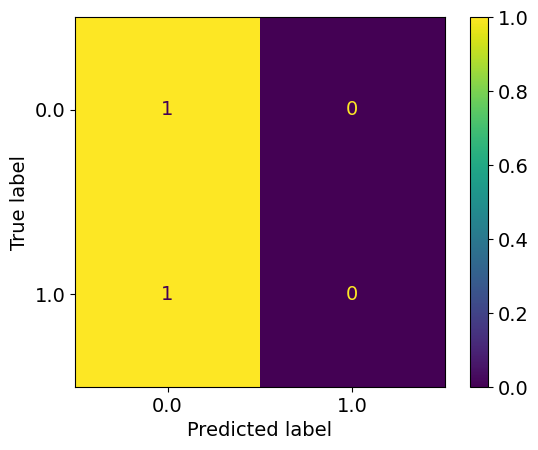

epoch: 200
Learning rate: 5.4965494655778717e-11


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:29<00:00,  4.54it/s]


train loss: 0.0077008345755421575
train acc: 0.9983335


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.76it/s]


test loss: 0.00267909302653426
test acc: 0.9994487
epoch: 201
Learning rate: 0.0009990280304188672


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:28<00:00,  4.71it/s]


train loss: 0.005005303267285283
train acc: 0.9987846


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.78it/s]


test loss: 0.014146889220866984
test acc: 0.99784493
epoch: 202
Learning rate: 0.0009960866801513866


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:29<00:00,  4.55it/s]


train loss: 0.00506957392633976
train acc: 0.998772


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.85it/s]


test loss: 0.0043343067073878085
test acc: 0.9990979
epoch: 203
Learning rate: 0.0009911875023977943


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:28<00:00,  4.70it/s]


train loss: 0.004782777321750799
train acc: 0.99896


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.75it/s]


test loss: 0.001697987947769143
test acc: 0.99959904
epoch: 204
Learning rate: 0.0009843498319744622


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:29<00:00,  4.55it/s]


train loss: 0.003957199905037113
train acc: 0.99911034


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.61it/s]


test loss: 0.0026070527036996397
test acc: 0.99949884
epoch: 205
Learning rate: 0.0009756006540427168


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:28<00:00,  4.70it/s]


train loss: 0.003845455506256149
train acc: 0.99918556


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.72it/s]


test loss: 0.00660279010016563
test acc: 0.99889743
epoch: 206
Learning rate: 0.0009649744976107356


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:29<00:00,  4.53it/s]


train loss: 0.004200267323350131
train acc: 0.9990728


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.61it/s]


test loss: 0.003569564168902208
test acc: 0.99919814
epoch: 207
Learning rate: 0.0009525132992633265


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:28<00:00,  4.70it/s]


train loss: 0.0035350750120740674
train acc: 0.99918556


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00,  9.22it/s]


test loss: 0.002777672245891832
test acc: 0.9994487
epoch: 208
Learning rate: 0.0009382662376573865


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:28<00:00,  4.70it/s]


train loss: 0.004369586407195658
train acc: 0.99898505


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.73it/s]


test loss: 0.00513299885065072
test acc: 0.9990979
epoch: 209
Learning rate: 0.0009222895394362112


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:28<00:00,  4.70it/s]


train loss: 0.013990876858457993
train acc: 0.99929833


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00,  9.23it/s]


test loss: 0.0013769182245402375
test acc: 0.99964917


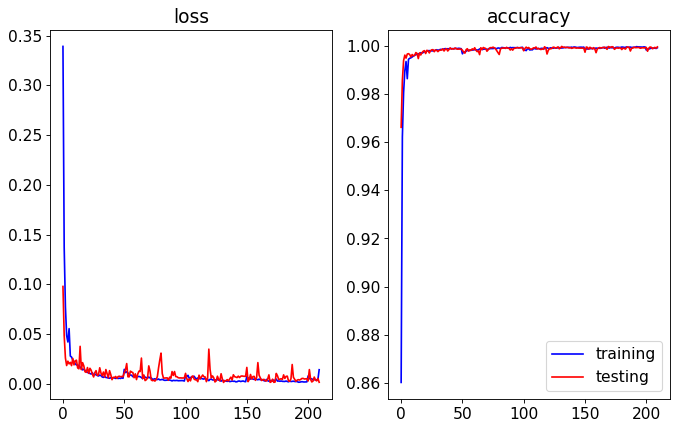

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.81it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


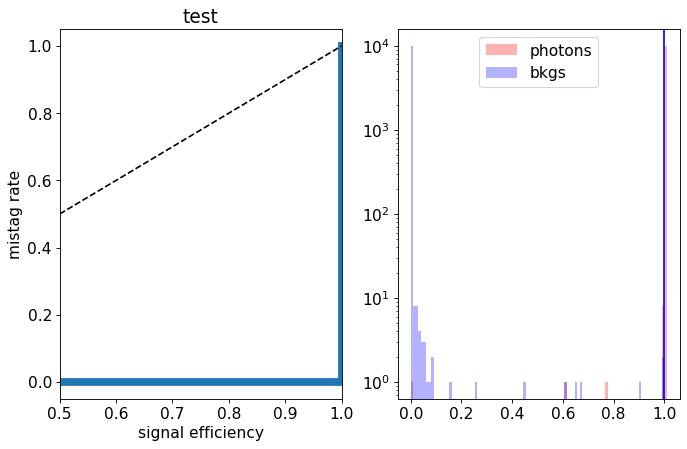

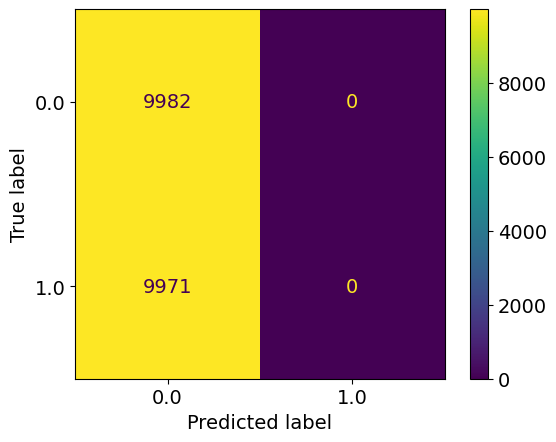

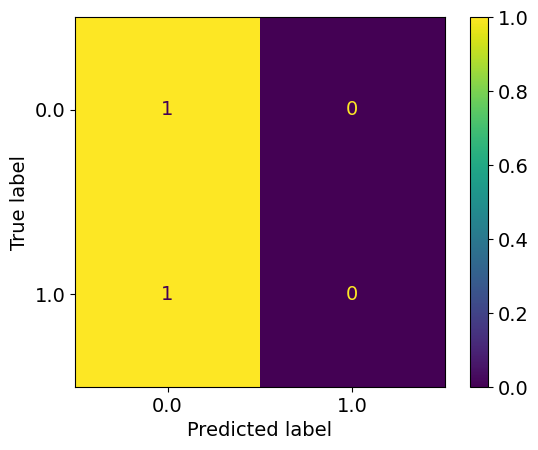

epoch: 210
Learning rate: 0.0009046462573286203


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:28<00:00,  4.71it/s]


train loss: 0.013404518161372997
train acc: 0.9967672


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.72it/s]


test loss: 0.005315429306151868
test acc: 0.99919814
epoch: 211
Learning rate: 0.0008854060213086437


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:29<00:00,  4.54it/s]


train loss: 0.006116966147031357
train acc: 0.99885976


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.81it/s]


test loss: 0.017640096208009815
test acc: 0.99784493
epoch: 212
Learning rate: 0.0008646447637978243


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:28<00:00,  4.69it/s]


train loss: 0.02106449511093296
train acc: 0.99620336


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.62it/s]


test loss: 0.004706714150813696
test acc: 0.9990979
epoch: 213
Learning rate: 0.0008424444199946415


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:29<00:00,  4.55it/s]


train loss: 0.006013506854043356
train acc: 0.9988723


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.74it/s]


test loss: 0.0065654436730289275
test acc: 0.99889743
epoch: 214
Learning rate: 0.0008188926045137135


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:28<00:00,  4.70it/s]


train loss: 0.004577245966704222
train acc: 0.9990352


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.77it/s]


test loss: 0.006263432879204219
test acc: 0.99904776
epoch: 215
Learning rate: 0.0007940822656109428


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:29<00:00,  4.53it/s]


train loss: 0.003725482649148669
train acc: 0.9990728


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.68it/s]


test loss: 0.004181099876457369
test acc: 0.9990979
epoch: 216
Learning rate: 0.0007681113183592132


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:28<00:00,  4.71it/s]


train loss: 0.0036869042709603587
train acc: 0.9992607


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.90it/s]


test loss: 0.002120078659142981
test acc: 0.9994487
epoch: 217
Learning rate: 0.0007410822582223297


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:29<00:00,  4.55it/s]


train loss: 0.003622297507623009
train acc: 0.99928576


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.86it/s]


test loss: 0.002355706122727952
test acc: 0.99929833
epoch: 218
Learning rate: 0.0007131017565522497


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:28<00:00,  4.73it/s]


train loss: 0.0034760515210048503
train acc: 0.99918556


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.88it/s]


test loss: 0.004887785155142661
test acc: 0.9989475
epoch: 219
Learning rate: 0.00068428023960599


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:29<00:00,  4.55it/s]


train loss: 0.00291170915464934
train acc: 0.999386


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.89it/s]


test loss: 0.0066358426513730565
test acc: 0.9985466


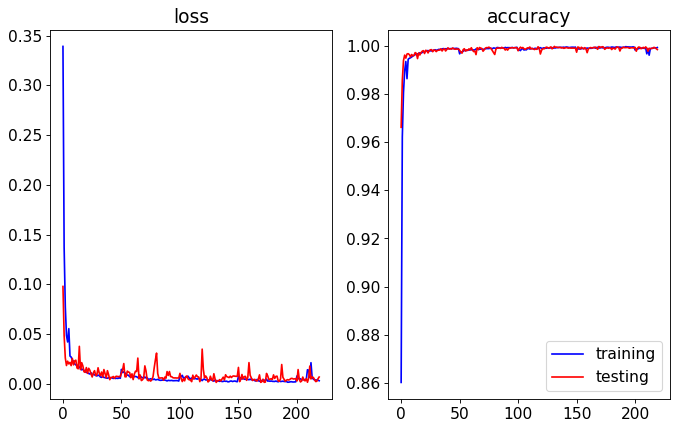

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 13.02it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


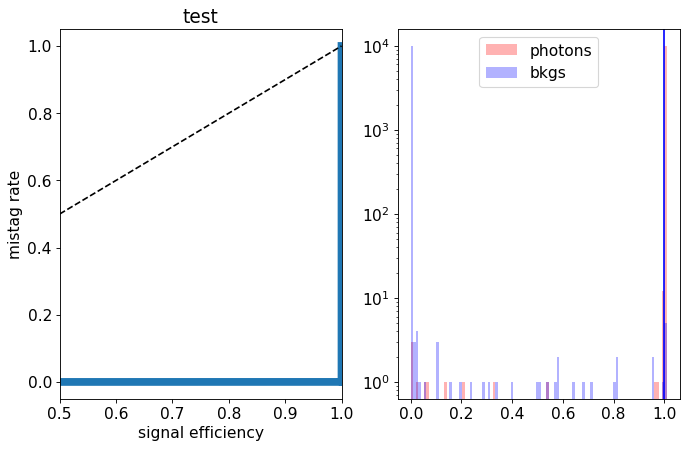

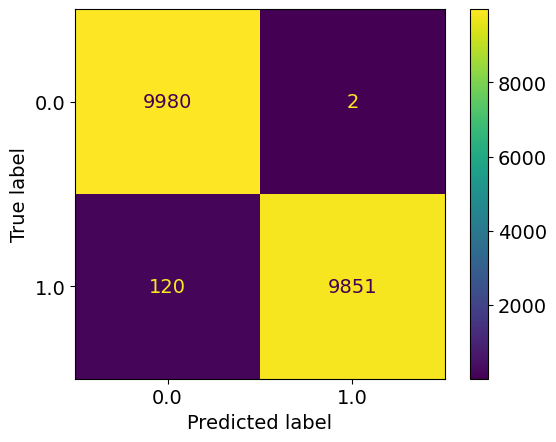

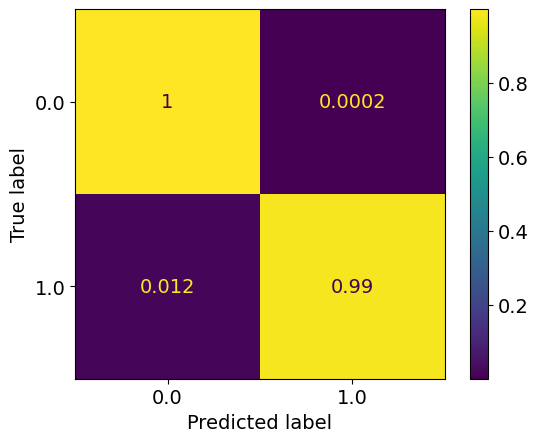

epoch: 220
Learning rate: 0.0006547314527436385


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:29<00:00,  4.58it/s]


train loss: 0.0037170580895311126
train acc: 0.9992106


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.69it/s]


test loss: 0.002075354648162677
test acc: 0.99929833
epoch: 221
Learning rate: 0.0006245720115273845


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:28<00:00,  4.71it/s]


train loss: 0.0027419224821445443
train acc: 0.999361


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.74it/s]


test loss: 0.0026944554311816304
test acc: 0.999148
epoch: 222
Learning rate: 0.0005939209414931706


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:29<00:00,  4.54it/s]


train loss: 0.003169216708744131
train acc: 0.9991981


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.83it/s]


test loss: 0.0044466020633640154
test acc: 0.9990979
epoch: 223
Learning rate: 0.0005628992084112796


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:28<00:00,  4.71it/s]


train loss: 0.002571564108444336
train acc: 0.9994111


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.81it/s]


test loss: 0.004049901711846611
test acc: 0.99929833
epoch: 224
Learning rate: 0.0005316292408897043


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:29<00:00,  4.54it/s]


train loss: 0.0027126046129625995
train acc: 0.99928576


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.75it/s]


test loss: 0.002226140454361941
test acc: 0.99949884
epoch: 225
Learning rate: 0.0005002344472043631


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:28<00:00,  4.71it/s]


train loss: 0.0025123510793410284
train acc: 0.9995489


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.68it/s]


test loss: 0.0033576831517029607
test acc: 0.99929833
epoch: 226
Learning rate: 0.000468838728263015


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:29<00:00,  4.52it/s]


train loss: 0.0027218363234780226
train acc: 0.99944866


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.77it/s]


test loss: 0.0021173030749546
test acc: 0.9994487
epoch: 227
Learning rate: 0.0004375659886249818


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:28<00:00,  4.70it/s]


train loss: 0.002286395935386023
train acc: 0.99947375


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.67it/s]


test loss: 0.003486712733103303
test acc: 0.99929833
epoch: 228
Learning rate: 0.0004065396475064592


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:29<00:00,  4.54it/s]


train loss: 0.0024542883346391556
train acc: 0.9995113


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.81it/s]


test loss: 0.0025875195880278833
test acc: 0.99959904
epoch: 229
Learning rate: 0.000375882151701255


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:28<00:00,  4.72it/s]


train loss: 0.0024126062993700408
train acc: 0.9995489


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.85it/s]


test loss: 0.002639630438143408
test acc: 0.99949884


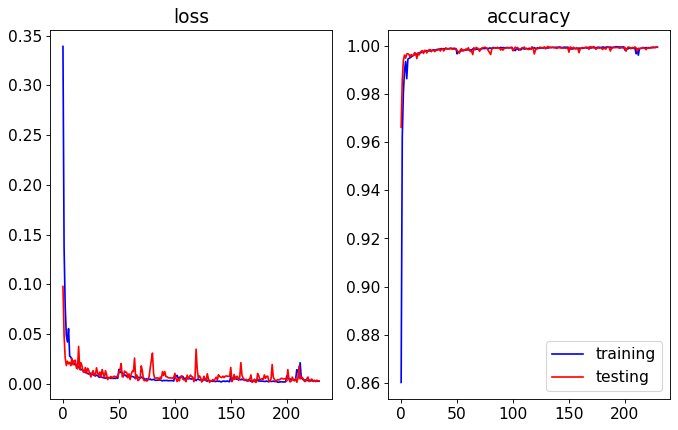

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00,  9.28it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


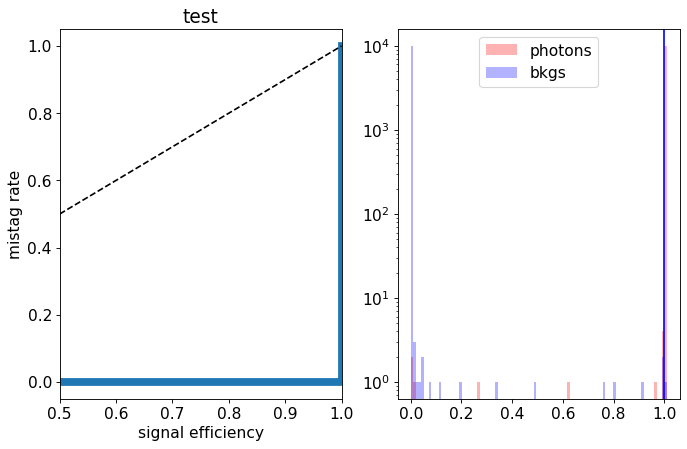

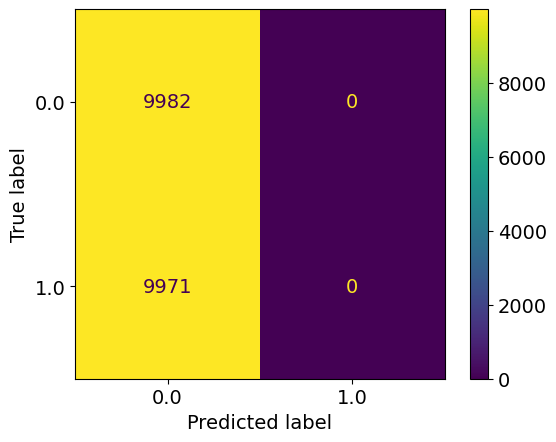

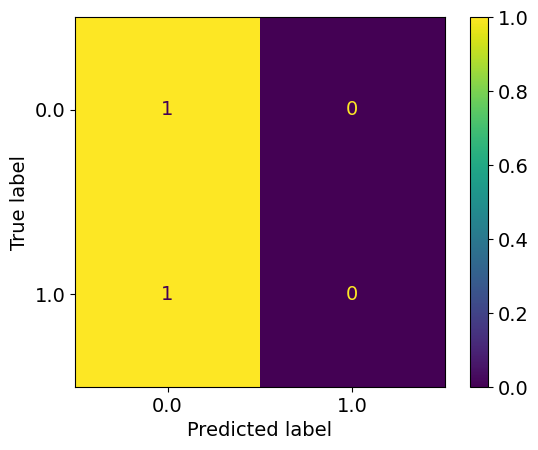

epoch: 230
Learning rate: 0.000345714492339235


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:28<00:00,  4.70it/s]


train loss: 0.0024867585639524927
train acc: 0.99944866


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.80it/s]


test loss: 0.003357970853544122
test acc: 0.99919814
epoch: 231
Learning rate: 0.0003161557273896083


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:29<00:00,  4.54it/s]


train loss: 0.002763333445008263
train acc: 0.9995239


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.78it/s]


test loss: 0.0026031924845365995
test acc: 0.9994487
epoch: 232
Learning rate: 0.0002873225117935158


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:28<00:00,  4.71it/s]


train loss: 0.002419630296971596
train acc: 0.9994988


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.76it/s]


test loss: 0.0025272039194417883
test acc: 0.99934846
epoch: 233
Learning rate: 0.0002593286370802722


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:29<00:00,  4.54it/s]


train loss: 0.002240421230317903
train acc: 0.9995364


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.76it/s]


test loss: 0.0017276324118287037
test acc: 0.99949884
epoch: 234
Learning rate: 0.0002322845822841862


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:28<00:00,  4.71it/s]


train loss: 0.002059616972282504
train acc: 0.9995364


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.65it/s]


test loss: 0.003776243529357322
test acc: 0.99929833
epoch: 235
Learning rate: 0.00020629707793428403


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:29<00:00,  4.53it/s]


train loss: 0.002434968479840438
train acc: 0.9995113


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.82it/s]


test loss: 0.005358345793463027
test acc: 0.99889743
epoch: 236
Learning rate: 0.00018146868483767353


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:28<00:00,  4.69it/s]


train loss: 0.0019103526512087377
train acc: 0.9995614


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.69it/s]


test loss: 0.004822009421312305
test acc: 0.99934846
epoch: 237
Learning rate: 0.00015789738931889325


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:29<00:00,  4.54it/s]


train loss: 0.0021611396887373535
train acc: 0.9995364


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.82it/s]


test loss: 0.0035016061577478543
test acc: 0.9992482
epoch: 238
Learning rate: 0.00013567621651265532


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:28<00:00,  4.71it/s]


train loss: 0.0019623848652847655
train acc: 0.9996241


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.80it/s]


test loss: 0.003200193127580046
test acc: 0.9992482
epoch: 239
Learning rate: 0.00011489286323613752


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:29<00:00,  4.55it/s]


train loss: 0.0018920073557900814
train acc: 0.9995614


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.81it/s]


test loss: 0.004849968062448633
test acc: 0.999148


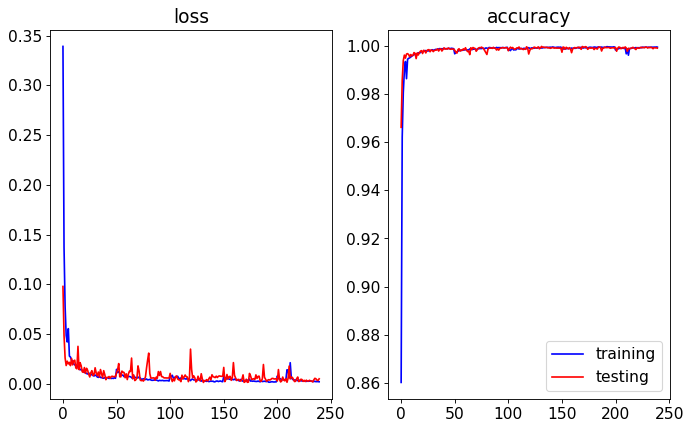

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.83it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


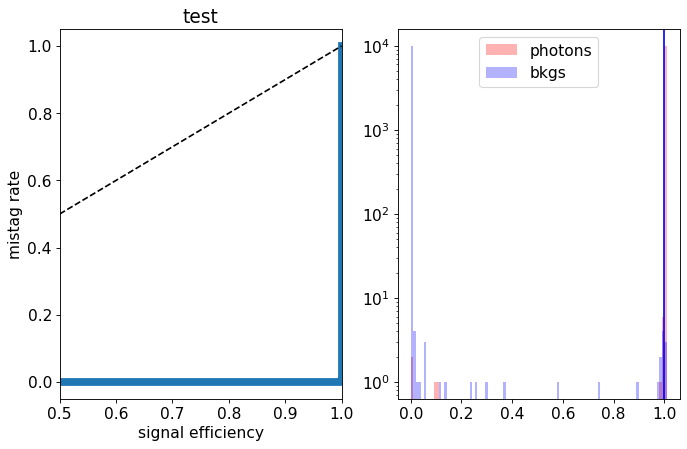

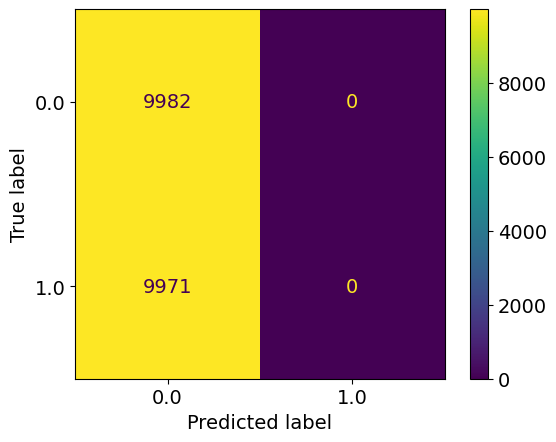

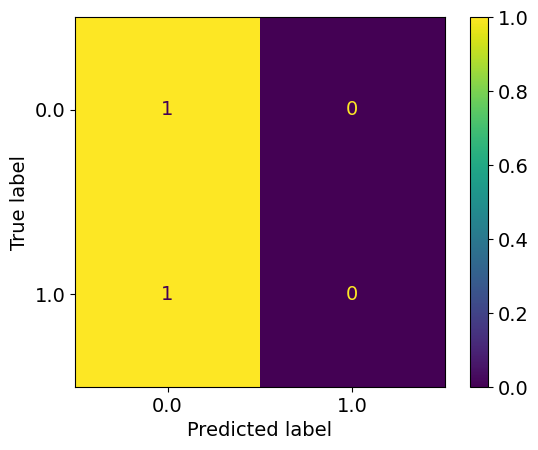

epoch: 240
Learning rate: 9.56293518897114e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:28<00:00,  4.71it/s]


train loss: 0.0018018476739191317
train acc: 0.9995865


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00,  9.27it/s]


test loss: 0.007156799579648615
test acc: 0.9989475
epoch: 241
Learning rate: 7.79617067520002e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:28<00:00,  4.71it/s]


train loss: 0.002004431180018821
train acc: 0.9995614


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.80it/s]


test loss: 0.0037515604071585032
test acc: 0.99929833
epoch: 242
Learning rate: 6.195965394678321e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:29<00:00,  4.54it/s]


train loss: 0.0023438508625389007
train acc: 0.9994988


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.73it/s]


test loss: 0.00304640740214914
test acc: 0.99929833
epoch: 243
Learning rate: 4.7686346265839844e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:28<00:00,  4.71it/s]


train loss: 0.0016535171301693006
train acc: 0.99961156


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.79it/s]


test loss: 0.003714448990917669
test acc: 0.9992482
epoch: 244
Learning rate: 3.5198113933733125e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:29<00:00,  4.59it/s]


train loss: 0.0017197858035598599
train acc: 0.99973685


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 13.11it/s]


test loss: 0.003783647144542451
test acc: 0.9992482
epoch: 245
Learning rate: 2.4544242298147e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:27<00:00,  4.81it/s]


train loss: 0.0016539818430530105
train acc: 0.99964917


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.78it/s]


test loss: 0.0035244627889471423
test acc: 0.99929833
epoch: 246
Learning rate: 1.5766777323136195e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:29<00:00,  4.55it/s]


train loss: 0.0015541290851327876
train acc: 0.9996742


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.78it/s]


test loss: 0.0036566775806731898
test acc: 0.99929833
epoch: 247
Learning rate: 8.900359652914802e-06


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:28<00:00,  4.70it/s]


train loss: 0.0016730341069602667
train acc: 0.9995113


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.93it/s]


test loss: 0.003571164407271389
test acc: 0.99929833
epoch: 248
Learning rate: 3.972087901059351e-06


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:29<00:00,  4.55it/s]


train loss: 0.0017154394352663944
train acc: 0.99964917


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.78it/s]


test loss: 0.0035565011983586035
test acc: 0.99929833
epoch: 249
Learning rate: 1.0014117046611704e-06


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:28<00:00,  4.71it/s]


train loss: 0.0015726035185863695
train acc: 0.9995865


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.78it/s]


test loss: 0.004141595874023263
test acc: 0.99929833


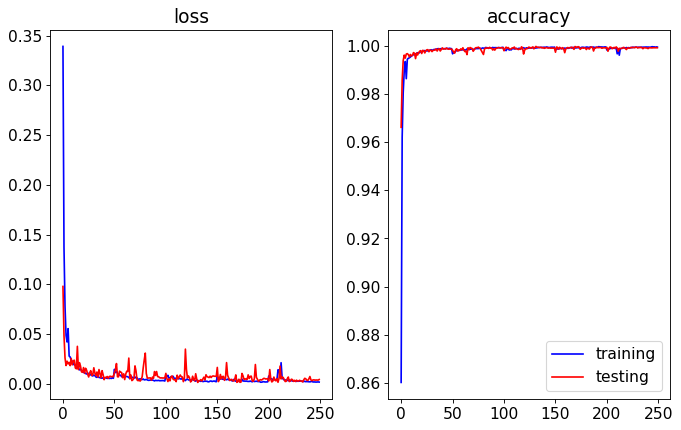

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.81it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


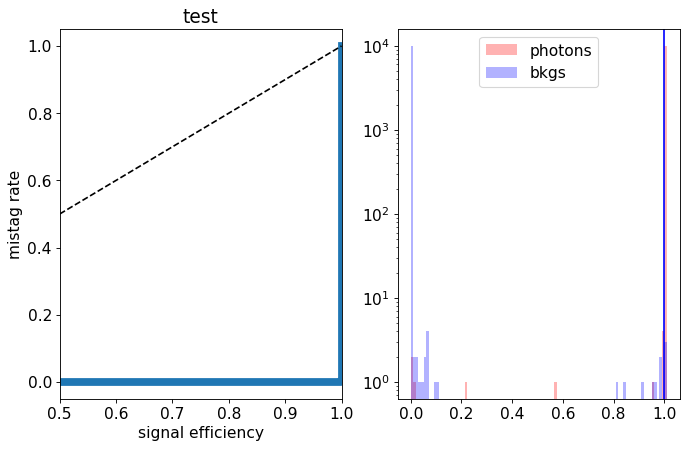

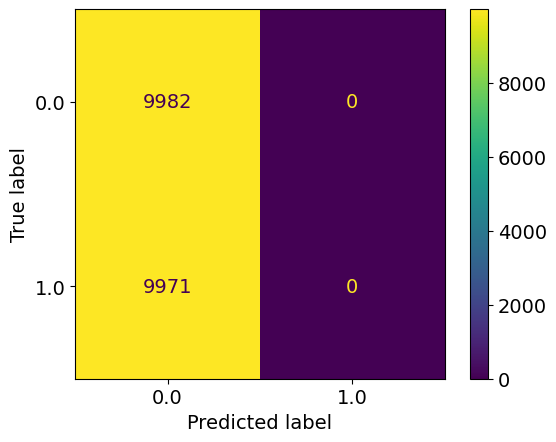

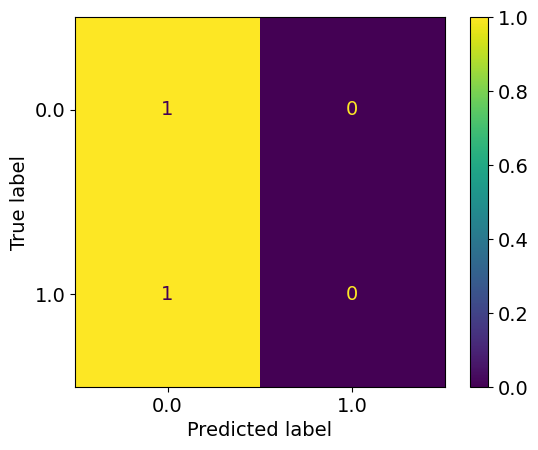

epoch: 250
Learning rate: 5.4965494655778717e-11


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:28<00:00,  4.71it/s]


train loss: 0.007819783620935094
train acc: 0.99839616


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.68it/s]


test loss: 0.008947863483011615
test acc: 0.9985967
epoch: 251
Learning rate: 0.0009990280304188672


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:28<00:00,  4.71it/s]


train loss: 0.003372469890659404
train acc: 0.99918556


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00,  9.13it/s]


test loss: 0.007463239919372706
test acc: 0.9992482
epoch: 252
Learning rate: 0.0009960866801513866


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:28<00:00,  4.69it/s]


train loss: 0.0037890418517140937
train acc: 0.9991229


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.75it/s]


test loss: 0.004984792987788383
test acc: 0.99929833
epoch: 253
Learning rate: 0.0009911875023977943


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:28<00:00,  4.71it/s]


train loss: 0.003317996398233044
train acc: 0.9990352


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00,  9.17it/s]


test loss: 0.003858185032146554
test acc: 0.9992482
epoch: 254
Learning rate: 0.0009843498319744622


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:28<00:00,  4.70it/s]


train loss: 0.0029825715199564653
train acc: 0.99927324


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.84it/s]


test loss: 0.008552214555058345
test acc: 0.99889743
epoch: 255
Learning rate: 0.0009756006540427168


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:29<00:00,  4.52it/s]


train loss: 0.0038143107582105083
train acc: 0.99927324


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.68it/s]


test loss: 0.004851657233375557
test acc: 0.9992482
epoch: 256
Learning rate: 0.0009649744976107356


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:28<00:00,  4.71it/s]


train loss: 0.003432094410907585
train acc: 0.99913543


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.81it/s]


test loss: 0.007170521976742015
test acc: 0.9986468
epoch: 257
Learning rate: 0.0009525132992633268


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:29<00:00,  4.55it/s]


train loss: 0.003362525628490538
train acc: 0.999361


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.83it/s]


test loss: 0.00461558530387825
test acc: 0.99929833
epoch: 258
Learning rate: 0.0009382662376573869


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:28<00:00,  4.71it/s]


train loss: 0.003033884521090528
train acc: 0.9993735


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.84it/s]


test loss: 0.0018775071271720054
test acc: 0.9995489
epoch: 259
Learning rate: 0.0009222895394362116


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:29<00:00,  4.56it/s]


train loss: 0.003937304258999521
train acc: 0.99911034


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.80it/s]


test loss: 0.0013225956044326428
test acc: 0.9996993


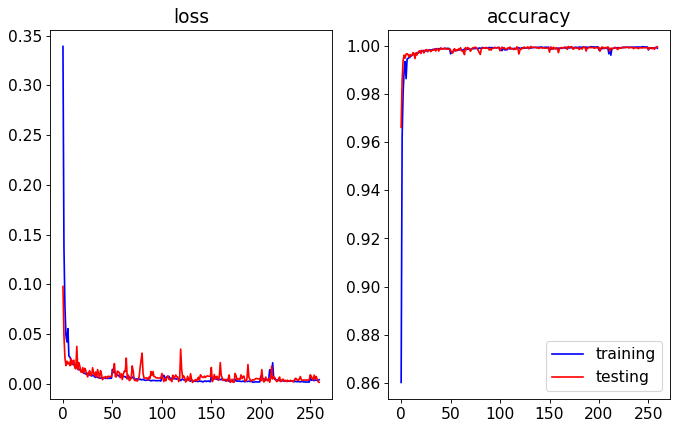

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.87it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


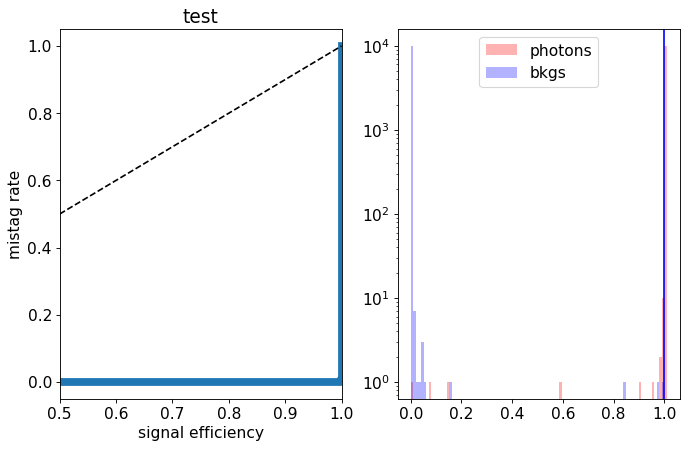

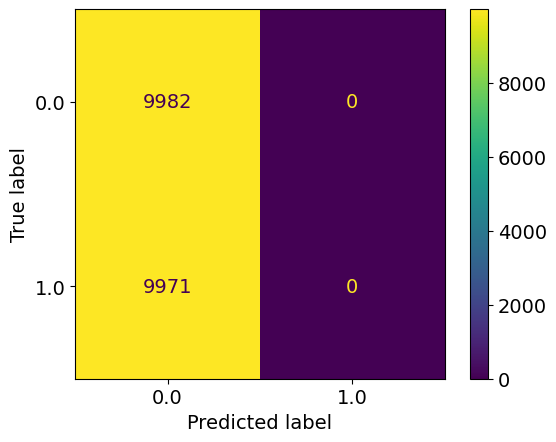

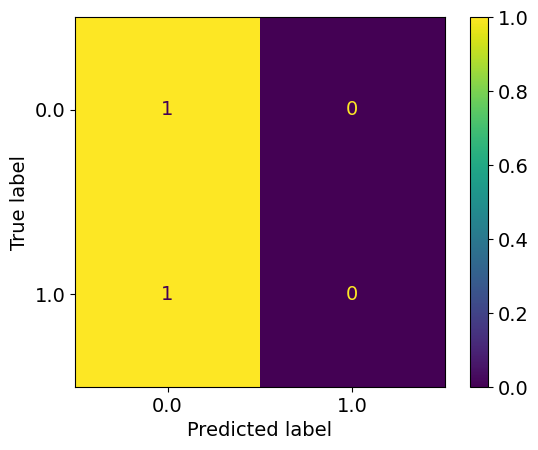

epoch: 260
Learning rate: 0.0009046462573286207


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:28<00:00,  4.73it/s]


train loss: 0.0055819640515777005
train acc: 0.9987846


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.82it/s]


test loss: 0.0016137625419645474
test acc: 0.99959904
epoch: 261
Learning rate: 0.0008854060213086441


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:29<00:00,  4.57it/s]


train loss: 0.004652249848677728
train acc: 0.99916047


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.88it/s]


test loss: 0.002145924908342266
test acc: 0.9994487
epoch: 262
Learning rate: 0.0008646447637978249


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:28<00:00,  4.72it/s]


train loss: 0.004204611697787186
train acc: 0.9989475


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00,  9.65it/s]


test loss: 0.0011965102827338073
test acc: 0.99959904
epoch: 263
Learning rate: 0.0008424444199946421


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:28<00:00,  4.73it/s]


train loss: 0.002806302965158195
train acc: 0.99928576


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.85it/s]


test loss: 0.004490934469016755
test acc: 0.99934846
epoch: 264
Learning rate: 0.0008188926045137141


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:28<00:00,  4.71it/s]


train loss: 0.003339806364075135
train acc: 0.99934846


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00,  9.07it/s]


test loss: 0.015634147940507874
test acc: 0.99844635
epoch: 265
Learning rate: 0.0007940822656109436


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:28<00:00,  4.70it/s]


train loss: 0.003546392722387621
train acc: 0.99918556


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.72it/s]


test loss: 0.009527765956425368
test acc: 0.9986468
epoch: 266
Learning rate: 0.0007681113183592139


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:28<00:00,  4.71it/s]


train loss: 0.00392399560505917
train acc: 0.9990978


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00,  9.28it/s]


test loss: 0.0006987940919901468
test acc: 0.99979955
epoch: 267
Learning rate: 0.0007410822582223305


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:28<00:00,  4.71it/s]


train loss: 0.0026929744832895905
train acc: 0.999361


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.75it/s]


test loss: 0.002512943014266705
test acc: 0.9993986
epoch: 268
Learning rate: 0.0007131017565522505


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:29<00:00,  4.56it/s]


train loss: 0.0031620024035775526
train acc: 0.9993985


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.73it/s]


test loss: 0.01169047334454209
test acc: 0.9985967
epoch: 269
Learning rate: 0.0006842802396059906


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:28<00:00,  4.71it/s]


train loss: 0.002446807917240493
train acc: 0.99946123


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.85it/s]


test loss: 0.0036248765724818713
test acc: 0.9993986


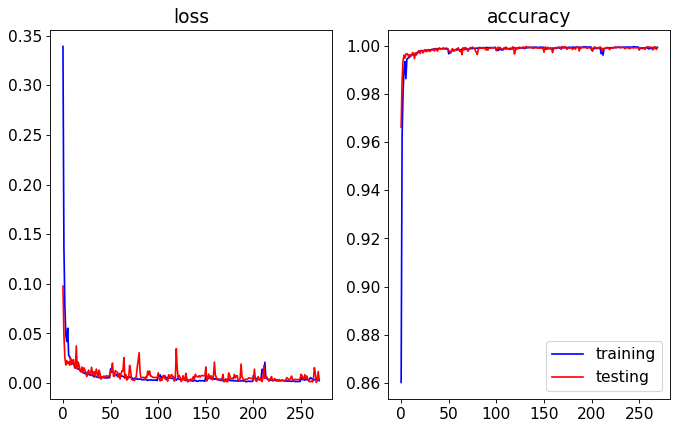

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.83it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


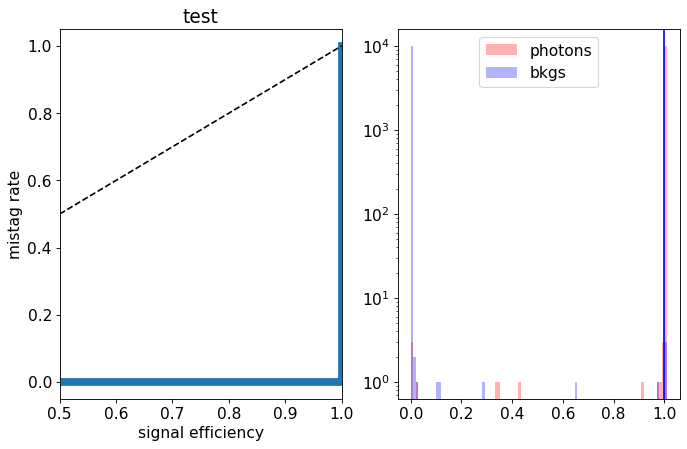

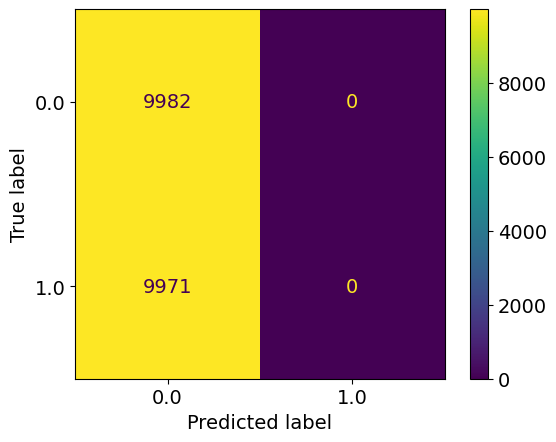

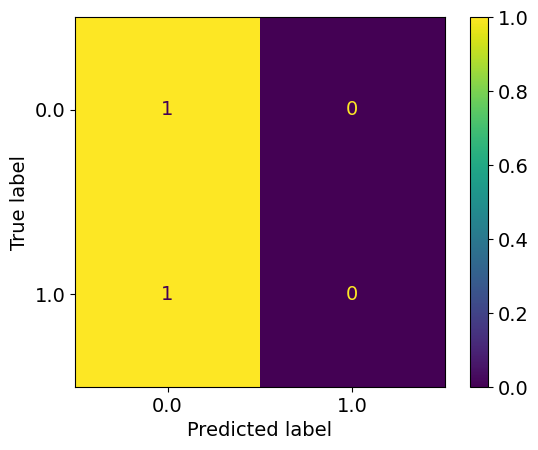

epoch: 270
Learning rate: 0.0006547314527436393


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:29<00:00,  4.53it/s]


train loss: 0.003421547622619711
train acc: 0.99928576


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.49it/s]


test loss: 0.00358068523752042
test acc: 0.99929833
epoch: 271
Learning rate: 0.0006245720115273854


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:28<00:00,  4.70it/s]


train loss: 0.003322673080090871
train acc: 0.99934846


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.73it/s]


test loss: 0.0021197148936698126
test acc: 0.9995489
epoch: 272
Learning rate: 0.0005939209414931715


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:29<00:00,  4.53it/s]


train loss: 0.0023204784700473244
train acc: 0.99947375


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.70it/s]


test loss: 0.01473326625767382
test acc: 0.9985967
epoch: 273
Learning rate: 0.0005628992084112805


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:28<00:00,  4.68it/s]


train loss: 0.0031488749109349324
train acc: 0.99918556


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.65it/s]


test loss: 0.006840295805533672
test acc: 0.9989475
epoch: 274
Learning rate: 0.0005316292408897053


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:29<00:00,  4.51it/s]


train loss: 0.0027542833296721977
train acc: 0.9995113


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.49it/s]


test loss: 0.002755125645786988
test acc: 0.9993986
epoch: 275
Learning rate: 0.0005002344472043639


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:28<00:00,  4.65it/s]


train loss: 0.002459561090860794
train acc: 0.99947375


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00,  8.82it/s]


test loss: 0.00826076900443737
test acc: 0.9986969
epoch: 276
Learning rate: 0.0004688387282630159


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:28<00:00,  4.65it/s]


train loss: 0.002060641838642056
train acc: 0.9995239


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.39it/s]


test loss: 0.005938941729599686
test acc: 0.999148
epoch: 277
Learning rate: 0.0004375659886249827


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:28<00:00,  4.66it/s]


train loss: 0.0021649878673536058
train acc: 0.9996241


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00,  8.85it/s]


test loss: 0.007524501484098987
test acc: 0.99889743
epoch: 278
Learning rate: 0.00040653964750646005


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:28<00:00,  4.66it/s]


train loss: 0.0022655754559065227
train acc: 0.99944866


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.51it/s]


test loss: 0.003945106989507393
test acc: 0.9994487
epoch: 279
Learning rate: 0.00037588215170125596


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:29<00:00,  4.47it/s]


train loss: 0.002200641321541189
train acc: 0.9995113


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.59it/s]


test loss: 0.0033204714317742615
test acc: 0.99949884


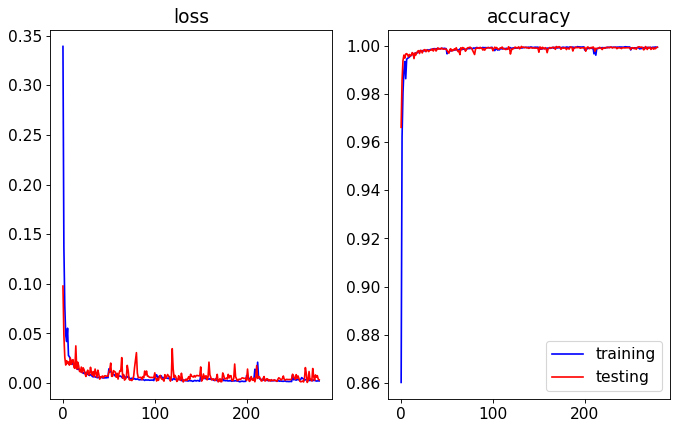

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.70it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


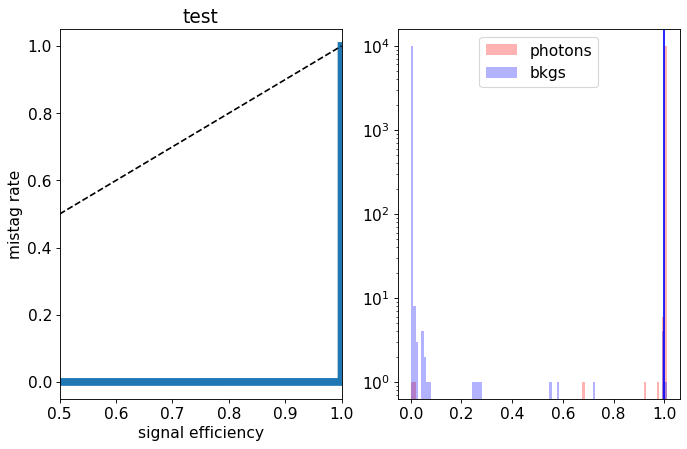

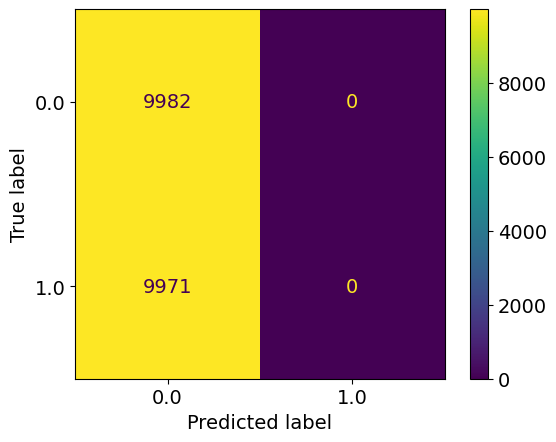

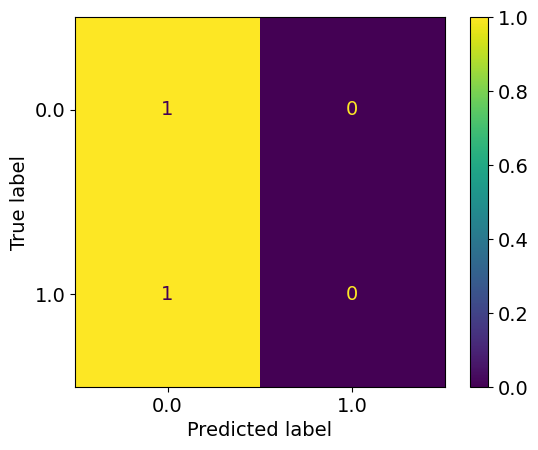

epoch: 280
Learning rate: 0.0003457144923392358


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:28<00:00,  4.66it/s]


train loss: 0.001833549188835496
train acc: 0.9994988


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.54it/s]


test loss: 0.005552579702413061
test acc: 0.9995489
epoch: 281
Learning rate: 0.000316155727389609


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:30<00:00,  4.47it/s]


train loss: 0.0019756060769870886
train acc: 0.9995239


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.17it/s]


test loss: 0.009252025261052739
test acc: 0.9987972
epoch: 282
Learning rate: 0.00028732251179351654


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:28<00:00,  4.63it/s]


train loss: 0.0021941702705542193
train acc: 0.99948627


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.50it/s]


test loss: 0.0052911459377610395
test acc: 0.99919814
epoch: 283
Learning rate: 0.0002593286370802732


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:31<00:00,  4.30it/s]


train loss: 0.0015897969527968463
train acc: 0.9996241


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.47it/s]


test loss: 0.011772779265258895
test acc: 0.9985967
epoch: 284
Learning rate: 0.000232284582284187


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:29<00:00,  4.58it/s]


train loss: 0.0018063868613611323
train acc: 0.9996617


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.21it/s]


test loss: 0.0044837425170466865
test acc: 0.9992482
epoch: 285
Learning rate: 0.00020629707793428477


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:30<00:00,  4.37it/s]


train loss: 0.0016995811449471909
train acc: 0.99961156


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.01it/s]


test loss: 0.0017609436292247297
test acc: 0.99964917
epoch: 286
Learning rate: 0.00018146868483767426


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:29<00:00,  4.59it/s]


train loss: 0.0019557668371558293
train acc: 0.9995614


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 11.87it/s]


test loss: 0.0025519125560122357
test acc: 0.9995489
epoch: 287
Learning rate: 0.00015789738931889407


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:30<00:00,  4.35it/s]


train loss: 0.0015906368053415566
train acc: 0.9996868


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.01it/s]


test loss: 0.0035320519581331414
test acc: 0.9993986
epoch: 288
Learning rate: 0.00013567621651265594


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:29<00:00,  4.58it/s]


train loss: 0.002425720290307593
train acc: 0.9995113


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:04<00:00,  8.02it/s]


test loss: 0.002550140428356179
test acc: 0.9995489
epoch: 289
Learning rate: 0.00011489286323613807


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:29<00:00,  4.60it/s]


train loss: 0.0016376947247305174
train acc: 0.9996742


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.19it/s]


test loss: 0.007849333923704372
test acc: 0.9990979


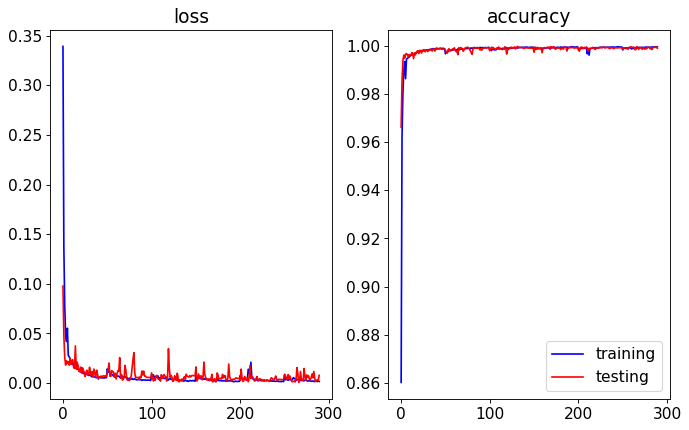

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.42it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


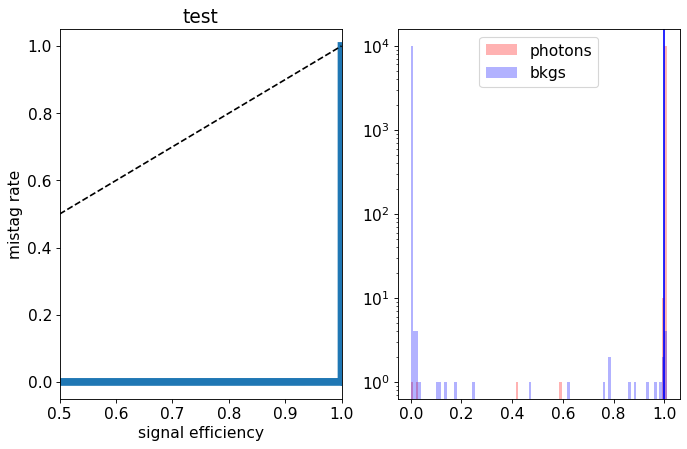

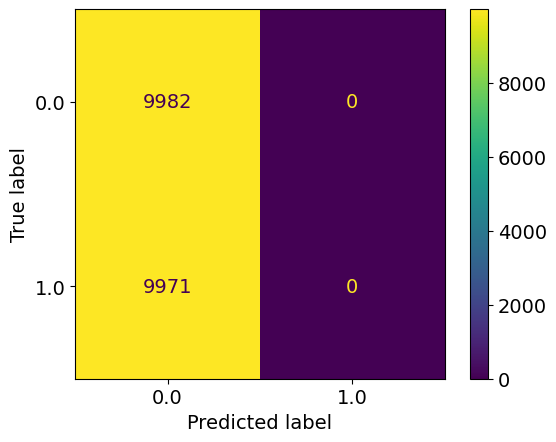

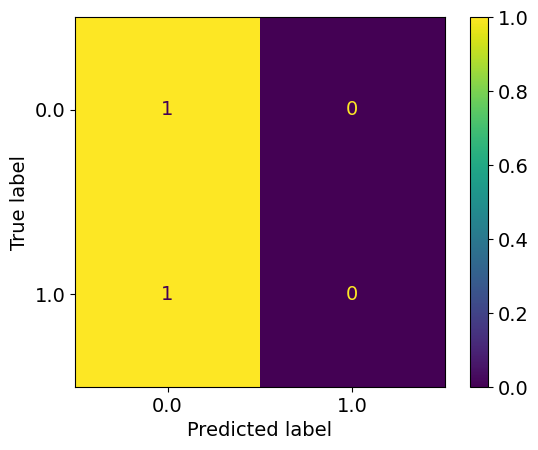

epoch: 290
Learning rate: 9.562935188971195e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:30<00:00,  4.39it/s]


train loss: 0.001617540669274989
train acc: 0.9997118


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.35it/s]


test loss: 0.0029357352805681977
test acc: 0.99959904
epoch: 291
Learning rate: 7.796170675200065e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:29<00:00,  4.60it/s]


train loss: 0.0015055948937406898
train acc: 0.99964917


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.61it/s]


test loss: 0.00972049876800106
test acc: 0.9986969
epoch: 292
Learning rate: 6.195965394678355e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:30<00:00,  4.37it/s]


train loss: 0.001342851991073225
train acc: 0.9996993


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.10it/s]


test loss: 0.00612632746453625
test acc: 0.999148
epoch: 293
Learning rate: 4.7686346265840285e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:29<00:00,  4.61it/s]


train loss: 0.001392596680000394
train acc: 0.99964917


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.47it/s]


test loss: 0.0033151967413363836
test acc: 0.9993986
epoch: 294
Learning rate: 3.519811393373346e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:30<00:00,  4.37it/s]


train loss: 0.0016041077648892429
train acc: 0.99961156


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.22it/s]


test loss: 0.0031715179250729106
test acc: 0.99949884
epoch: 295
Learning rate: 2.454424229814728e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:29<00:00,  4.56it/s]


train loss: 0.0013959605777016017
train acc: 0.9996993


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.15it/s]


test loss: 0.003709156616328362
test acc: 0.9993986
epoch: 296
Learning rate: 1.5766777323136415e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:30<00:00,  4.36it/s]


train loss: 0.00160269270934042
train acc: 0.9995614


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.31it/s]


test loss: 0.003891577325030098
test acc: 0.9993986
epoch: 297
Learning rate: 8.90035965291497e-06


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:29<00:00,  4.59it/s]


train loss: 0.00145255128442057
train acc: 0.9996868


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.05it/s]


test loss: 0.006913450163191089
test acc: 0.99934846
epoch: 298
Learning rate: 3.972087901059462e-06


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:30<00:00,  4.37it/s]


train loss: 0.001542379907746113
train acc: 0.9996868


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.02it/s]


test loss: 0.004045651477330479
test acc: 0.99934846
epoch: 299
Learning rate: 1.0014117046612258e-06


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:29<00:00,  4.59it/s]


train loss: 0.001393476284674626
train acc: 0.99973685


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.08it/s]


test loss: 0.004069334231168568
test acc: 0.99934846


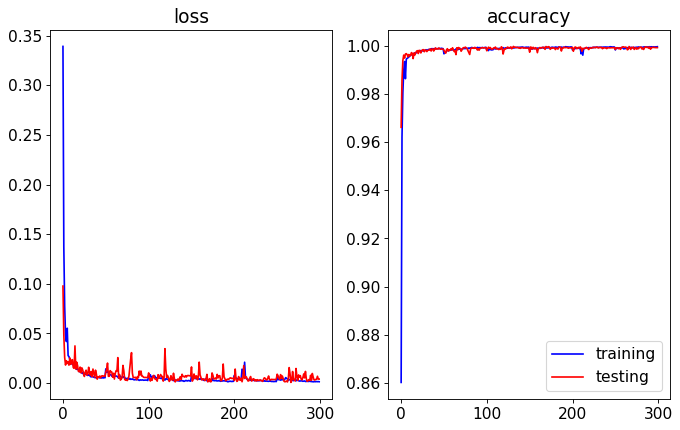

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:04<00:00,  7.89it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


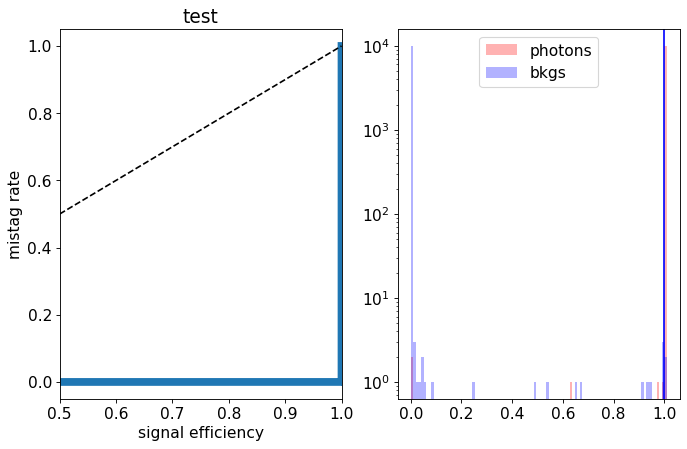

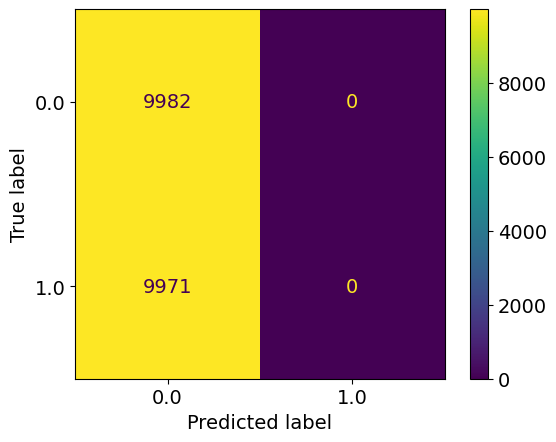

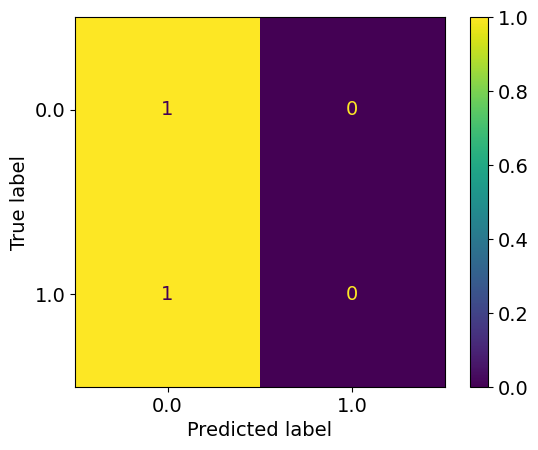

epoch: 300
Learning rate: 5.4965494655778717e-11


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:28<00:00,  4.62it/s]


train loss: 0.002089876569343755
train acc: 0.9994236


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.55it/s]


test loss: 0.0025370967308756738
test acc: 0.9995489
epoch: 301
Learning rate: 0.0009990280304188672


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:30<00:00,  4.35it/s]


train loss: 0.006000883158043534
train acc: 0.99882215


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.26it/s]


test loss: 0.018879749923465115
test acc: 0.9969428
epoch: 302
Learning rate: 0.0009960866801513866


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:29<00:00,  4.59it/s]


train loss: 0.005772198082135517
train acc: 0.9987971


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 11.88it/s]


test loss: 0.0033974440426944473
test acc: 0.99934846
epoch: 303
Learning rate: 0.0009911875023977945


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:30<00:00,  4.36it/s]


train loss: 0.005119170071691824
train acc: 0.9989475


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.44it/s]


test loss: 0.005852475519126736
test acc: 0.99929833
epoch: 304
Learning rate: 0.0009843498319744624


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:29<00:00,  4.60it/s]


train loss: 0.003854199769818085
train acc: 0.99916047


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 11.97it/s]


test loss: 0.002629559691080128
test acc: 0.9993986
epoch: 305
Learning rate: 0.0009756006540427171


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:30<00:00,  4.41it/s]


train loss: 0.0033041473922016612
train acc: 0.9994111


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.42it/s]


test loss: 0.008600179691995682
test acc: 0.9984965
epoch: 306
Learning rate: 0.000964974497610736


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:29<00:00,  4.58it/s]


train loss: 0.002621145119695966
train acc: 0.99931085


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.30it/s]


test loss: 0.004828724937950129
test acc: 0.99929833
epoch: 307
Learning rate: 0.0009525132992633268


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:30<00:00,  4.35it/s]


train loss: 0.004005453826789223
train acc: 0.9990352


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.10it/s]


test loss: 0.0029597736167186715
test acc: 0.9993986
epoch: 308
Learning rate: 0.0009382662376573869


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:29<00:00,  4.57it/s]


train loss: 0.0032478941001999138
train acc: 0.99918556


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.14it/s]


test loss: 0.0026467809445029256
test acc: 0.9993986
epoch: 309
Learning rate: 0.0009222895394362116


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:30<00:00,  4.37it/s]


train loss: 0.002235925429736945
train acc: 0.9995489


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.54it/s]


test loss: 0.001218064266989632
test acc: 0.99979955


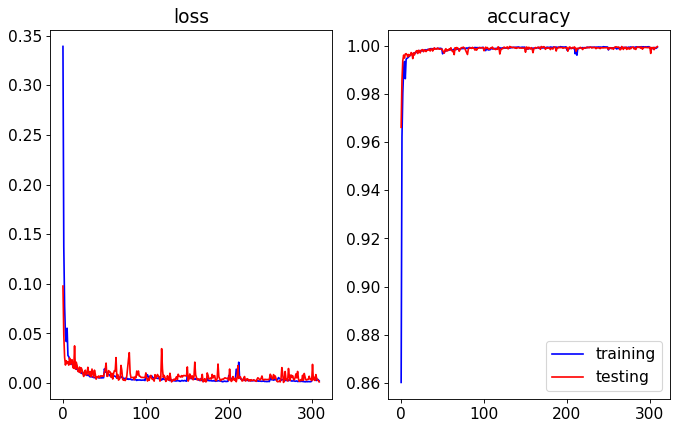

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.41it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


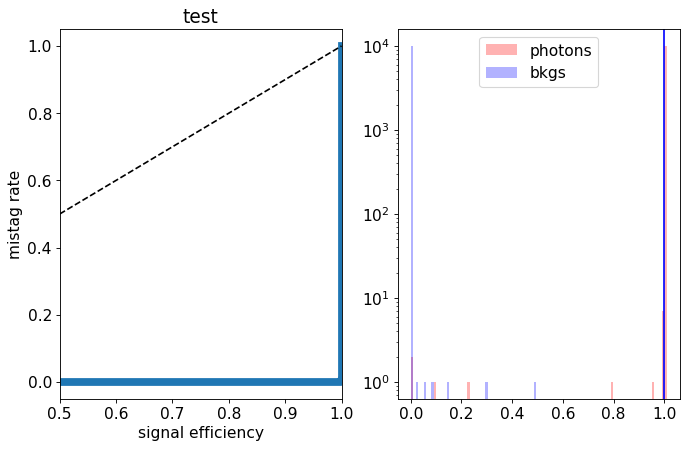

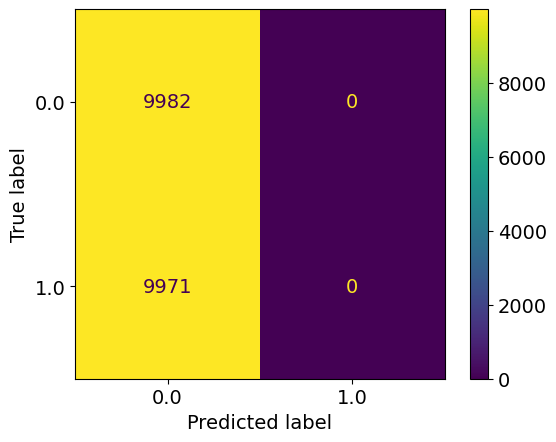

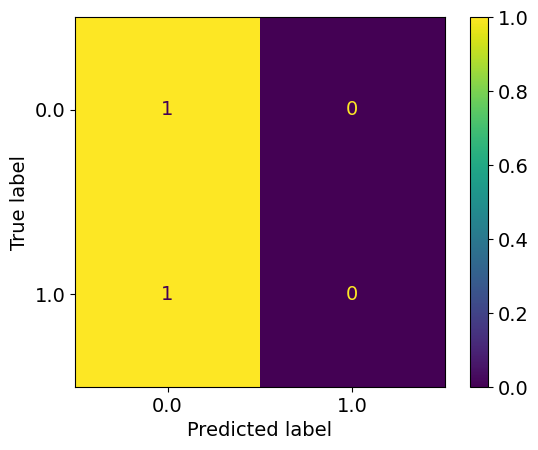

epoch: 310
Learning rate: 0.0009046462573286207


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:30<00:00,  4.39it/s]


train loss: 0.0031039918124664456
train acc: 0.99934846


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.46it/s]


test loss: 0.0021287437942158777
test acc: 0.9996993
epoch: 311
Learning rate: 0.0008854060213086441


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:28<00:00,  4.63it/s]


train loss: 0.004079823247539296
train acc: 0.99927324


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.42it/s]


test loss: 0.0023892680612817474
test acc: 0.9994487
epoch: 312
Learning rate: 0.0008646447637978249


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:30<00:00,  4.39it/s]


train loss: 0.002608141139581392
train acc: 0.99932337


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.49it/s]


test loss: 0.0012344311697828675
test acc: 0.99964917
epoch: 313
Learning rate: 0.0008424444199946421


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:28<00:00,  4.62it/s]


train loss: 0.0030846757081908834
train acc: 0.99929833


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.00it/s]


test loss: 0.0015145260818780662
test acc: 0.99964917
epoch: 314
Learning rate: 0.0008188926045137141


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:30<00:00,  4.41it/s]


train loss: 0.003170935728230145
train acc: 0.99934846


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.05it/s]


test loss: 0.0033603802686254284
test acc: 0.99949884
epoch: 315
Learning rate: 0.0007940822656109436


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:29<00:00,  4.58it/s]


train loss: 0.002801096984057949
train acc: 0.999361


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.29it/s]


test loss: 0.0017436858624962197
test acc: 0.9996993
epoch: 316
Learning rate: 0.0007681113183592139


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:30<00:00,  4.40it/s]


train loss: 0.002260301258447997
train acc: 0.9994236


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.55it/s]


test loss: 0.003882590124427644
test acc: 0.9992482
epoch: 317
Learning rate: 0.0007410822582223305


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:29<00:00,  4.59it/s]


train loss: 0.0031504890810999733
train acc: 0.999386


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.01it/s]


test loss: 0.0037208960789222507
test acc: 0.99904776
epoch: 318
Learning rate: 0.0007131017565522505


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:30<00:00,  4.42it/s]


train loss: 0.0026571674275350124
train acc: 0.9994236


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.30it/s]


test loss: 0.008535718286211554
test acc: 0.99889743
epoch: 319
Learning rate: 0.0006842802396059906


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:28<00:00,  4.64it/s]


train loss: 0.002707438674786229
train acc: 0.99944866


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.43it/s]


test loss: 0.015771311699296575
test acc: 0.9983461


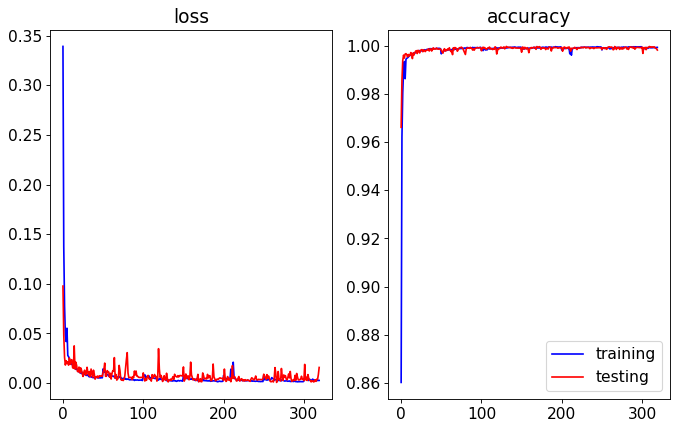

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.65it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


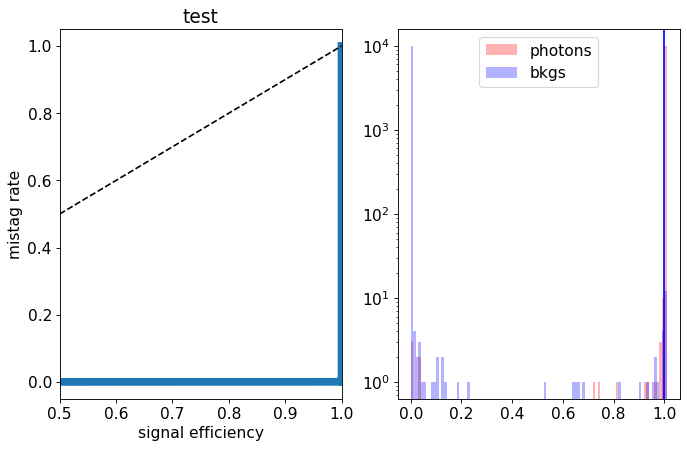

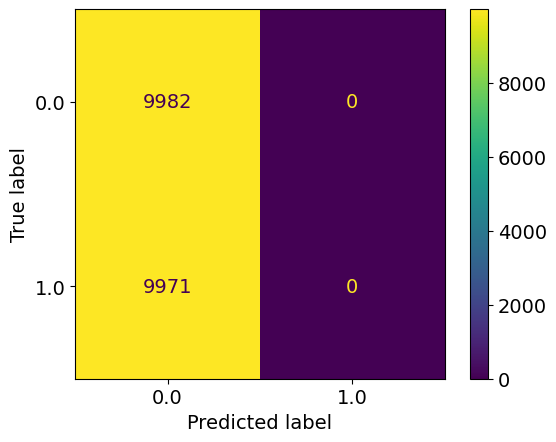

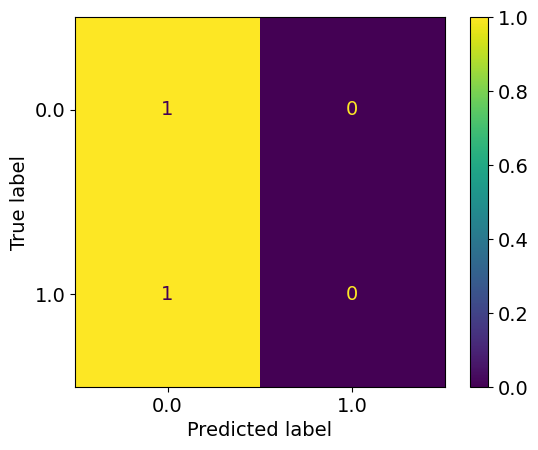

epoch: 320
Learning rate: 0.0006547314527436393


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:29<00:00,  4.60it/s]


train loss: 0.002717253421105309
train acc: 0.9994236


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.30it/s]


test loss: 0.00531440900096737
test acc: 0.99889743
epoch: 321
Learning rate: 0.0006245720115273854


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:29<00:00,  4.60it/s]


train loss: 0.0021538391922366652
train acc: 0.9995489


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:04<00:00,  8.29it/s]


test loss: 0.005663231478328701
test acc: 0.99929833
epoch: 322
Learning rate: 0.0005939209414931715


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:28<00:00,  4.62it/s]


train loss: 0.0028437020199776476
train acc: 0.999361


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.43it/s]


test loss: 0.0014646926579033293
test acc: 0.9996993
epoch: 323
Learning rate: 0.0005628992084112805


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:30<00:00,  4.41it/s]


train loss: 0.0029358527867567427
train acc: 0.9993985


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.35it/s]


test loss: 0.005440826333500247
test acc: 0.9989976
epoch: 324
Learning rate: 0.0005316292408897053


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:28<00:00,  4.63it/s]


train loss: 0.0024852025645739546
train acc: 0.9993735


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.45it/s]


test loss: 0.0169218464582834
test acc: 0.99759436
epoch: 325
Learning rate: 0.0005002344472043639


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:30<00:00,  4.43it/s]


train loss: 0.002786816070646868
train acc: 0.9993985


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.46it/s]


test loss: 0.0029189971601482198
test acc: 0.9989976
epoch: 326
Learning rate: 0.0004688387282630159


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:29<00:00,  4.62it/s]


train loss: 0.001697340469409435
train acc: 0.9995865


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.60it/s]


test loss: 0.002213595677887616
test acc: 0.99964917
epoch: 327
Learning rate: 0.0004375659886249827


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:30<00:00,  4.39it/s]


train loss: 0.0023480418571967107
train acc: 0.99944866


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.55it/s]


test loss: 0.0017693311085535826
test acc: 0.9995489
epoch: 328
Learning rate: 0.00040653964750646005


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:28<00:00,  4.63it/s]


train loss: 0.0017024624494551836
train acc: 0.9995865


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.37it/s]


test loss: 0.002870633018707955
test acc: 0.9993986
epoch: 329
Learning rate: 0.00037588215170125596


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:30<00:00,  4.43it/s]


train loss: 0.002093559646641891
train acc: 0.99948627


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.63it/s]


test loss: 0.004227158098997789
test acc: 0.99919814


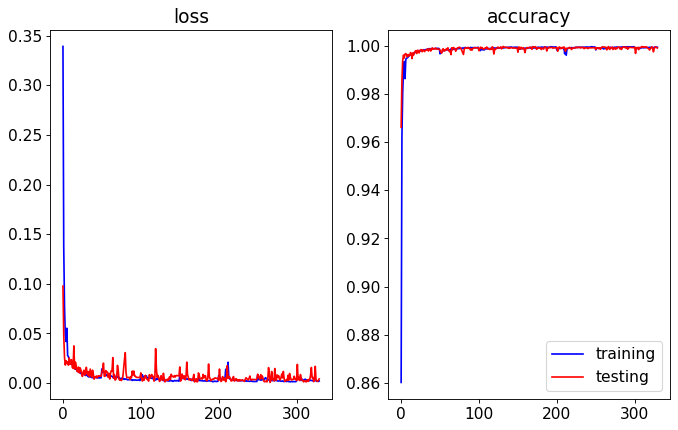

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.70it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


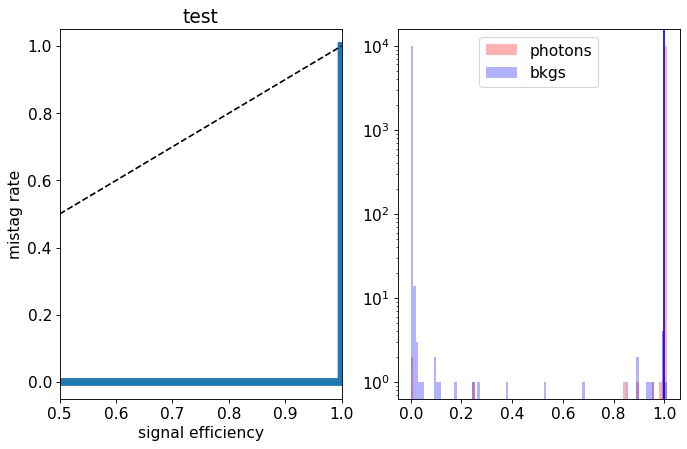

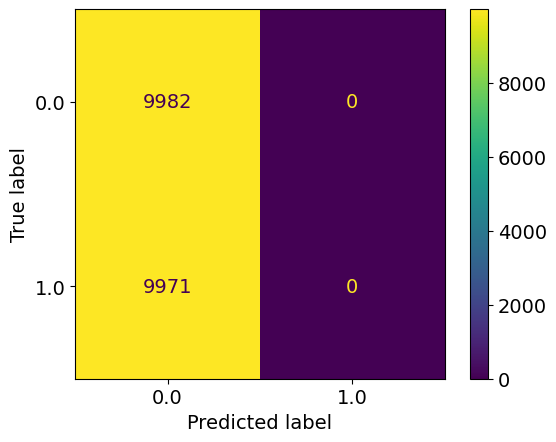

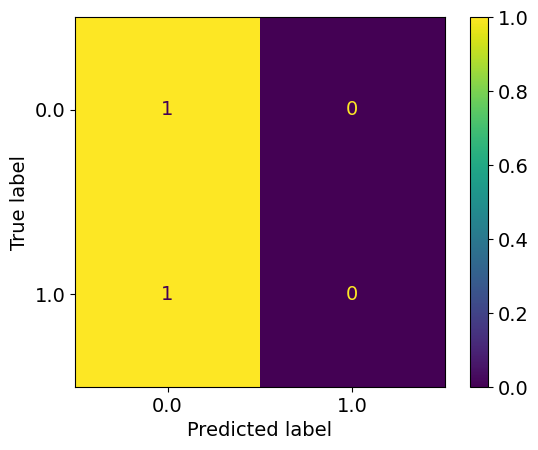

epoch: 330
Learning rate: 0.0003457144923392358


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:28<00:00,  4.64it/s]


train loss: 0.001897766177250166
train acc: 0.999574


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:04<00:00,  8.35it/s]


test loss: 0.00540287031875892
test acc: 0.99904776
epoch: 331
Learning rate: 0.000316155727389609


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:29<00:00,  4.61it/s]


train loss: 0.0021374474480811596
train acc: 0.9995239


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 11.72it/s]


test loss: 0.0031378757397533784
test acc: 0.99904776
epoch: 332
Learning rate: 0.00028732251179351654


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:29<00:00,  4.60it/s]


train loss: 0.0022258690306790046
train acc: 0.9995614


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:04<00:00,  8.02it/s]


test loss: 0.0013208741791012404
test acc: 0.99964917
epoch: 333
Learning rate: 0.0002593286370802732


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:29<00:00,  4.60it/s]


train loss: 0.0019339465100299278
train acc: 0.9995364


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.15it/s]


test loss: 0.004108290550575966
test acc: 0.99919814
epoch: 334
Learning rate: 0.000232284582284187


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:30<00:00,  4.41it/s]


train loss: 0.001750481952417906
train acc: 0.99964917


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.57it/s]


test loss: 0.010223854673407735
test acc: 0.99874705
epoch: 335
Learning rate: 0.00020629707793428477


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:28<00:00,  4.64it/s]


train loss: 0.0016340548836659928
train acc: 0.9997118


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.25it/s]


test loss: 0.004547609555849476
test acc: 0.9990979
epoch: 336
Learning rate: 0.00018146868483767426


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:30<00:00,  4.44it/s]


train loss: 0.0018348453019431889
train acc: 0.9996617


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.22it/s]


test loss: 0.0023141782521851027
test acc: 0.99934846
epoch: 337
Learning rate: 0.00015789738931889407


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:28<00:00,  4.65it/s]


train loss: 0.0023885385482381974
train acc: 0.9995113


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.59it/s]


test loss: 0.003168112262121753
test acc: 0.999148
epoch: 338
Learning rate: 0.00013567621651265594


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:30<00:00,  4.41it/s]


train loss: 0.0015729715936984902
train acc: 0.9996993


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.43it/s]


test loss: 0.004096414729238277
test acc: 0.99919814
epoch: 339
Learning rate: 0.00011489286323613807


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:28<00:00,  4.63it/s]


train loss: 0.0016784303737569725
train acc: 0.99961156


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.45it/s]


test loss: 0.0031869955210879273
test acc: 0.99919814


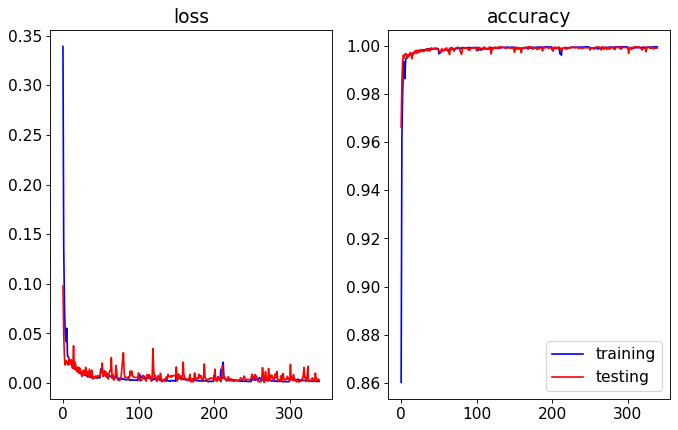

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.53it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


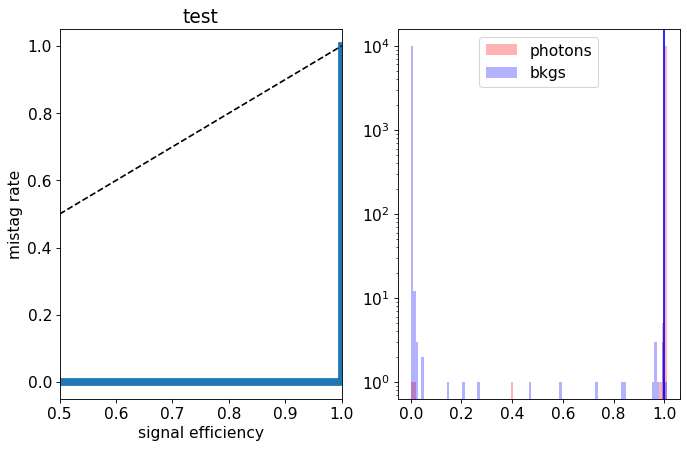

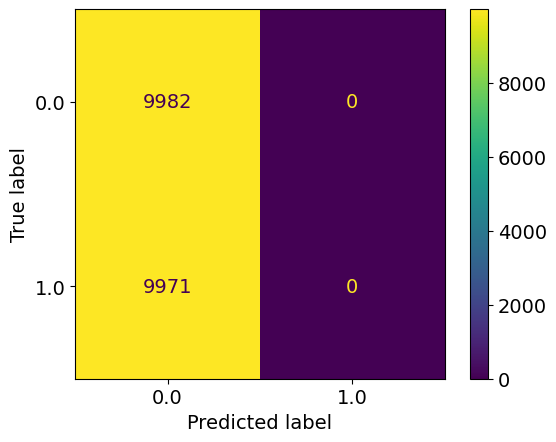

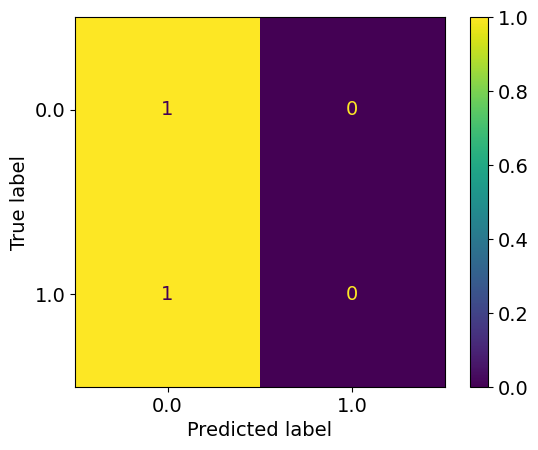

epoch: 340
Learning rate: 9.562935188971195e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:30<00:00,  4.45it/s]


train loss: 0.0014255960993735434
train acc: 0.9996617


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.50it/s]


test loss: 0.003979040972597244
test acc: 0.99919814
epoch: 341
Learning rate: 7.796170675200065e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:28<00:00,  4.64it/s]


train loss: 0.001769641770080815
train acc: 0.9995364


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.38it/s]


test loss: 0.005043778045872906
test acc: 0.99919814
epoch: 342
Learning rate: 6.195965394678355e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:30<00:00,  4.44it/s]


train loss: 0.0014923389158566253
train acc: 0.9997118


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.44it/s]


test loss: 0.003749368189976246
test acc: 0.9992482
epoch: 343
Learning rate: 4.7686346265840285e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:28<00:00,  4.64it/s]


train loss: 0.0016200498982620211
train acc: 0.9996617


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:04<00:00,  8.22it/s]


test loss: 0.002674118976050776
test acc: 0.9994487
epoch: 344
Learning rate: 3.519811393373346e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:28<00:00,  4.62it/s]


train loss: 0.0016547259699258208
train acc: 0.9996993


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.39it/s]


test loss: 0.0026929536761289025
test acc: 0.9994487
epoch: 345
Learning rate: 2.454424229814728e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:28<00:00,  4.62it/s]


train loss: 0.0012986079779003076
train acc: 0.9996742


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:04<00:00,  8.16it/s]


test loss: 0.0028955452686730406
test acc: 0.9993986
epoch: 346
Learning rate: 1.5766777323136415e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:29<00:00,  4.61it/s]


train loss: 0.0015408587197447586
train acc: 0.9996868


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.62it/s]


test loss: 0.0029393523066403695
test acc: 0.9993986
epoch: 347
Learning rate: 8.90035965291497e-06


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:30<00:00,  4.37it/s]


train loss: 0.0015218933378164934
train acc: 0.9996241


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.51it/s]


test loss: 0.0030039801466705818
test acc: 0.99934846
epoch: 348
Learning rate: 3.972087901059462e-06


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:28<00:00,  4.63it/s]


train loss: 0.0014819099608863026
train acc: 0.99973685


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.50it/s]


test loss: 0.0030612856770730335
test acc: 0.99929833
epoch: 349
Learning rate: 1.0014117046612258e-06


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:30<00:00,  4.42it/s]


train loss: 0.0012197918810819993
train acc: 0.9996617


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.46it/s]


test loss: 0.003071401461668321
test acc: 0.99929833


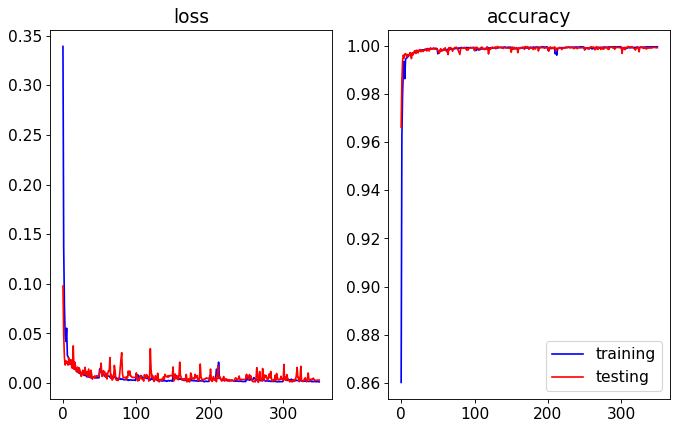

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.60it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


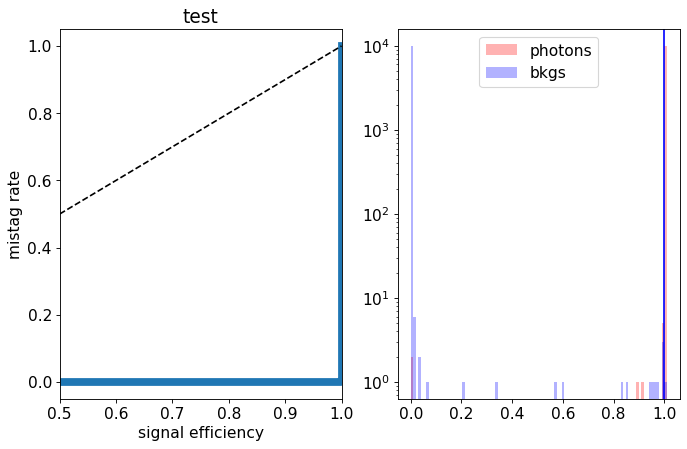

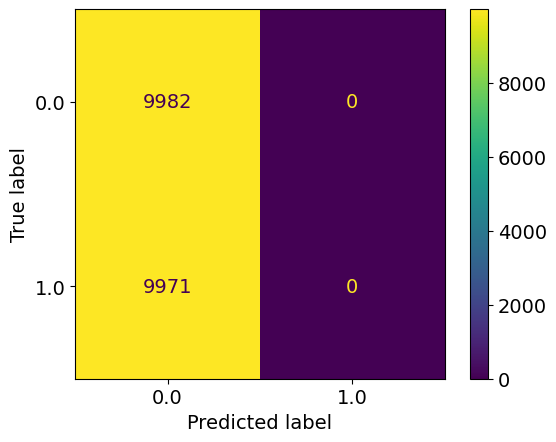

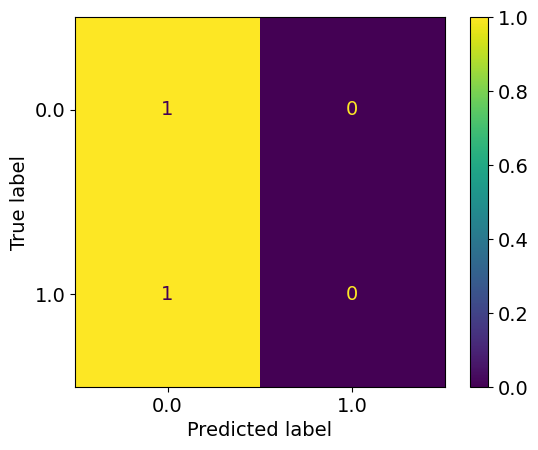

epoch: 350
Learning rate: 5.4965494655778717e-11


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:29<00:00,  4.58it/s]


train loss: 0.0069596106526141135
train acc: 0.99872196


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.14it/s]


test loss: 0.002024237319888551
test acc: 0.9995489
epoch: 351
Learning rate: 0.0009990280304188672


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:30<00:00,  4.40it/s]


train loss: 0.004434713884756324
train acc: 0.99901015


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.05it/s]


test loss: 0.0011804354795132126
test acc: 0.9996993
epoch: 352
Learning rate: 0.0009960866801513866


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:29<00:00,  4.59it/s]


train loss: 0.004781181982578536
train acc: 0.99902266


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.00it/s]


test loss: 0.0010434088302660298
test acc: 0.99949884
epoch: 353
Learning rate: 0.0009911875023977945


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:30<00:00,  4.41it/s]


train loss: 0.0026426420316509516
train acc: 0.99929833


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.14it/s]


test loss: 0.001475913638990591
test acc: 0.9997494
epoch: 354
Learning rate: 0.0009843498319744624


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:28<00:00,  4.64it/s]


train loss: 0.005877159752751833
train acc: 0.99880964


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.57it/s]


test loss: 0.005016534219740432
test acc: 0.9990979
epoch: 355
Learning rate: 0.0009756006540427171


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:30<00:00,  4.43it/s]


train loss: 0.0023500971341229786
train acc: 0.999386


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.46it/s]


test loss: 0.004604570104751147
test acc: 0.9992482
epoch: 356
Learning rate: 0.000964974497610736


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:28<00:00,  4.64it/s]


train loss: 0.003327708740369471
train acc: 0.99934846


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00,  8.69it/s]


test loss: 0.00043881944270884226
test acc: 0.9998496
epoch: 357
Learning rate: 0.0009525132992633268


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:28<00:00,  4.63it/s]


train loss: 0.002802596883387543
train acc: 0.999386


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.64it/s]


test loss: 0.00611604026726744
test acc: 0.99904776
epoch: 358
Learning rate: 0.0009382662376573869


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:28<00:00,  4.62it/s]


train loss: 0.0022413991687583925
train acc: 0.9995113


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:04<00:00,  7.86it/s]


test loss: 0.0056171804867105905
test acc: 0.99929833
epoch: 359
Learning rate: 0.0009222895394362116


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:28<00:00,  4.63it/s]


train loss: 0.0032356902696517916
train acc: 0.99931085


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.60it/s]


test loss: 0.0023532159319422457
test acc: 0.9995489


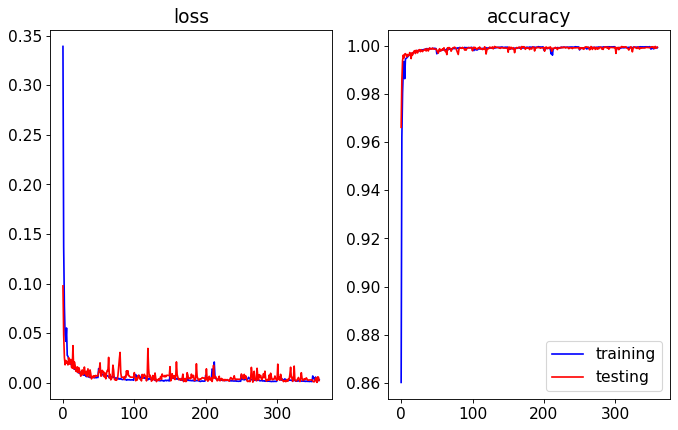

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.51it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


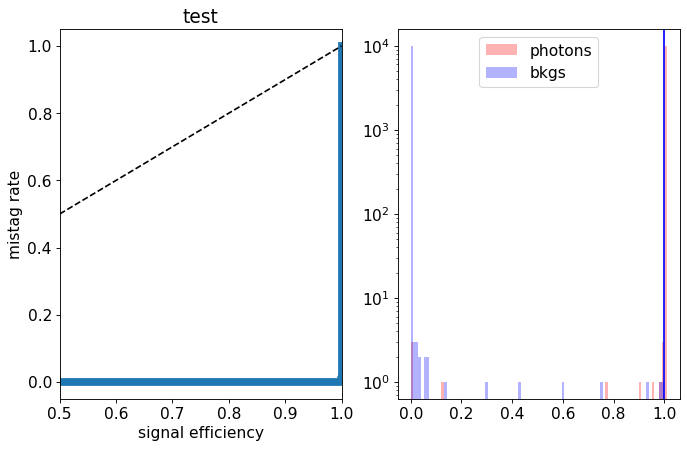

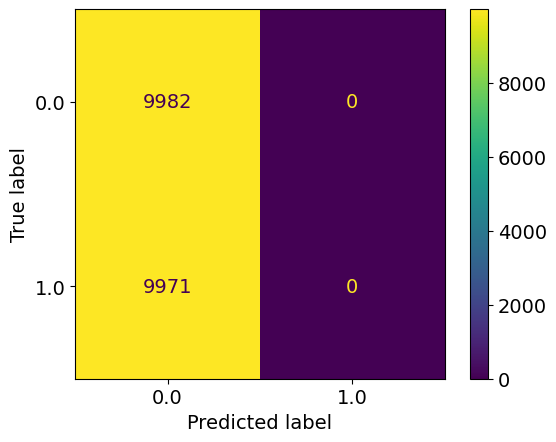

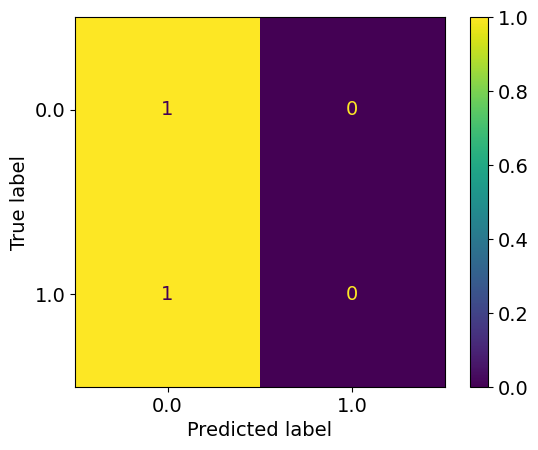

epoch: 360
Learning rate: 0.0009046462573286207


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:30<00:00,  4.39it/s]


train loss: 0.002521523678850107
train acc: 0.9993735


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.34it/s]


test loss: 0.0039813173782294
test acc: 0.9994487
epoch: 361
Learning rate: 0.0008854060213086441


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:29<00:00,  4.61it/s]


train loss: 0.003626258281140359
train acc: 0.99928576


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.38it/s]


test loss: 0.008745374146398636
test acc: 0.9983962
epoch: 362
Learning rate: 0.0008646447637978249


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:30<00:00,  4.42it/s]


train loss: 0.0021958567744631108
train acc: 0.9995239


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.41it/s]


test loss: 0.010410447219783651
test acc: 0.9984965
epoch: 363
Learning rate: 0.0008424444199946421


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:28<00:00,  4.62it/s]


train loss: 0.0024269927811314687
train acc: 0.9995113


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.50it/s]


test loss: 0.0026746405603353166
test acc: 0.9993986
epoch: 364
Learning rate: 0.0008188926045137141


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:30<00:00,  4.42it/s]


train loss: 0.003029312005255905
train acc: 0.9993735


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.10it/s]


test loss: 0.0018946328294133785
test acc: 0.9997494
epoch: 365
Learning rate: 0.0007940822656109436


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:28<00:00,  4.63it/s]


train loss: 0.002229298075634596
train acc: 0.9995113


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 11.96it/s]


test loss: 0.00384319253968361
test acc: 0.99929833
epoch: 366
Learning rate: 0.0007681113183592139


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:30<00:00,  4.42it/s]


train loss: 0.0034161218020234453
train acc: 0.9991229


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.31it/s]


test loss: 0.002298717070983718
test acc: 0.9995489
epoch: 367
Learning rate: 0.0007410822582223305


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:29<00:00,  4.59it/s]


train loss: 0.002299535993717736
train acc: 0.99947375


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00,  8.69it/s]


test loss: 0.023110253223100754
test acc: 0.9977447
epoch: 368
Learning rate: 0.0007131017565522505


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:29<00:00,  4.61it/s]


train loss: 0.003291357279283093
train acc: 0.99927324


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.15it/s]


test loss: 0.006737746588851976
test acc: 0.999148
epoch: 369
Learning rate: 0.0006842802396059906


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:29<00:00,  4.59it/s]


train loss: 0.0023907563084851146
train acc: 0.999386


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:04<00:00,  7.91it/s]


test loss: 0.003036440162119275
test acc: 0.9997494


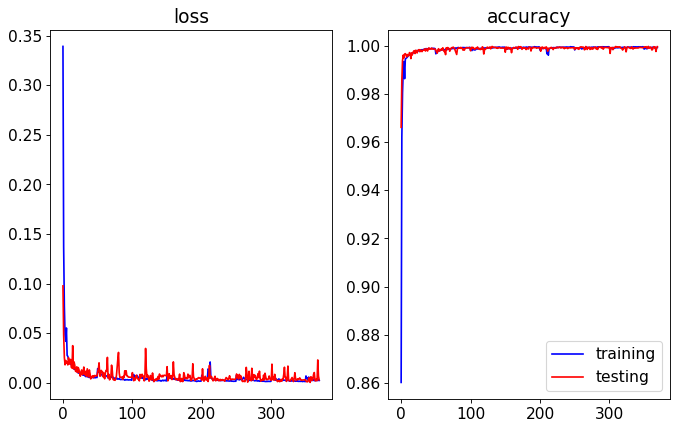

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 11.61it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


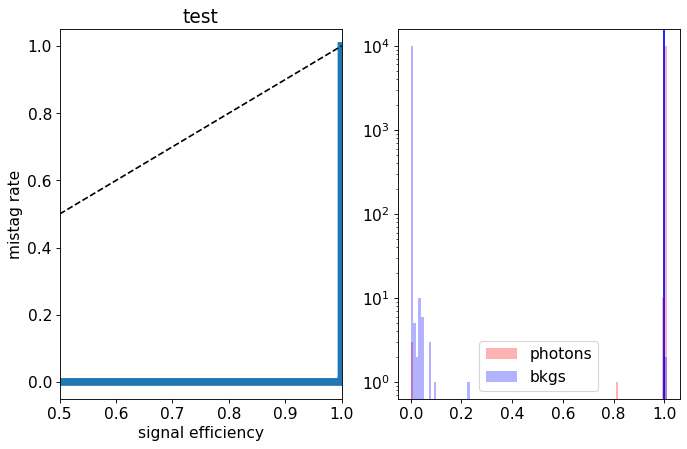

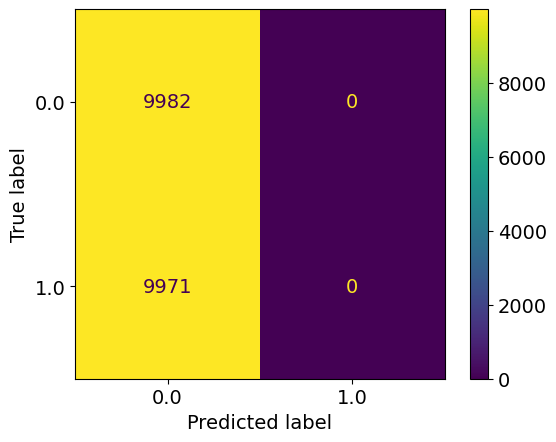

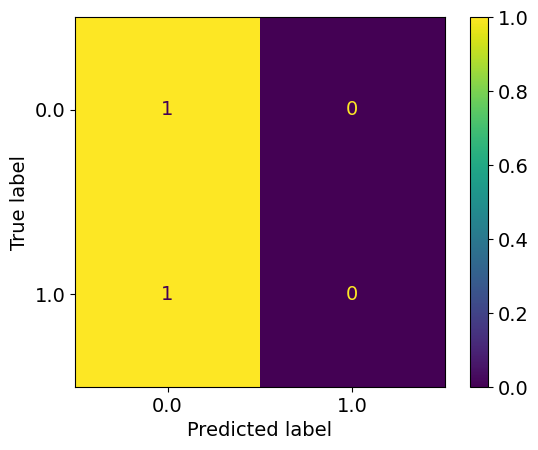

epoch: 370
Learning rate: 0.0006547314527436393


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:28<00:00,  4.62it/s]


train loss: 0.001806989845848495
train acc: 0.99948627


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 11.92it/s]


test loss: 0.0011641689121897596
test acc: 0.9998496
epoch: 371
Learning rate: 0.0006245720115273854


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:30<00:00,  4.44it/s]


train loss: 0.002064312264202041
train acc: 0.9994988


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.19it/s]


test loss: 0.0016172254397831052
test acc: 0.9997494
epoch: 372
Learning rate: 0.0005939209414931715


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:28<00:00,  4.64it/s]


train loss: 0.002378392726286749
train acc: 0.9994988


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.64it/s]


test loss: 0.004144993409209524
test acc: 0.9995489
epoch: 373
Learning rate: 0.0005628992084112805


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:29<00:00,  4.50it/s]


train loss: 0.002092639754623837
train acc: 0.9995239


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.30it/s]


test loss: 0.003631838242715346
test acc: 0.9994487
epoch: 374
Learning rate: 0.0005316292408897053


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:29<00:00,  4.62it/s]


train loss: 0.002454683259256582
train acc: 0.99948627


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.16it/s]


test loss: 0.0019086768733665488
test acc: 0.9996993
epoch: 375
Learning rate: 0.0005002344472043639


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:30<00:00,  4.44it/s]


train loss: 0.0016183698034965414
train acc: 0.999574


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.22it/s]


test loss: 0.003358700822045878
test acc: 0.99949884
epoch: 376
Learning rate: 0.0004688387282630159


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:29<00:00,  4.60it/s]


train loss: 0.0019699976792660672
train acc: 0.9996868


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.58it/s]


test loss: 0.0022102252345780928
test acc: 0.99964917
epoch: 377
Learning rate: 0.0004375659886249827


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:30<00:00,  4.46it/s]


train loss: 0.001996101609640744
train acc: 0.99961156


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.41it/s]


test loss: 0.0025743128352323412
test acc: 0.99959904
epoch: 378
Learning rate: 0.00040653964750646005


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:28<00:00,  4.63it/s]


train loss: 0.0016288671855065006
train acc: 0.999574


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.50it/s]


test loss: 0.0024135113721399258
test acc: 0.99959904
epoch: 379
Learning rate: 0.00037588215170125596


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:30<00:00,  4.46it/s]


train loss: 0.0020063390257702386
train acc: 0.99961156


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.37it/s]


test loss: 0.008632053630528136
test acc: 0.99904776


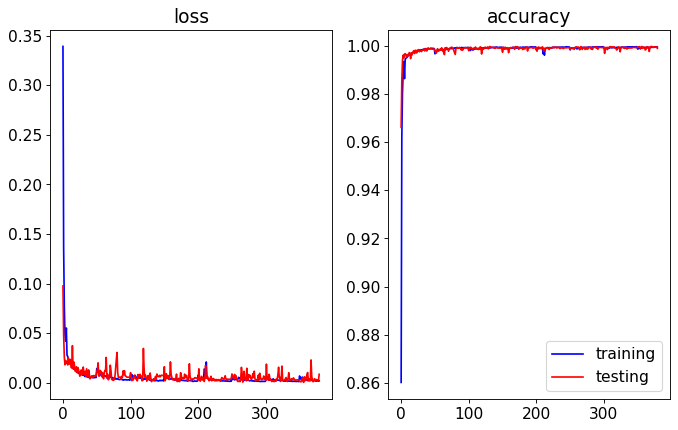

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.55it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


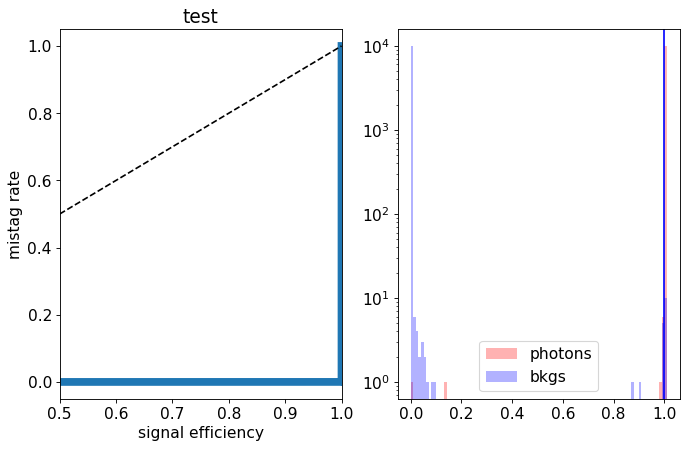

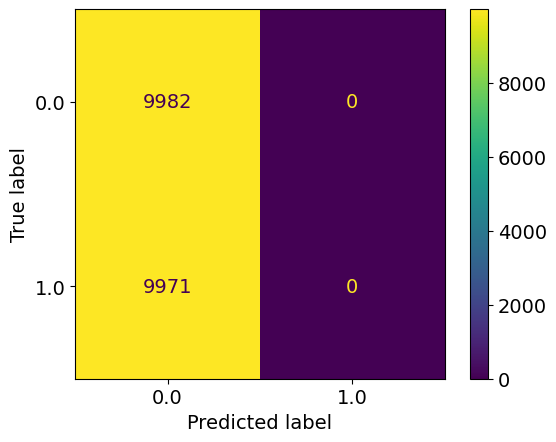

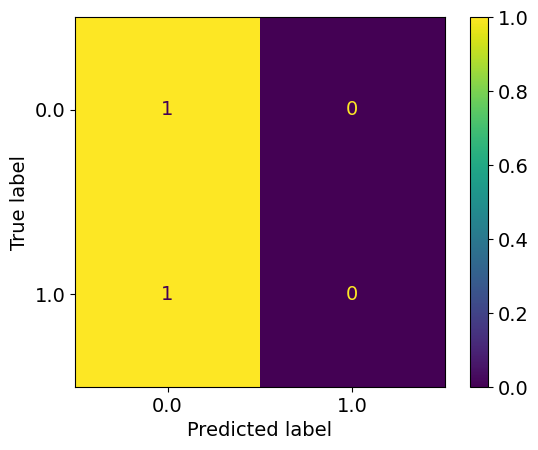

epoch: 380
Learning rate: 0.0003457144923392358


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:30<00:00,  4.44it/s]


train loss: 0.002267929920116031
train acc: 0.9995489


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.51it/s]


test loss: 0.0027022599877584348
test acc: 0.9994487
epoch: 381
Learning rate: 0.000316155727389609


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:28<00:00,  4.63it/s]


train loss: 0.0020646270423816558
train acc: 0.9995239


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.37it/s]


test loss: 0.0026614423396205777
test acc: 0.9994487
epoch: 382
Learning rate: 0.00028732251179351654


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:30<00:00,  4.42it/s]


train loss: 0.002111553187612385
train acc: 0.9995113


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.55it/s]


test loss: 0.0021070405388326856
test acc: 0.9993986
epoch: 383
Learning rate: 0.0002593286370802732


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:28<00:00,  4.65it/s]


train loss: 0.0017113727986019138
train acc: 0.9996241


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.59it/s]


test loss: 0.0023644584128828167
test acc: 0.99949884
epoch: 384
Learning rate: 0.000232284582284187


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:29<00:00,  4.48it/s]


train loss: 0.0013368529456810902
train acc: 0.9996993


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.28it/s]


test loss: 0.004627425040012923
test acc: 0.99934846
epoch: 385
Learning rate: 0.00020629707793428477


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:28<00:00,  4.64it/s]


train loss: 0.0016379426347089404
train acc: 0.9995489


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.31it/s]


test loss: 0.0032580960401886543
test acc: 0.9993986
epoch: 386
Learning rate: 0.00018146868483767426


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:29<00:00,  4.48it/s]


train loss: 0.0013040513699622094
train acc: 0.9997494


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.54it/s]


test loss: 0.005520122156627079
test acc: 0.9992482
epoch: 387
Learning rate: 0.00015789738931889407


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:28<00:00,  4.64it/s]


train loss: 0.001314859128865125
train acc: 0.9997243


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.50it/s]


test loss: 0.005151661885129871
test acc: 0.99929833
epoch: 388
Learning rate: 0.00013567621651265594


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:30<00:00,  4.46it/s]


train loss: 0.0016969515926534907
train acc: 0.9996617


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.41it/s]


test loss: 0.0017678341175935077
test acc: 0.99959904
epoch: 389
Learning rate: 0.00011489286323613807


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:28<00:00,  4.65it/s]


train loss: 0.0012857838598440356
train acc: 0.9996742


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.09it/s]


test loss: 0.0025640298079925576
test acc: 0.99949884


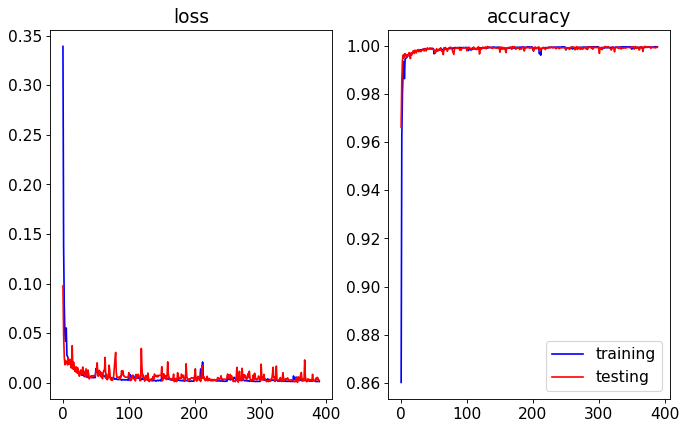

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:04<00:00,  8.07it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


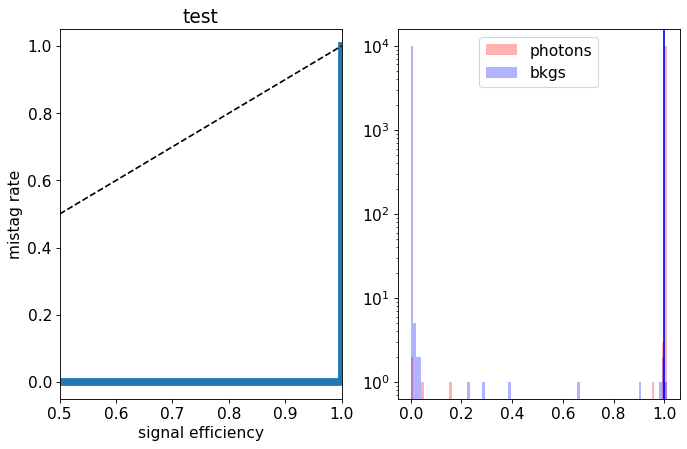

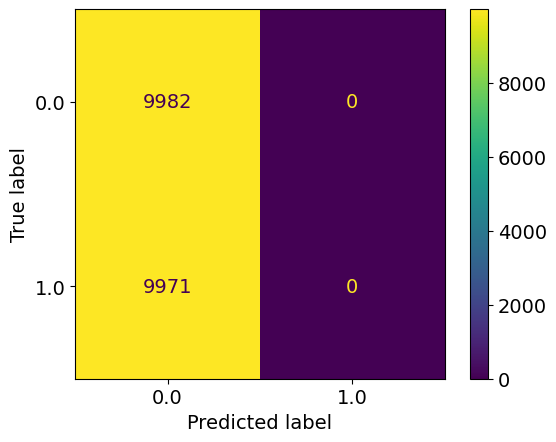

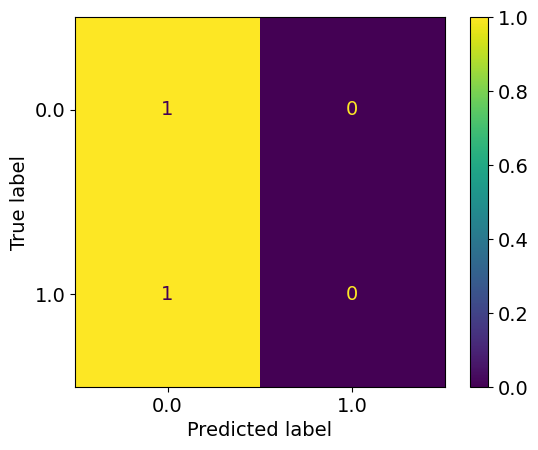

epoch: 390
Learning rate: 9.562935188971195e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:28<00:00,  4.63it/s]


train loss: 0.0011800627230681344
train acc: 0.9996868


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.49it/s]


test loss: 0.001964771790971361
test acc: 0.99964917
epoch: 391
Learning rate: 7.796170675200065e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:30<00:00,  4.38it/s]


train loss: 0.0018380189682300544
train acc: 0.9996241


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.27it/s]


test loss: 0.002470795176490154
test acc: 0.9994487
epoch: 392
Learning rate: 6.195965394678355e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:28<00:00,  4.63it/s]


train loss: 0.0009666446777006981
train acc: 0.99973685


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.50it/s]


test loss: 0.002261969590065272
test acc: 0.99959904
epoch: 393
Learning rate: 4.7686346265840285e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:30<00:00,  4.45it/s]


train loss: 0.001385808998949883
train acc: 0.9997494


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.43it/s]


test loss: 0.002347749561537688
test acc: 0.99959904
epoch: 394
Learning rate: 3.519811393373346e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:28<00:00,  4.62it/s]


train loss: 0.0014289090334237535
train acc: 0.9997118


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.39it/s]


test loss: 0.0031502477297484675
test acc: 0.9994487
epoch: 395
Learning rate: 2.454424229814728e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:30<00:00,  4.40it/s]


train loss: 0.0015710309947538537
train acc: 0.99963665


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.24it/s]


test loss: 0.0026660313655152215
test acc: 0.99949884
epoch: 396
Learning rate: 1.5766777323136415e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:28<00:00,  4.64it/s]


train loss: 0.001248036048592955
train acc: 0.9996868


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.32it/s]


test loss: 0.002484416758699947
test acc: 0.99959904
epoch: 397
Learning rate: 8.90035965291497e-06


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:30<00:00,  4.42it/s]


train loss: 0.0011411837026910811
train acc: 0.9997494


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.51it/s]


test loss: 0.002574193516448824
test acc: 0.99949884
epoch: 398
Learning rate: 3.972087901059462e-06


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:28<00:00,  4.65it/s]


train loss: 0.0012175112368239033
train acc: 0.9996868


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.62it/s]


test loss: 0.0026325596695685525
test acc: 0.99949884
epoch: 399
Learning rate: 1.0014117046612258e-06


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:30<00:00,  4.47it/s]


train loss: 0.0013293054979935258
train acc: 0.9997118


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 11.92it/s]


test loss: 0.0026390011137651043
test acc: 0.99949884


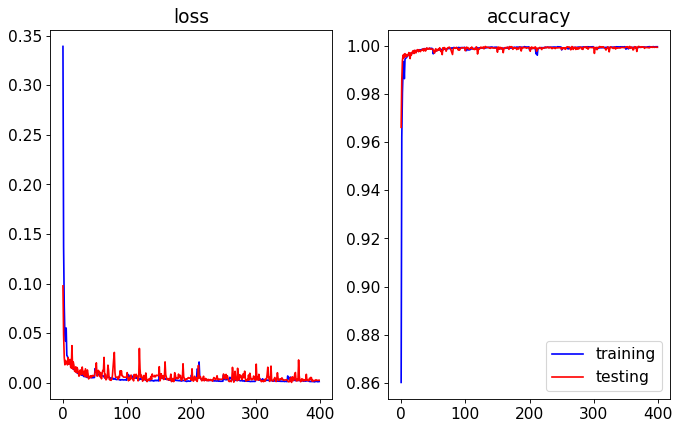

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.56it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


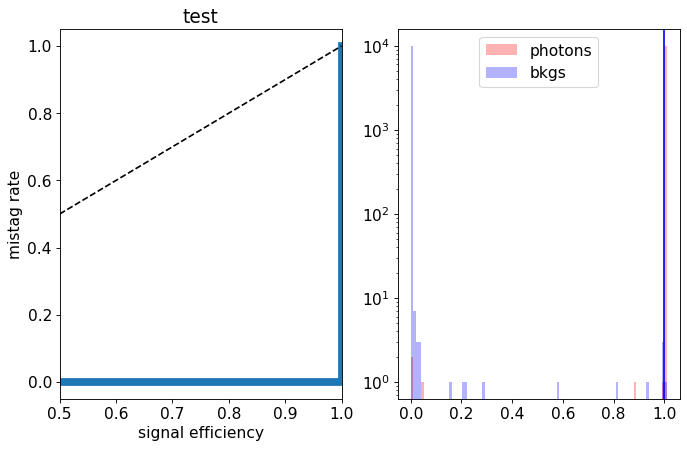

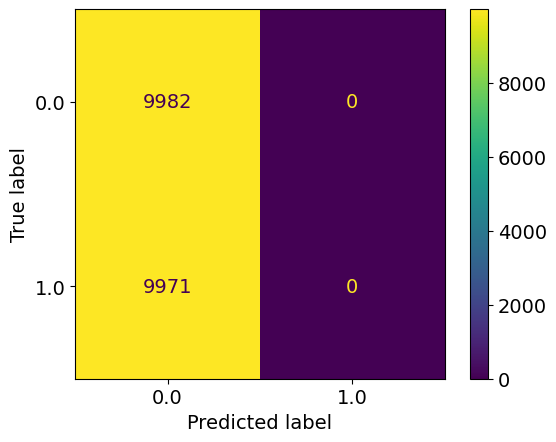

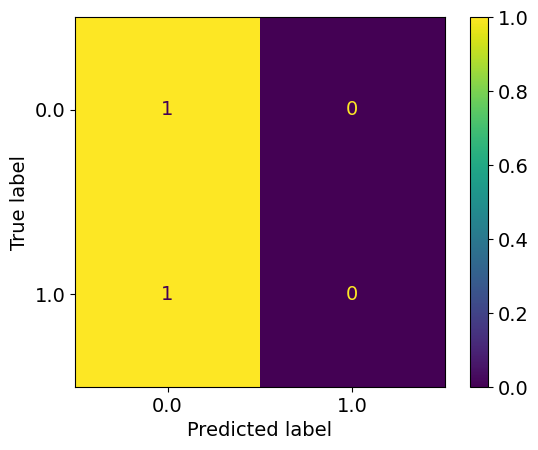

epoch: 400
Learning rate: 5.4965494655778717e-11


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:30<00:00,  4.46it/s]


train loss: 0.0030375918294836455
train acc: 0.999361


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.45it/s]


test loss: 0.02246386778760472
test acc: 0.9979452
epoch: 401
Learning rate: 0.0009990280304188672


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:29<00:00,  4.62it/s]


train loss: 0.0033400513655022276
train acc: 0.99902266


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.60it/s]


test loss: 0.0020873085442557945
test acc: 0.9994487
epoch: 402
Learning rate: 0.0009960866801513866


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:30<00:00,  4.45it/s]


train loss: 0.0027961297839797497
train acc: 0.99934846


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.58it/s]


test loss: 0.006220091110758242
test acc: 0.99919814
epoch: 403
Learning rate: 0.0009911875023977945


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:28<00:00,  4.64it/s]


train loss: 0.0034577834432720513
train acc: 0.9993359


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.14it/s]


test loss: 0.0031140013709470248
test acc: 0.99949884
epoch: 404
Learning rate: 0.0009843498319744624


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:29<00:00,  4.48it/s]


train loss: 0.0028358694051267273
train acc: 0.9993359


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.15it/s]


test loss: 0.022219636018987517
test acc: 0.99784493
epoch: 405
Learning rate: 0.0009756006540427171


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:28<00:00,  4.63it/s]


train loss: 0.0024434171614641977
train acc: 0.99947375


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.40it/s]


test loss: 0.005127974678496409
test acc: 0.999148
epoch: 406
Learning rate: 0.000964974497610736


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:30<00:00,  4.40it/s]


train loss: 0.002319684437135783
train acc: 0.99947375


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.50it/s]


test loss: 0.002470027684904106
test acc: 0.9995489
epoch: 407
Learning rate: 0.0009525132992633268


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:28<00:00,  4.66it/s]


train loss: 0.0036649523482800497
train acc: 0.9991981


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.57it/s]


test loss: 0.001413862830936964
test acc: 0.9996993
epoch: 408
Learning rate: 0.0009382662376573869


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:30<00:00,  4.43it/s]


train loss: 0.00403296330139527
train acc: 0.99913543


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.42it/s]


test loss: 0.0018579688019701543
test acc: 0.9997494
epoch: 409
Learning rate: 0.0009222895394362116


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:28<00:00,  4.64it/s]


train loss: 0.003930096865820024
train acc: 0.99913543


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.45it/s]


test loss: 0.013584973599652455
test acc: 0.9979953


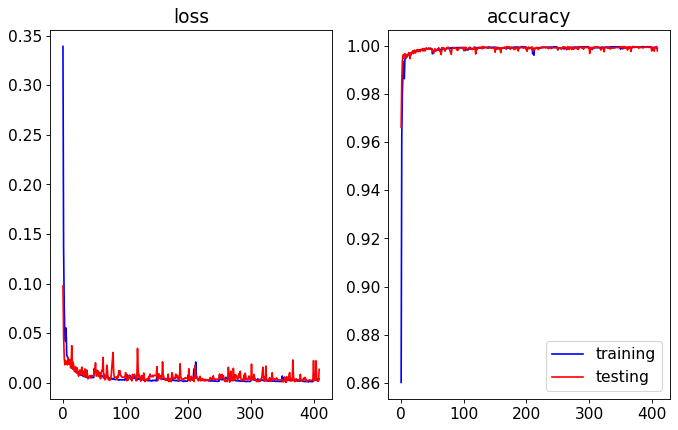

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.18it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


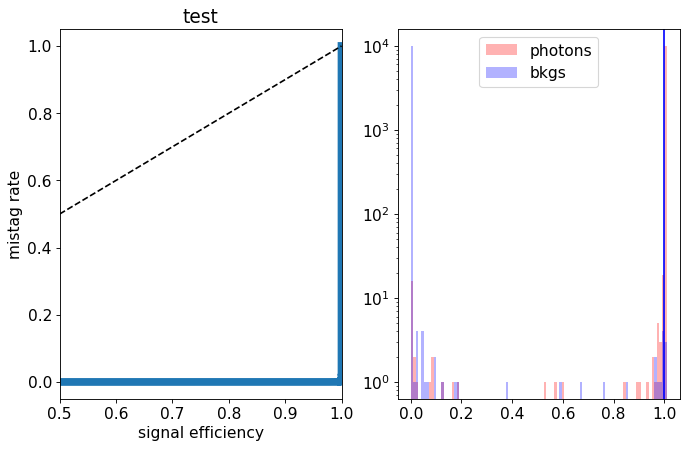

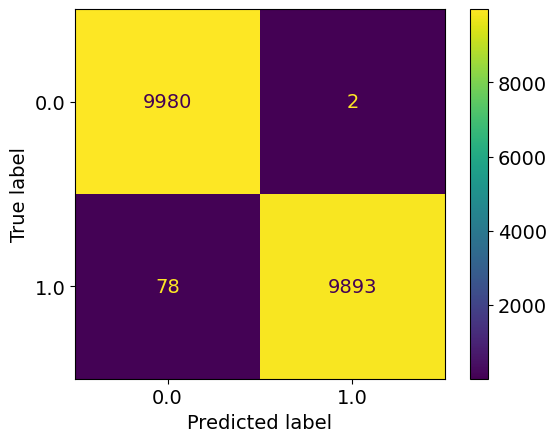

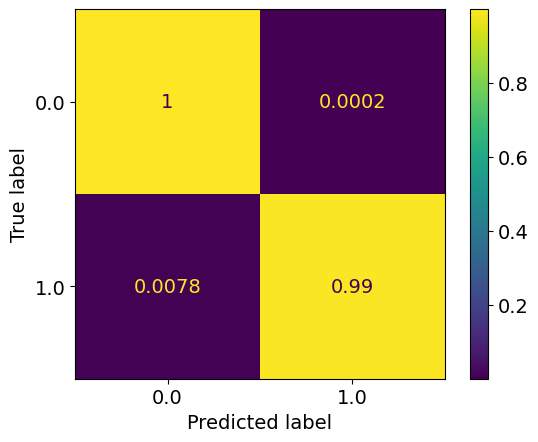

epoch: 410
Learning rate: 0.0009046462573286207


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:29<00:00,  4.62it/s]


train loss: 0.003188116557495634
train acc: 0.9991981


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.39it/s]


test loss: 0.0026324198411737812
test acc: 0.99929833
epoch: 411
Learning rate: 0.0008854060213086441


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:28<00:00,  4.63it/s]


train loss: 0.0024708817069148976
train acc: 0.9994988


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00,  8.83it/s]


test loss: 0.0011416919641183247
test acc: 0.9997494
epoch: 412
Learning rate: 0.0008646447637978249


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:28<00:00,  4.66it/s]


train loss: 0.0037380777201233015
train acc: 0.9991981


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.56it/s]


test loss: 0.0009633163471531217
test acc: 0.99964917
epoch: 413
Learning rate: 0.0008424444199946421


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:29<00:00,  4.48it/s]


train loss: 0.002991697239214566
train acc: 0.99929833


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.37it/s]


test loss: 0.0004953825200688133
test acc: 0.9998496
epoch: 414
Learning rate: 0.0008188926045137141


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:28<00:00,  4.65it/s]


train loss: 0.0031399390423429386
train acc: 0.9992482


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.63it/s]


test loss: 0.0026300927944031827
test acc: 0.99929833
epoch: 415
Learning rate: 0.0007940822656109436


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:30<00:00,  4.46it/s]


train loss: 0.0027670253907875857
train acc: 0.99944866


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.43it/s]


test loss: 0.0024157706972285494
test acc: 0.99959904
epoch: 416
Learning rate: 0.0007681113183592139


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:28<00:00,  4.65it/s]


train loss: 0.0028555297703046086
train acc: 0.999361


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.23it/s]


test loss: 0.0013912466983110588
test acc: 0.99959904
epoch: 417
Learning rate: 0.0007410822582223305


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:29<00:00,  4.47it/s]


train loss: 0.0015845623682578852
train acc: 0.9996742


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.59it/s]


test loss: 0.004943378448885476
test acc: 0.999148
epoch: 418
Learning rate: 0.0007131017565522505


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:28<00:00,  4.69it/s]


train loss: 0.002432758823579885
train acc: 0.99943614


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.61it/s]


test loss: 0.0026135007135838282
test acc: 0.99949884
epoch: 419
Learning rate: 0.0006842802396059906


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:29<00:00,  4.56it/s]


train loss: 0.002069653392353038
train acc: 0.9994111


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 13.27it/s]


test loss: 0.0022885124171334627
test acc: 0.9995489


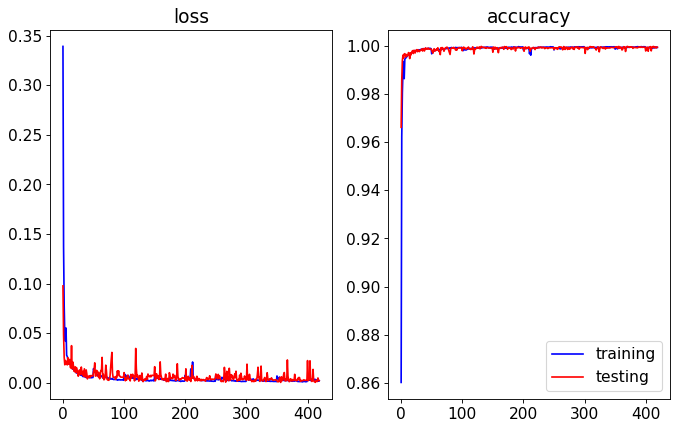

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 13.12it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


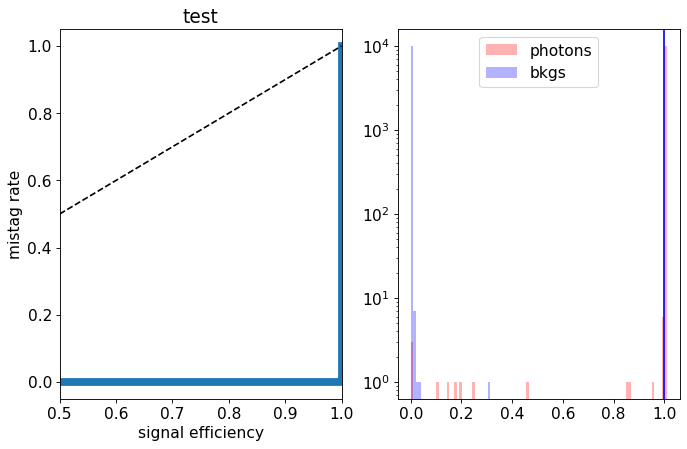

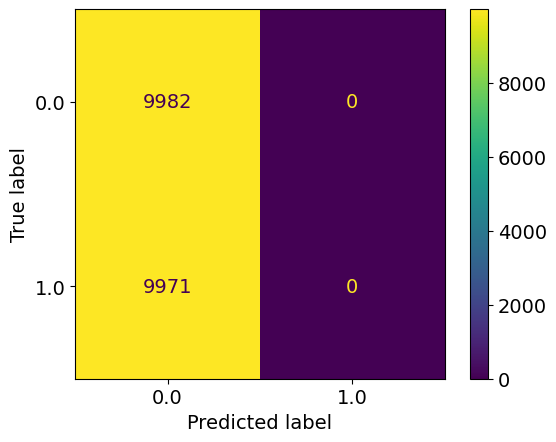

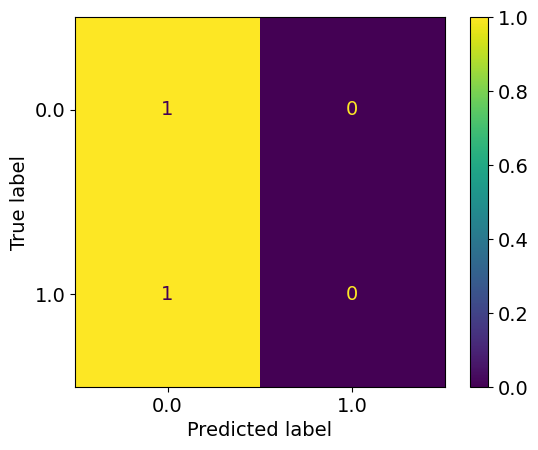

epoch: 420
Learning rate: 0.0006547314527436393


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:27<00:00,  4.93it/s]


train loss: 0.002760387130297543
train acc: 0.99927324


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 13.16it/s]


test loss: 0.005271864613719914
test acc: 0.9990979
epoch: 421
Learning rate: 0.0006245720115273854


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:29<00:00,  4.50it/s]


train loss: 0.0019745862495011662
train acc: 0.9995614


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.58it/s]


test loss: 0.0011034239799302208
test acc: 0.99959904
epoch: 422
Learning rate: 0.0005939209414931715


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:28<00:00,  4.66it/s]


train loss: 0.0022577129857924787
train acc: 0.9995113


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00,  8.51it/s]


test loss: 0.0011784581292483146
test acc: 0.9997494
epoch: 423
Learning rate: 0.0005628992084112805


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:28<00:00,  4.65it/s]


train loss: 0.0020405393242167043
train acc: 0.9995239


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.49it/s]


test loss: 0.008025714871784828
test acc: 0.9989475
epoch: 424
Learning rate: 0.0005316292408897053


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:28<00:00,  4.64it/s]


train loss: 0.0019540970849868805
train acc: 0.9995239


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00,  8.87it/s]


test loss: 0.001681090114826286
test acc: 0.9998496
epoch: 425
Learning rate: 0.0005002344472043639


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:28<00:00,  4.63it/s]


train loss: 0.0022709038458647705
train acc: 0.9995364


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.40it/s]


test loss: 0.0008082063055487865
test acc: 0.9996993
epoch: 426
Learning rate: 0.0004688387282630159


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:28<00:00,  4.63it/s]


train loss: 0.001760025964263625
train acc: 0.99961156


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00,  8.88it/s]


test loss: 0.001894251990701113
test acc: 0.99949884
epoch: 427
Learning rate: 0.0004375659886249827


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:28<00:00,  4.62it/s]


train loss: 0.003039739163063159
train acc: 0.9996241


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.57it/s]


test loss: 0.002720201340205965
test acc: 0.99949884
epoch: 428
Learning rate: 0.00040653964750646005


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:30<00:00,  4.42it/s]


train loss: 0.0024756918702128075
train acc: 0.9994111


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.42it/s]


test loss: 0.0008719456708119793
test acc: 0.9996993
epoch: 429
Learning rate: 0.00037588215170125596


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:29<00:00,  4.62it/s]


train loss: 0.0021928089559036883
train acc: 0.9995865


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.30it/s]


test loss: 0.0010947129176086404
test acc: 0.9997494


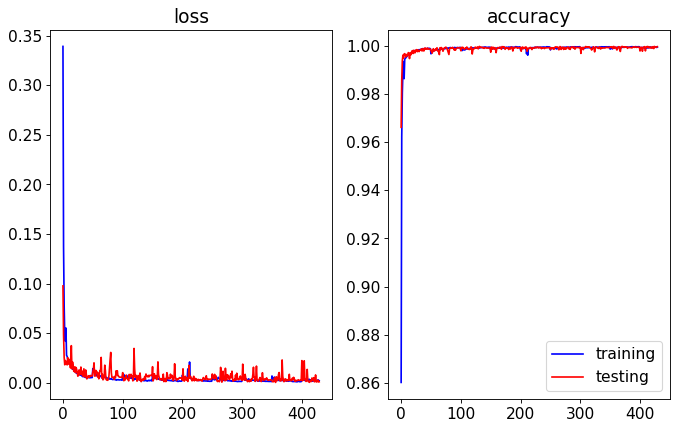

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.46it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


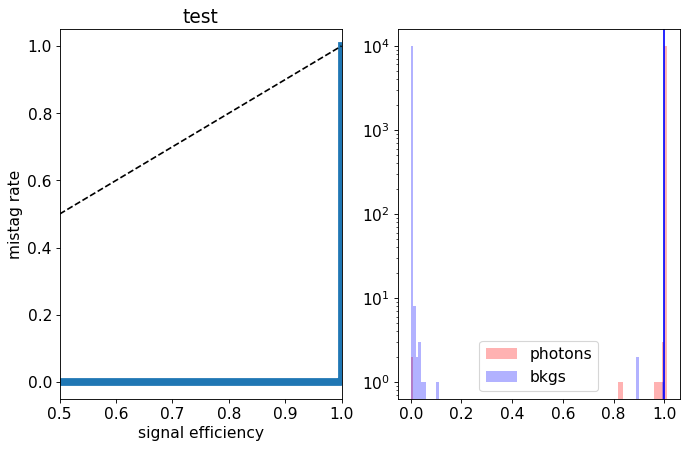

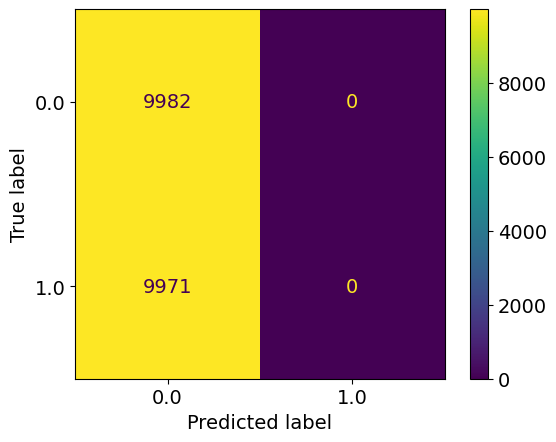

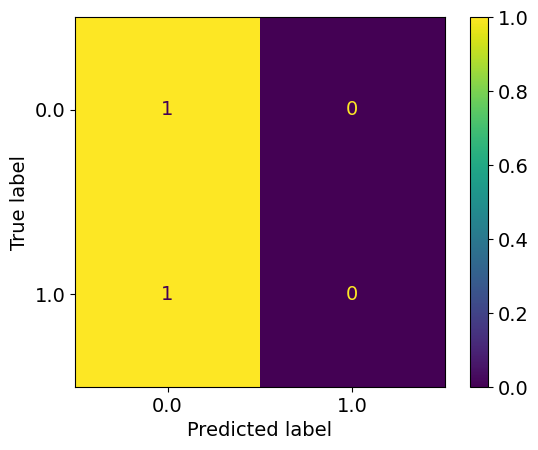

epoch: 430
Learning rate: 0.0003457144923392358


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:30<00:00,  4.45it/s]


train loss: 0.0013892949445202683
train acc: 0.9997118


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.26it/s]


test loss: 0.0012519330750892755
test acc: 0.9997494
epoch: 431
Learning rate: 0.000316155727389609


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:29<00:00,  4.62it/s]


train loss: 0.0017274242478080525
train acc: 0.99961156


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.56it/s]


test loss: 0.0010451793089370734
test acc: 0.9996993
epoch: 432
Learning rate: 0.00028732251179351654


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:30<00:00,  4.44it/s]


train loss: 0.001765093691189964
train acc: 0.99961156


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.56it/s]


test loss: 0.008104521259791794
test acc: 0.9992482
epoch: 433
Learning rate: 0.0002593286370802732


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:28<00:00,  4.66it/s]


train loss: 0.0013760063574232819
train acc: 0.99964917


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.28it/s]


test loss: 0.0036826249020372923
test acc: 0.99929833
epoch: 434
Learning rate: 0.000232284582284187


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:30<00:00,  4.40it/s]


train loss: 0.0011536356864441464
train acc: 0.9996868


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.51it/s]


test loss: 0.0020351475513631897
test acc: 0.99964917
epoch: 435
Learning rate: 0.00020629707793428477


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:28<00:00,  4.64it/s]


train loss: 0.001838980272799772
train acc: 0.9995239


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:04<00:00,  8.40it/s]


test loss: 0.0011189946552560461
test acc: 0.9996993
epoch: 436
Learning rate: 0.00018146868483767426


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:29<00:00,  4.61it/s]


train loss: 0.0014654188564725075
train acc: 0.9996241


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.43it/s]


test loss: 0.003684040349728481
test acc: 0.99959904
epoch: 437
Learning rate: 0.00015789738931889407


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:28<00:00,  4.65it/s]


train loss: 0.0012457464752705122
train acc: 0.99973685


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00,  8.81it/s]


test loss: 0.001566702819233406
test acc: 0.9997494
epoch: 438
Learning rate: 0.00013567621651265594


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:29<00:00,  4.62it/s]


train loss: 0.0013190119320078432
train acc: 0.9996868


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.22it/s]


test loss: 0.0017308883055949219
test acc: 0.9997494
epoch: 439
Learning rate: 0.00011489286323613807


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:30<00:00,  4.39it/s]


train loss: 0.0013351568266328408
train acc: 0.9996617


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.28it/s]


test loss: 0.001846841235929509
test acc: 0.99959904


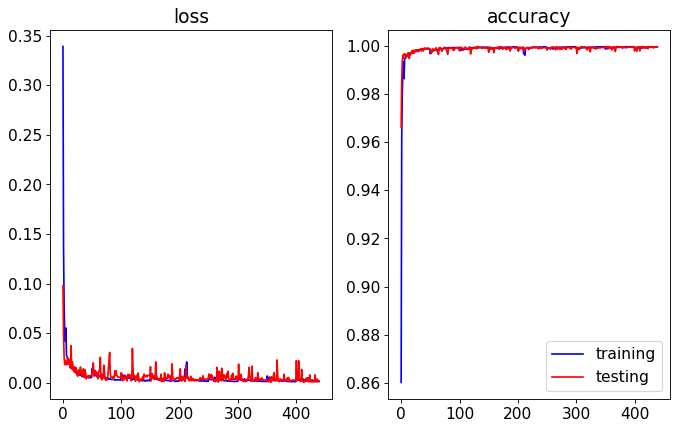

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.34it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


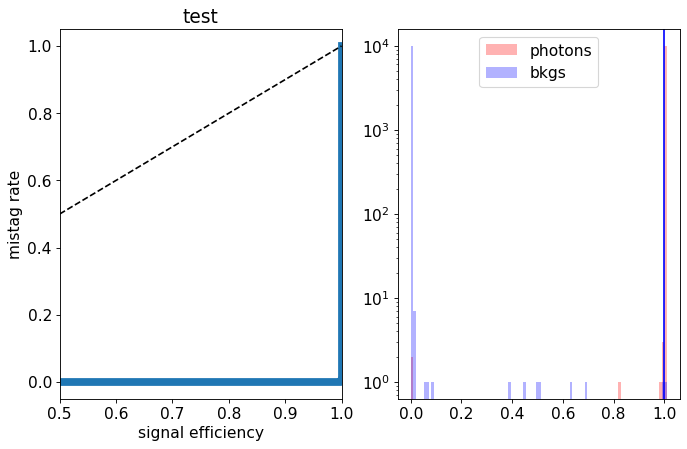

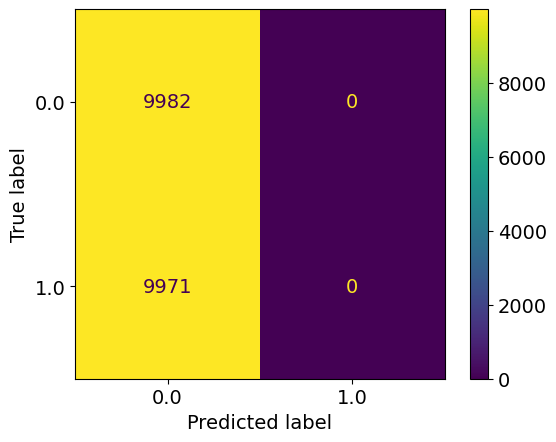

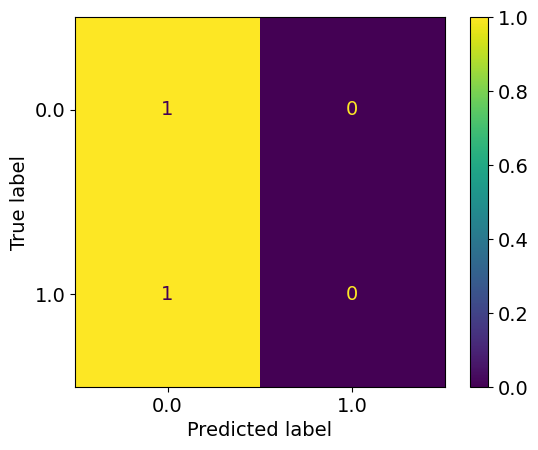

epoch: 440
Learning rate: 9.562935188971195e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:29<00:00,  4.62it/s]


train loss: 0.0016238823170726337
train acc: 0.9996241


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.57it/s]


test loss: 0.0015140521439239848
test acc: 0.9997494
epoch: 441
Learning rate: 7.796170675200065e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:30<00:00,  4.40it/s]


train loss: 0.001435883345632845
train acc: 0.9996993


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.13it/s]


test loss: 0.0015777750709190682
test acc: 0.9996993
epoch: 442
Learning rate: 6.195965394678355e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:29<00:00,  4.59it/s]


train loss: 0.0016905817064707428
train acc: 0.99961156


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.19it/s]


test loss: 0.001706333943630704
test acc: 0.9996993
epoch: 443
Learning rate: 4.7686346265840285e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:30<00:00,  4.45it/s]


train loss: 0.0012239422422857349
train acc: 0.9996868


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.64it/s]


test loss: 0.0016696370264679373
test acc: 0.9996993
epoch: 444
Learning rate: 3.519811393373346e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:28<00:00,  4.64it/s]


train loss: 0.0021105488644366233
train acc: 0.9995113


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.34it/s]


test loss: 0.0016043222933459986
test acc: 0.99964917
epoch: 445
Learning rate: 2.454424229814728e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:30<00:00,  4.45it/s]


train loss: 0.0010087029874210121
train acc: 0.99976194


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.36it/s]


test loss: 0.0016294372344470894
test acc: 0.9996993
epoch: 446
Learning rate: 1.5766777323136415e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:29<00:00,  4.59it/s]


train loss: 0.001340993313560694
train acc: 0.99963665


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:04<00:00,  8.41it/s]


test loss: 0.0016357971624161975
test acc: 0.9996993
epoch: 447
Learning rate: 8.90035965291497e-06


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:29<00:00,  4.60it/s]


train loss: 0.001238581330891242
train acc: 0.99973685


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 11.92it/s]


test loss: 0.0016614170893793168
test acc: 0.9996993
epoch: 448
Learning rate: 3.972087901059462e-06


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:29<00:00,  4.61it/s]


train loss: 0.001219290998662147
train acc: 0.99973685


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00,  8.72it/s]


test loss: 0.0016724357483722644
test acc: 0.9996993
epoch: 449
Learning rate: 1.0014117046612258e-06


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:28<00:00,  4.66it/s]


train loss: 0.0012396333252653092
train acc: 0.9996742


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.76it/s]


test loss: 0.001678187416872028
test acc: 0.9996993


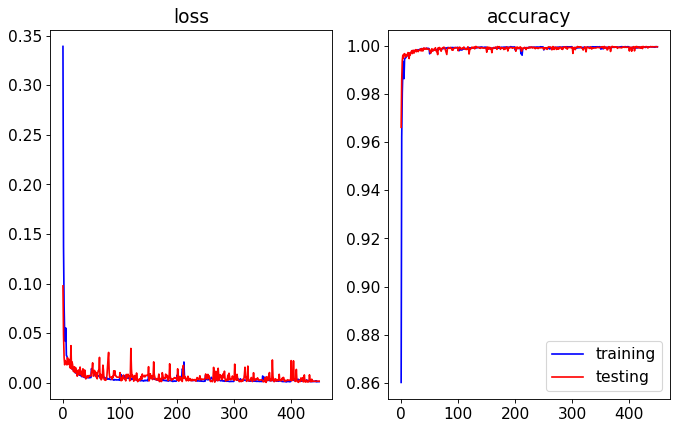

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.63it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


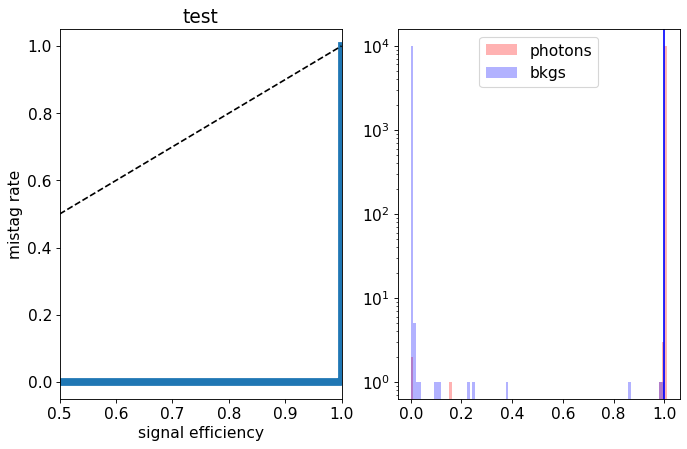

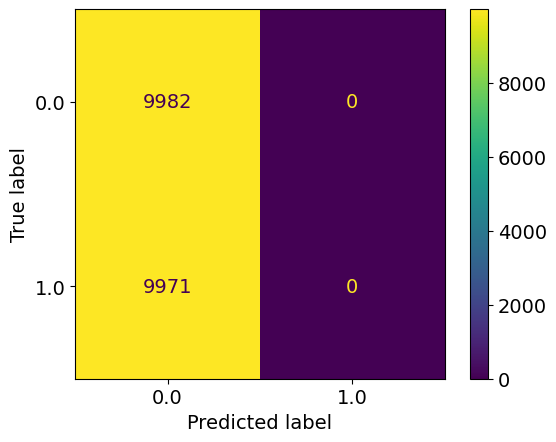

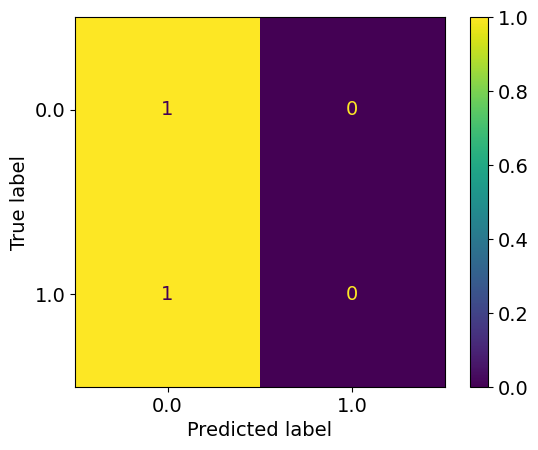

epoch: 450
Learning rate: 5.4965494655778717e-11


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:29<00:00,  4.50it/s]


train loss: 0.002729664648127051
train acc: 0.99944866


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.31it/s]


test loss: 0.005239852015421144
test acc: 0.99919814
epoch: 451
Learning rate: 0.0009990280304188672


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:28<00:00,  4.67it/s]


train loss: 0.0040654582942318196
train acc: 0.9990603


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.50it/s]


test loss: 0.005863688079585927
test acc: 0.99919814
epoch: 452
Learning rate: 0.0009960866801513866


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:29<00:00,  4.49it/s]


train loss: 0.0036277461477942806
train acc: 0.9992357


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.55it/s]


test loss: 0.0037785987492564826
test acc: 0.99934846
epoch: 453
Learning rate: 0.0009911875023977945


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:28<00:00,  4.65it/s]


train loss: 0.0040828001538645384
train acc: 0.999173


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.37it/s]


test loss: 0.003027574725450677
test acc: 0.9993986
epoch: 454
Learning rate: 0.0009843498319744624


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:29<00:00,  4.50it/s]


train loss: 0.0034366192261070716
train acc: 0.99934846


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.37it/s]


test loss: 0.0019545780501152264
test acc: 0.99959904
epoch: 455
Learning rate: 0.0009756006540427171


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:28<00:00,  4.66it/s]


train loss: 0.00450426414980355
train acc: 0.9990352


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.63it/s]


test loss: 0.010514929516872365
test acc: 0.9982459
epoch: 456
Learning rate: 0.000964974497610736


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:29<00:00,  4.48it/s]


train loss: 0.0031161172404080245
train acc: 0.9992357


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.34it/s]


test loss: 0.0017746115017724
test acc: 0.9996993
epoch: 457
Learning rate: 0.0009525132992633268


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:28<00:00,  4.65it/s]


train loss: 0.003445661515662092
train acc: 0.99928576


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.60it/s]


test loss: 0.0029259344110059834
test acc: 0.9994487
epoch: 458
Learning rate: 0.0009382662376573869


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:29<00:00,  4.49it/s]


train loss: 0.0024078094442193648
train acc: 0.99944866


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.61it/s]


test loss: 0.002083755868516149
test acc: 0.9993986
epoch: 459
Learning rate: 0.0009222895394362116


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:28<00:00,  4.64it/s]


train loss: 0.002039555287637995
train acc: 0.99944866


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00,  8.89it/s]


test loss: 0.0024316660248947844
test acc: 0.9995489


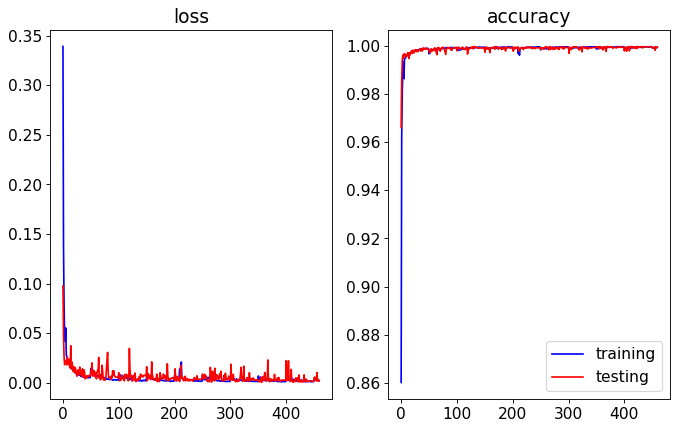

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.67it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


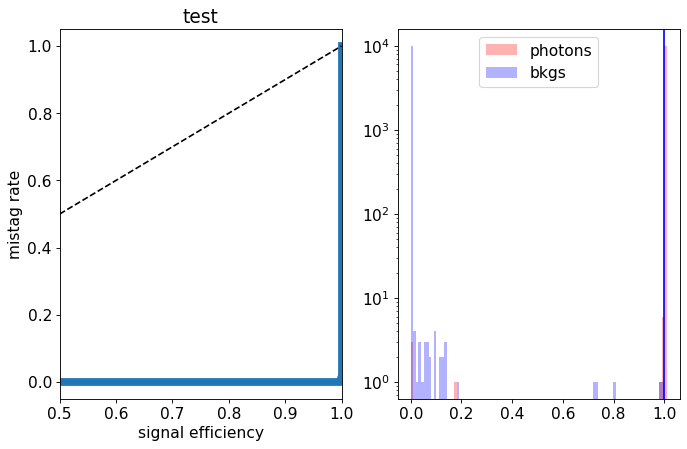

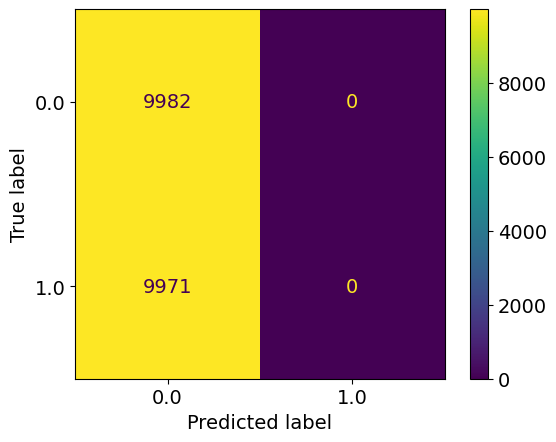

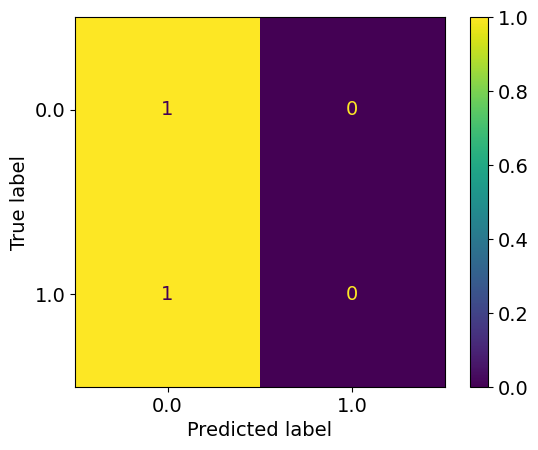

epoch: 460
Learning rate: 0.0009046462573286207


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:28<00:00,  4.63it/s]


train loss: 0.0024096393056818387
train acc: 0.99948627


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.21it/s]


test loss: 0.0017648397084617975
test acc: 0.9997494
epoch: 461
Learning rate: 0.0008854060213086441


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:29<00:00,  4.47it/s]


train loss: 0.0029046324315121393
train acc: 0.9993985


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.60it/s]


test loss: 0.002065423502177351
test acc: 0.9996993
epoch: 462
Learning rate: 0.0008646447637978249


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:28<00:00,  4.65it/s]


train loss: 0.004150223564397832
train acc: 0.9992482


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.39it/s]


test loss: 0.010516323405275078
test acc: 0.99844635
epoch: 463
Learning rate: 0.0008424444199946421


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:30<00:00,  4.42it/s]


train loss: 0.0027249401932410242
train acc: 0.99943614


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.15it/s]


test loss: 0.0013717542331225436
test acc: 0.99979955
epoch: 464
Learning rate: 0.0008188926045137141


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:29<00:00,  4.60it/s]


train loss: 0.002607516738835465
train acc: 0.9994111


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.19it/s]


test loss: 0.0038051039223277296
test acc: 0.99929833
epoch: 465
Learning rate: 0.0007940822656109436


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:30<00:00,  4.32it/s]


train loss: 0.0022434892226054
train acc: 0.9994988


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.16it/s]


test loss: 0.0025581287360242817
test acc: 0.9994487
epoch: 466
Learning rate: 0.0007681113183592139


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:29<00:00,  4.62it/s]


train loss: 0.0021449682914062036
train acc: 0.9995364


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.31it/s]


test loss: 0.011197659329640368
test acc: 0.9985466
epoch: 467
Learning rate: 0.0007410822582223305


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:29<00:00,  4.47it/s]


train loss: 0.0021107238459454414
train acc: 0.9995239


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.58it/s]


test loss: 0.002466100415232287
test acc: 0.9995489
epoch: 468
Learning rate: 0.0007131017565522505


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:28<00:00,  4.63it/s]


train loss: 0.0017586868900189958
train acc: 0.9995489


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.63it/s]


test loss: 0.00682543895360207
test acc: 0.99904776
epoch: 469
Learning rate: 0.0006842802396059906


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:29<00:00,  4.47it/s]


train loss: 0.002915353969598671
train acc: 0.99932337


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.27it/s]


test loss: 0.0025366757070857966
test acc: 0.99959904


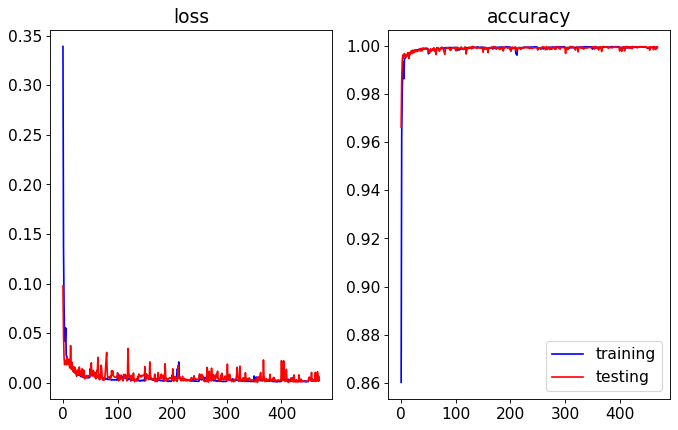

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.63it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


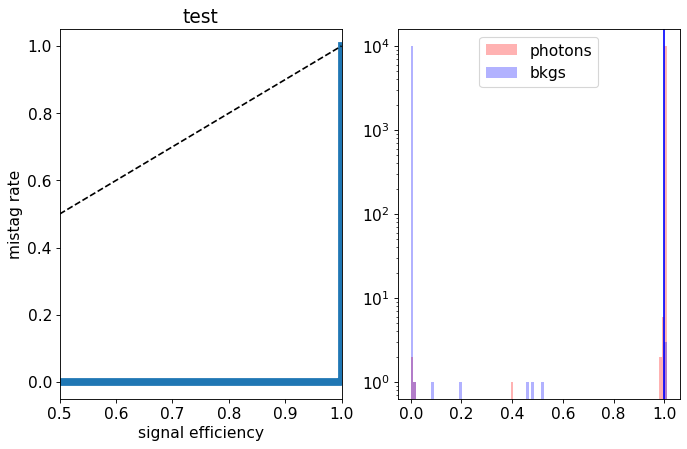

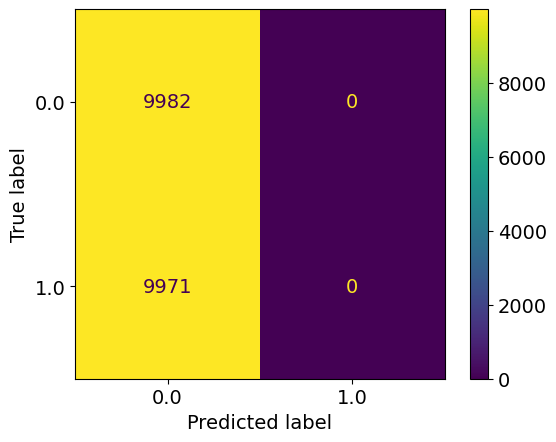

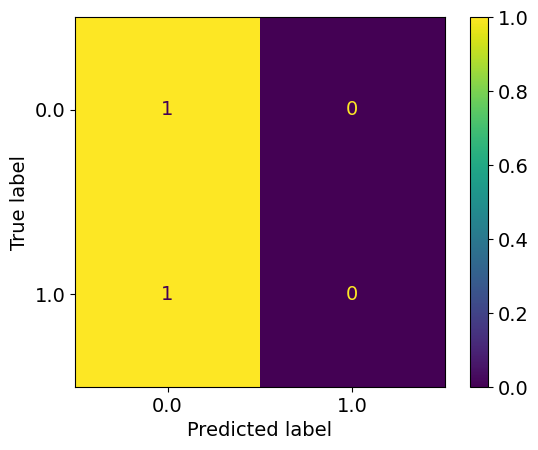

epoch: 470
Learning rate: 0.0006547314527436393


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:29<00:00,  4.48it/s]


train loss: 0.0027651752465480154
train acc: 0.999386


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.55it/s]


test loss: 0.009172368364610066
test acc: 0.9986969
epoch: 471
Learning rate: 0.0006245720115273854


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:28<00:00,  4.65it/s]


train loss: 0.002603289362937108
train acc: 0.99943614


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.77it/s]


test loss: 0.02294862492216426
test acc: 0.997444
epoch: 472
Learning rate: 0.0005939209414931715


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:29<00:00,  4.49it/s]


train loss: 0.0021980026086471775
train acc: 0.99943614


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.53it/s]


test loss: 0.03128107844004296
test acc: 0.9971934
epoch: 473
Learning rate: 0.0005628992084112805


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:28<00:00,  4.65it/s]


train loss: 0.0023163575701326054
train acc: 0.9995364


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.47it/s]


test loss: 0.03247701796254218
test acc: 0.9963414
epoch: 474
Learning rate: 0.0005316292408897053


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:30<00:00,  4.45it/s]


train loss: 0.002309866675693514
train acc: 0.99948627


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.32it/s]


test loss: 0.007633017692996572
test acc: 0.99919814
epoch: 475
Learning rate: 0.0005002344472043639


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:28<00:00,  4.66it/s]


train loss: 0.0023271776760749184
train acc: 0.99948627


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.23it/s]


test loss: 0.0016183530203318314
test acc: 0.99979955
epoch: 476
Learning rate: 0.0004688387282630159


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:30<00:00,  4.39it/s]


train loss: 0.0023138165175494766
train acc: 0.999574


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.64it/s]


test loss: 0.0018448745184524472
test acc: 0.9993986
epoch: 477
Learning rate: 0.0004375659886249827


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:28<00:00,  4.65it/s]


train loss: 0.0015203694014444273
train acc: 0.99963665


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.35it/s]


test loss: 0.003927321425072324
test acc: 0.99919814
epoch: 478
Learning rate: 0.00040653964750646005


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:30<00:00,  4.41it/s]


train loss: 0.0020193060989376096
train acc: 0.9996241


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.44it/s]


test loss: 0.005888978826704563
test acc: 0.99934846
epoch: 479
Learning rate: 0.00037588215170125596


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:28<00:00,  4.62it/s]


train loss: 0.0020112872327117696
train acc: 0.99961156


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.38it/s]


test loss: 0.0026638504011807064
test acc: 0.9994487


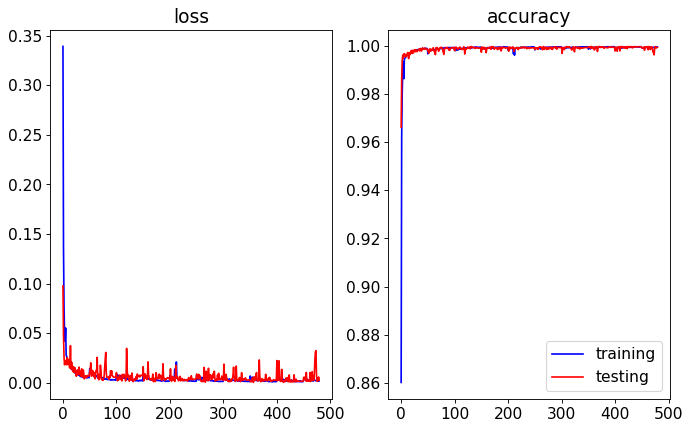

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:04<00:00,  8.12it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


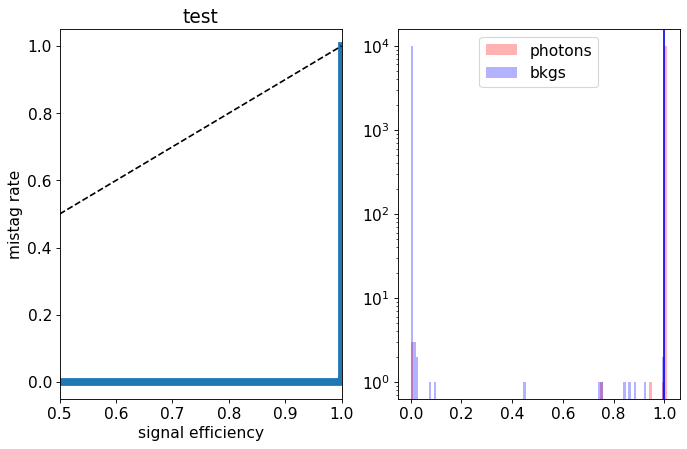

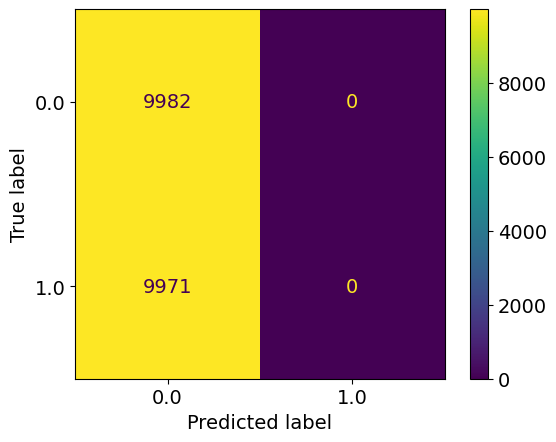

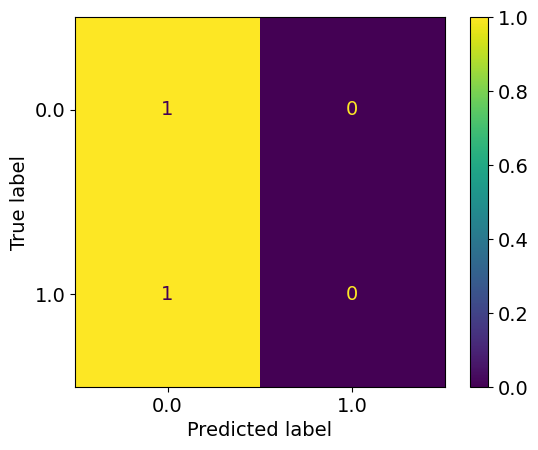

epoch: 480
Learning rate: 0.0003457144923392358


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:29<00:00,  4.60it/s]


train loss: 0.001846567303203559
train acc: 0.99963665


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.60it/s]


test loss: 0.0019978041190424627
test acc: 0.9997494
epoch: 481
Learning rate: 0.000316155727389609


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:30<00:00,  4.43it/s]


train loss: 0.0015482857344923375
train acc: 0.9996617


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.40it/s]


test loss: 0.0031083098883115633
test acc: 0.99934846
epoch: 482
Learning rate: 0.00028732251179351654


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:28<00:00,  4.66it/s]


train loss: 0.0013294922784328929
train acc: 0.9996241


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.53it/s]


test loss: 0.0025114878506748003
test acc: 0.9995489
epoch: 483
Learning rate: 0.0002593286370802732


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:30<00:00,  4.45it/s]


train loss: 0.001688842646177506
train acc: 0.99946123


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.64it/s]


test loss: 0.0017234389672239846
test acc: 0.99979955
epoch: 484
Learning rate: 0.000232284582284187


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:28<00:00,  4.67it/s]


train loss: 0.0015840865435980524
train acc: 0.99959904


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.56it/s]


test loss: 0.0037770219385404396
test acc: 0.9994487
epoch: 485
Learning rate: 0.00020629707793428477


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:29<00:00,  4.47it/s]


train loss: 0.0013484728528490098
train acc: 0.9996993


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.67it/s]


test loss: 0.003727900170969859
test acc: 0.9993986
epoch: 486
Learning rate: 0.00018146868483767426


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:28<00:00,  4.65it/s]


train loss: 0.0012711004643251862
train acc: 0.9997494


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.66it/s]


test loss: 0.004140248360210146
test acc: 0.99934846
epoch: 487
Learning rate: 0.00015789738931889407


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:29<00:00,  4.51it/s]


train loss: 0.0015475348482684253
train acc: 0.9995614


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.73it/s]


test loss: 0.005880145553816646
test acc: 0.9992482
epoch: 488
Learning rate: 0.00013567621651265594


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:28<00:00,  4.65it/s]


train loss: 0.0016009415507983588
train acc: 0.9996617


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.73it/s]


test loss: 0.0032248599481122914
test acc: 0.9994487
epoch: 489
Learning rate: 0.00011489286323613807


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:29<00:00,  4.52it/s]


train loss: 0.0013084171086622735
train acc: 0.9996241


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.57it/s]


test loss: 0.002581339087593814
test acc: 0.99959904


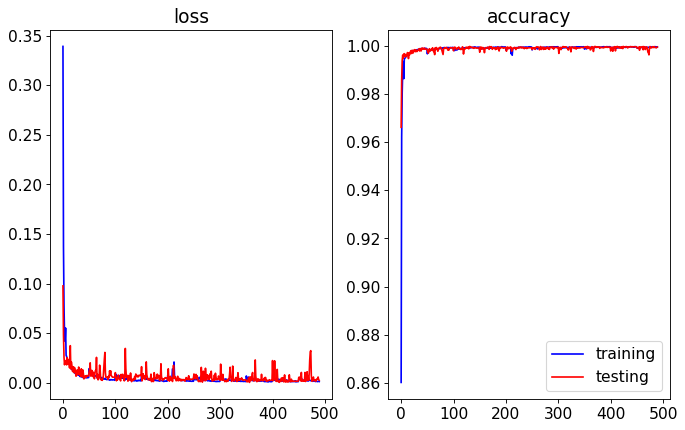

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.43it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


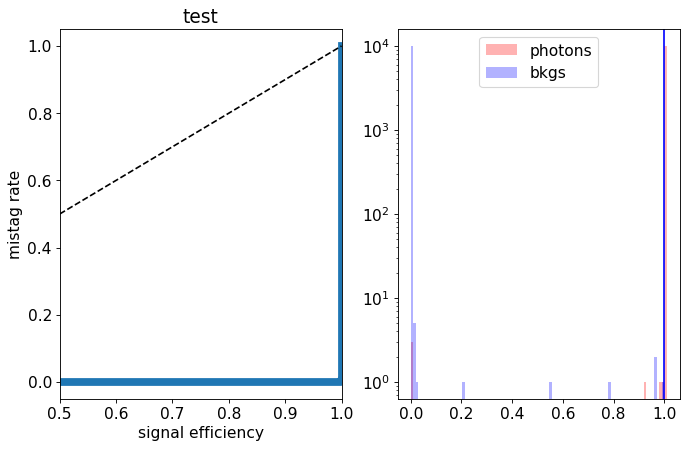

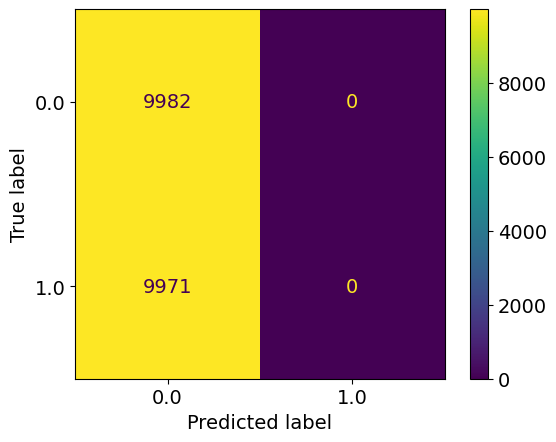

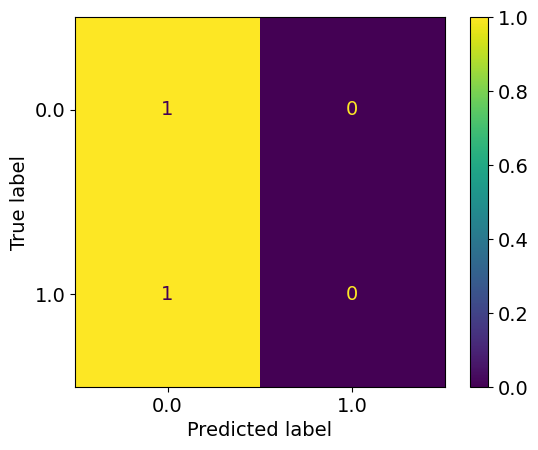

epoch: 490
Learning rate: 9.562935188971195e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:28<00:00,  4.68it/s]


train loss: 0.0013502599430850425
train acc: 0.99964917


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00,  8.86it/s]


test loss: 0.0026950858545758388
test acc: 0.99964917
epoch: 491
Learning rate: 7.796170675200065e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:28<00:00,  4.68it/s]


train loss: 0.001358728904037957
train acc: 0.9996993


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.54it/s]


test loss: 0.004017122706152854
test acc: 0.99934846
epoch: 492
Learning rate: 6.195965394678355e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:29<00:00,  4.50it/s]


train loss: 0.0012430717066688804
train acc: 0.9997243


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.73it/s]


test loss: 0.0031005140566267926
test acc: 0.9994487
epoch: 493
Learning rate: 4.7686346265840285e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:28<00:00,  4.65it/s]


train loss: 0.0012376037702779286
train acc: 0.99976194


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.68it/s]


test loss: 0.004527419900551307
test acc: 0.9992482
epoch: 494
Learning rate: 3.519811393373346e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:29<00:00,  4.50it/s]


train loss: 0.0012660499830702459
train acc: 0.99973685


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.68it/s]


test loss: 0.0055188629878129
test acc: 0.9992482
epoch: 495
Learning rate: 2.454424229814728e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:28<00:00,  4.68it/s]


train loss: 0.001127671454581439
train acc: 0.9996868


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.53it/s]


test loss: 0.005281287779725995
test acc: 0.9992482
epoch: 496
Learning rate: 1.5766777323136415e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:29<00:00,  4.51it/s]


train loss: 0.0013592522740196848
train acc: 0.99959904


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.62it/s]


test loss: 0.004894012437766088
test acc: 0.9992482
epoch: 497
Learning rate: 8.90035965291497e-06


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:28<00:00,  4.66it/s]


train loss: 0.0011241494094744002
train acc: 0.9996868


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.52it/s]


test loss: 0.0044882802979861304
test acc: 0.9992482
epoch: 498
Learning rate: 3.972087901059462e-06


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:29<00:00,  4.48it/s]


train loss: 0.001275682115667576
train acc: 0.99976194


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.63it/s]


test loss: 0.004468374012957871
test acc: 0.9992482
epoch: 499
Learning rate: 1.0014117046612258e-06


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:28<00:00,  4.67it/s]


train loss: 0.0010795904603745933
train acc: 0.999787


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.41it/s]


test loss: 0.004461312035427331
test acc: 0.9992482


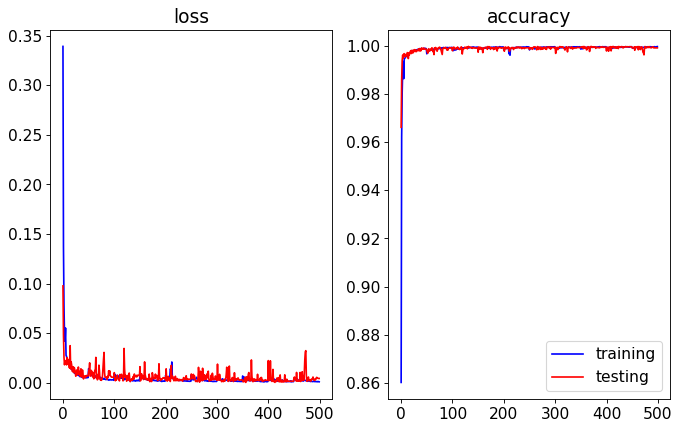

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.68it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


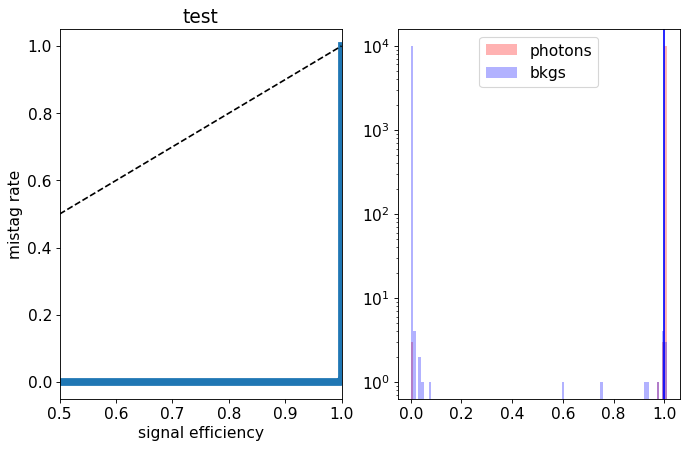

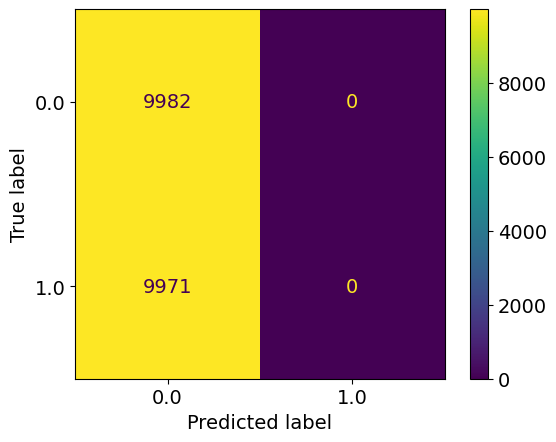

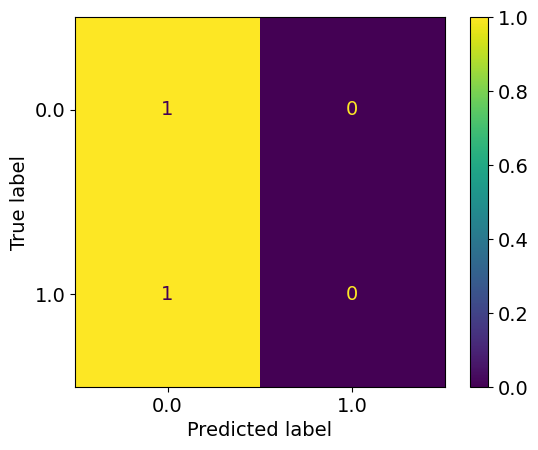

In [16]:
from tqdm import tqdm as tqdm

## OUTPUT directory
checkpoint_dir = out_dir
os.makedirs(checkpoint_dir, exist_ok=True)


nepoch=500
best_loss = 99999999
best_acc = 0.
losst = []
lossv = []
acct = []
accv = []
epochs = []
for epoch in range(nepoch):
    print ('epoch:',epoch)
    print("Learning rate:", optimizer.param_groups[0]['lr'])
    loss_t, acc_t = train(epoch)
    losst.append(loss_t)
    acct.append(acc_t)
    loss_v, acc_v = test(epoch)
    loss_epoch = loss_v
    lossv.append(loss_epoch)
    accv.append(acc_v)
    epochs.append(epoch)

    
     
    
    checkpoint = {
    'epoch': epoch + 1,
    'state_dict': model.state_dict(),
    'optimizer': optimizer.state_dict()
    }
    checkpoint_file = 'model_epoch_%i.pth.tar' % ( epoch )
    torch.save(checkpoint,
                   os.path.join(checkpoint_dir,checkpoint_file ))
    
#     if loss_epoch < best_loss:
#         best_loss = loss_epoch
#         print('new best test loss:',best_loss)
#         torch.save(checkpoint,
#                    os.path.join(checkpoint_dir,'model_checkpoint_best.pth.tar' ))
    
    
    if acc_v > best_acc:
        print('new best acc:',acc_v)
        best_acc = acc_v
        torch.save(checkpoint,
                   os.path.join(checkpoint_dir,'model_checkpoint_bestacc.pth.tar' ))
    
    if ((epoch+1)%10 == 0):
        fig, (ax0,ax1) = plt.subplots(1,2,figsize=(10, 6),dpi=80)
        
        ax0.plot(np.array(epochs),np.array(losst),c='b',label='training')
        ax0.plot(np.array(epochs),np.array(lossv),c='r',label='testing')
        ax0.title.set_text("loss")
        #if ((epoch+1) == nepoch):
        #    plt.savefig('%s/TrainvsValLoss_ep%d.png'%(plot_dir, epoch), bbox_inches='tight')
        #plt.legend()
        #plt.show()
        ax1.plot(np.array(epochs),np.array(acct),c='b',label='training')
        ax1.plot(np.array(epochs),np.array(accv),c='r',label='testing')
        ax1.title.set_text("accuracy")
        plt.legend()
        #if ((epoch+1) == nepoch):
        #    plt.savefig('%s/TrainvsValLoss_ep%d.png'%(plot_dir, epoch), bbox_inches='tight')
        plt.show()
        
        
        model.eval()
        scores = []
        trues = []
        true_preds, num_preds = 0., 0.
        for data in tqdm(testloader): ### change to loaderDNN for DNN
                datax, label, masks, info3d = data[0].to(device), data[1].to(device), data[2].to(device), data[3].to(device)
                optimizer.zero_grad()
                #label = label.to(torch.long).squeeze()
                result = model(datax, masks, info3d)
                scores.append(torch.exp(result)[:,1].detach().cpu().flatten().numpy())
                trues.append(label.detach().cpu().numpy().flatten())
        
        
        truesa = np.hstack(trues)
        scoresa = np.hstack(scores)
        fpr, tpr, thresholds = metrics.roc_curve(truesa, scoresa, pos_label=1)
        aucv = metrics.auc(fpr, tpr)

        tpr90,fpr90,threshold90 = 0,0,0
        for i,j,k in zip(tpr,fpr,thresholds):
            if i >0.99:
                tpr90 = i
                fpr90 = j
                threshold90 = k
                break

        fig, (ax0,ax1) = plt.subplots(1,2,figsize=(10, 6),dpi=80)
        plt.rcParams['font.size'] = '14'
        ax0.plot(tpr,fpr, linewidth=7.0, label= "AUC:"+str(round(aucv,3))+" eff:"+str(round(tpr90,3))+" @ bkg rejection rate:"+str(round(1-fpr90,3)))
        ax0.set_xlabel("signal efficiency")
        ax0.set_ylabel("mistag rate")
        ax0.set_xlim([0.5,1])
        ax0.plot([0.,1], [0.,1], 'k--')
        ax0.title.set_text("test")
        plt.legend()
        #ax.text(0.6,0.6,aucv,)
        #plt.yscale("log")
        
        ax1.hist(scoresa[truesa == 1],bins=100, range=[0,1.01], label='photons',linewidth=2.0, color="r" , alpha=0.3)
        ax1.hist(scoresa[truesa == 0],bins=100, range=[0,1.01], label='bkgs',linewidth=2.0, color="b", alpha=0.3 )
        ax1.axvline(threshold90,c="b")
        plt.yscale("log")
        plt.legend()
        plt.show()

        
        
        
        
        
        ConfusionMatrixDisplay.from_predictions(np.hstack(trues), np.where(np.hstack(scores)>threshold90, 1, 0))
        plt.show()
        ConfusionMatrixDisplay.from_predictions(np.hstack(trues), np.where(np.hstack(scores)>threshold90, 1, 0), normalize="true")
        plt.show()
        

In [17]:
#print(epoch_size)

## Inference with model of last epoch

### Confusion matrix and Accuracy on test dataset

In [16]:
device = torch.device('cuda:1')
model.to(device)
model.eval()
scores = []
trues = []
true_preds, num_preds = 0., 0.
for data in tqdm(testloader): ### change to loaderDNN for DNN
        datax, label, masks, info3d = data[0].to(device), data[1].to(device), data[2].to(device), data[3].to(device)
        optimizer.zero_grad()
        #label = label.to(torch.long).squeeze()
        result = model(datax, masks, info3d)
        scores.append(torch.exp(result)[:,1].detach().cpu().flatten().numpy())
        trues.append(label.detach().cpu().numpy().flatten())
        #break

  6%|██████████▎                                                                                                                                                                     | 2/34 [00:02<00:42,  1.33s/it]/opt/exp_soft/vo.gridcl.fr/software/torch/2.0.1/py311-cuda117/lib/python3.11/site-packages/torch/nn/modules/module.py:1501: UserWarning: FALLBACK path has been taken inside: runCudaFusionGroup. This is an indication that codegen Failed for some reason.
To debug try disable codegen fallback path via setting the env variable `export PYTORCH_NVFUSER_DISABLE=fallback`
 (Triggered internally at ../third_party/nvfuser/csrc/manager.cpp:335.)
  return forward_call(*args, **kwargs)
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:05<00:00,  5.98it/s]


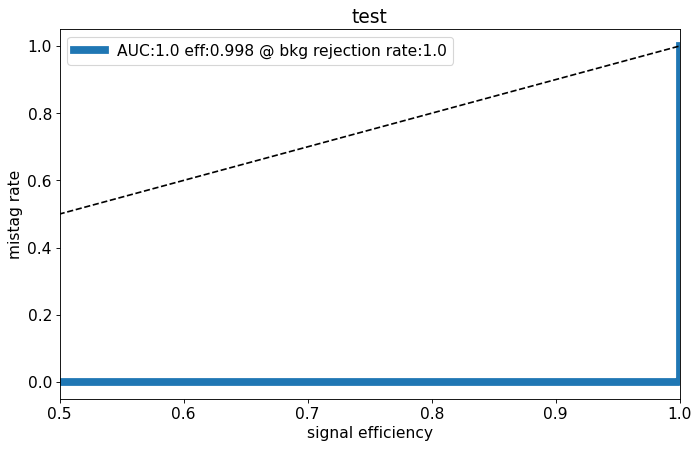

In [19]:
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(np.hstack(trues), np.hstack(scores), pos_label=1)
aucv = metrics.auc(fpr, tpr)

tpr90,fpr90,threshold90 = 0,0,0
for i,j,k in zip(tpr,fpr,thresholds):
    if i >0.99:
        tpr90 = i
        fpr90 = j
        threshold90 = k
        break

fig, ax = plt.subplots(figsize=(10, 6),dpi=80)
plt.rcParams['font.size'] = '14'
ax.plot(tpr,fpr, linewidth=7.0, label= "AUC:"+str(round(aucv,3))+" eff:"+str(round(tpr90,3))+" @ bkg rejection rate:"+str(round(1-fpr90,3)))
ax.set_xlabel("signal efficiency")
ax.set_ylabel("mistag rate")
ax.set_xlim([0.5,1])
ax.plot([0.,1], [0.,1], 'k--')
ax.title.set_text("test")
#ax.text(0.6,0.6,aucv,)
#plt.yscale("log")
plt.legend()
plt.show()

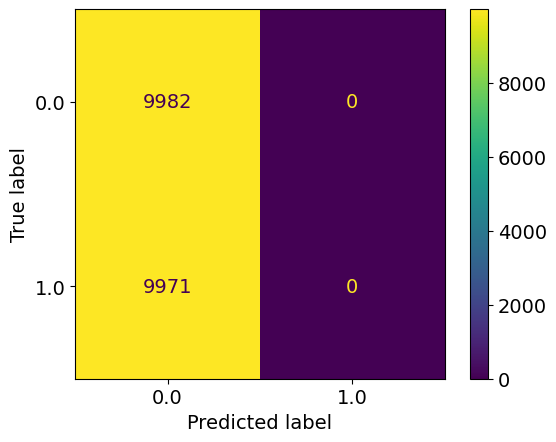

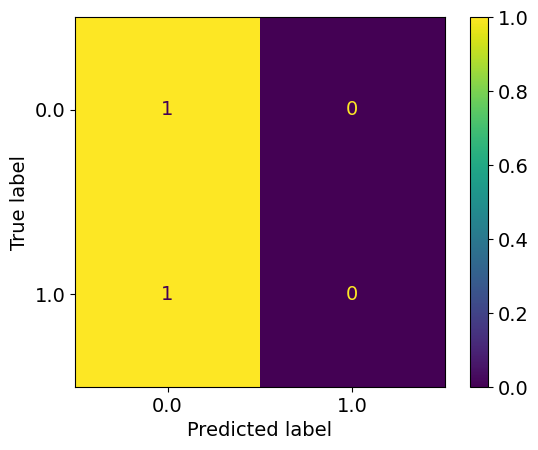

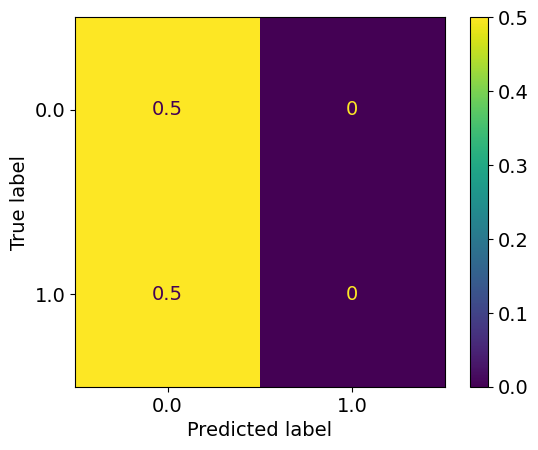

In [20]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
#confusion_matrix(np.hstack(trues), np.where(np.hstack(scores)>0.5, 1, 0))

ConfusionMatrixDisplay.from_predictions(np.hstack(trues), np.where(np.hstack(scores)>threshold90, 1, 0))
plt.show()
ConfusionMatrixDisplay.from_predictions(np.hstack(trues), np.where(np.hstack(scores)>threshold90, 1, 0), normalize="true")
plt.show()
ConfusionMatrixDisplay.from_predictions(np.hstack(trues), np.where(np.hstack(scores)>threshold90, 1, 0), normalize="pred")
plt.show()

## Inference with model of best accuracy checkpoint

### Load best accuracy checkpoint and define model

In [15]:
### REMEMBER: specify the correct input model

out_dir = '20250226_225333_checkpoints' # training 4
#out_dir = '20250227_190925_checkpoints' # training 6
#out_dir = '20250227_235925_checkpoints' # training 7
#out_dir = '20250306_181358_checkpoints' # training 8

device = torch.device('cuda:1')#('cuda' if torch.cuda.is_available() else 'cpu')
model_load = torch.load(out_dir+"/model_checkpoint_bestacc.pth.tar")
print(out_dir)


model = MHA_model(n_seq=150,
        input_dim = 4,
        dim_emb = 16,#32
        n_heads = 16,
        num_enclayers = 6,#4
        dim_feedforward = 64,
        output_dim = 2)


model.to(device)
model.load_state_dict(model_load["state_dict"])
model.eval()

20250226_225333_checkpoints


MHA_model(
  (emb_inp): RecursiveScriptModule(
    original_name=Sequential
    (0): RecursiveScriptModule(original_name=Linear)
    (1): RecursiveScriptModule(original_name=Dropout)
    (2): RecursiveScriptModule(original_name=ELU)
    (3): RecursiveScriptModule(original_name=Linear)
    (4): RecursiveScriptModule(original_name=Dropout)
    (5): RecursiveScriptModule(original_name=ELU)
  )
  (transformer_encoder): RecursiveScriptModule(
    original_name=TransformerEncoder
    (layers): RecursiveScriptModule(
      original_name=ModuleList
      (0): RecursiveScriptModule(
        original_name=TransformerEncoderLayer
        (self_attn): RecursiveScriptModule(
          original_name=MultiheadAttention
          (out_proj): RecursiveScriptModule(original_name=NonDynamicallyQuantizableLinear)
        )
        (linear1): RecursiveScriptModule(original_name=Linear)
        (dropout): RecursiveScriptModule(original_name=Dropout)
        (linear2): RecursiveScriptModule(original_name=Lin

### Confusion matrix and accuracy on test dataset (testloader)

  6%|██████████▎                                                                                                                                                                     | 2/34 [00:02<00:39,  1.24s/it]/opt/exp_soft/vo.gridcl.fr/software/torch/2.0.1/py311-cuda117/lib/python3.11/site-packages/torch/nn/modules/module.py:1501: UserWarning: FALLBACK path has been taken inside: runCudaFusionGroup. This is an indication that codegen Failed for some reason.
To debug try disable codegen fallback path via setting the env variable `export PYTORCH_NVFUSER_DISABLE=fallback`
 (Triggered internally at ../third_party/nvfuser/csrc/manager.cpp:335.)
  return forward_call(*args, **kwargs)
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:05<00:00,  6.22it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an under

accuracy: 0.99789506
threshold : 0.84989595


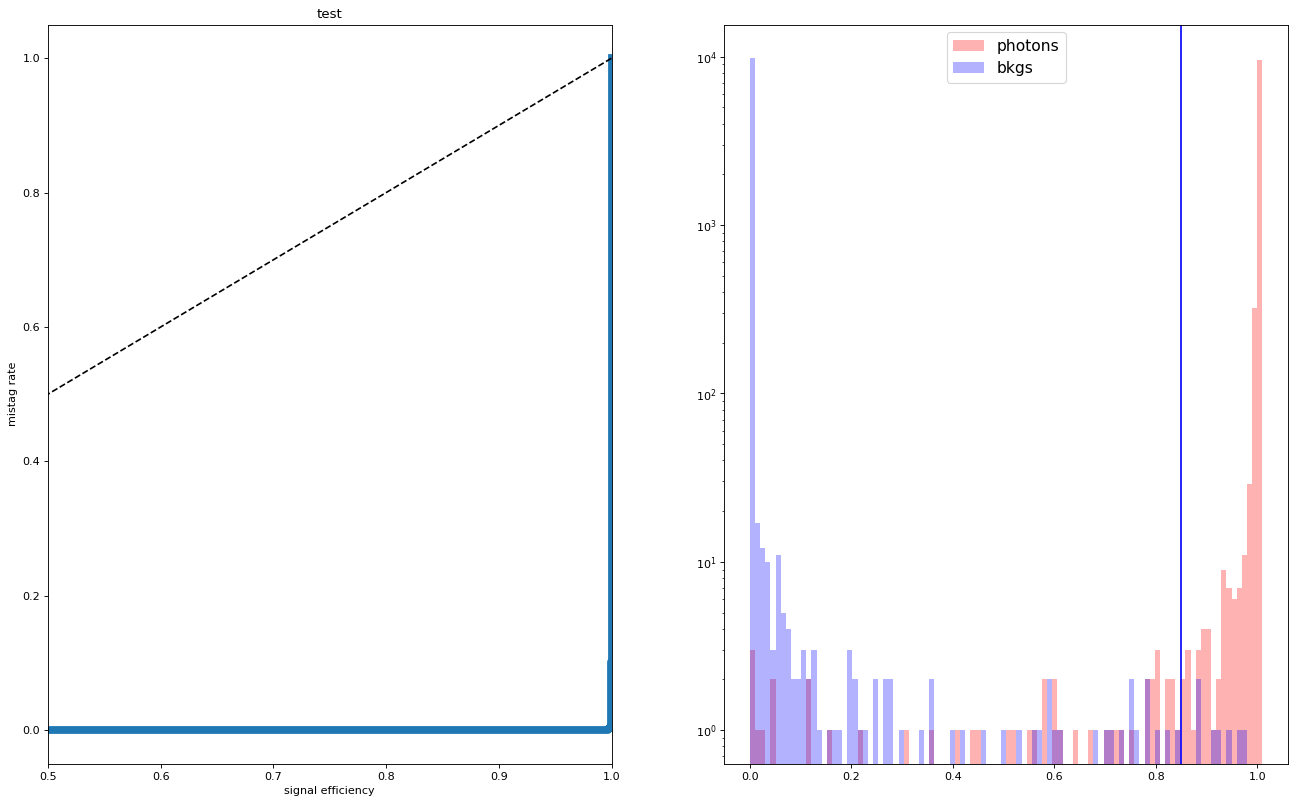

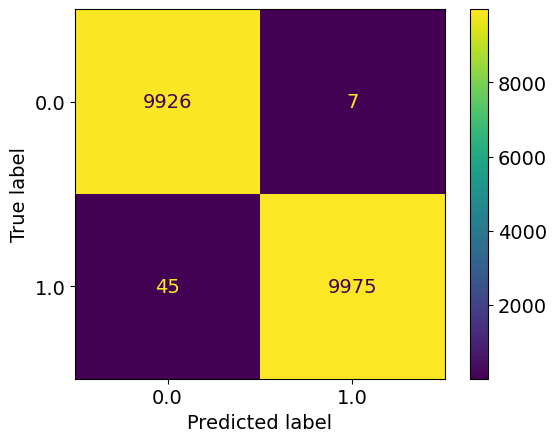

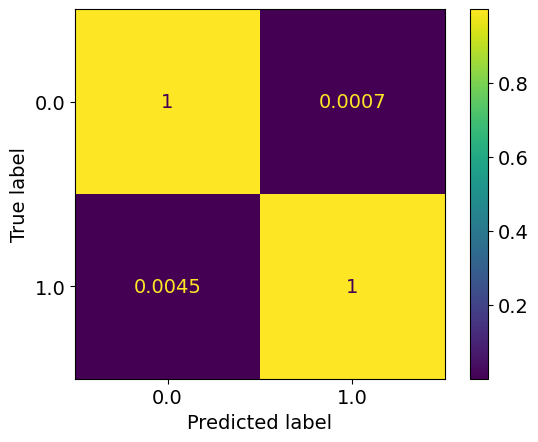

In [16]:
scores = []
trues = []
true_preds, num_preds = 0., 0.
#threshold90 = 0.152
mispredpho = []
mispredbkg = []
for data in tqdm(testloader): ### change to loaderDNN for DNN
        datax, label, masks, info3d = data[0].to(device), data[1].to(device), data[2].to(device), data[3].to(device)
        #label = label.to(torch.long).squeeze()
        result = model(datax, masks, info3d)
        op = torch.exp(result)[:,1].detach().cpu().flatten().numpy()
        ip = label.detach().cpu().numpy().flatten()
        scores.append(op)
        trues.append( ip )

######## use the following lines if you want to store mispredicted event indices for plotting  (REMEMBER to set batch_size=1)

#        opt = np.where(np.hstack(op)>threshold90, 1, 0)
#        if (ip == 1)&(opt == 0):
#            mispredpho.append(datax.detach().cpu().numpy())
#        elif (ip == 0)&(opt == 1):
#            mispredbkg.append(datax.detach().cpu().numpy())

        
        
        ######## use the following lines if you want just the overall scores for accuracy etc (Use this when you want to extract threshold and plot confusion matrices)
        
        label = label.to(torch.long).squeeze()
        pred_labels = torch.argmax(result.cpu(), dim=-1) 
        true_preds += (pred_labels == label.cpu()).sum()
        num_preds += label.shape[0]
        
acc = true_preds / num_preds
print("accuracy:",np.mean(np.array(acc)))

########################### this part extracts the threshold value and plots overall confusion matrices

truesa = np.hstack(trues)
scoresa = np.hstack(scores)
fpr, tpr, thresholds = metrics.roc_curve(truesa, scoresa, pos_label=1)
aucv = metrics.auc(fpr, tpr)

tpr90,fpr90,threshold90_test = 0,0,0
for i,j,k in zip(tpr,fpr,thresholds):
    if i >0.995:
        tpr90 = i
        fpr90 = j
        threshold90_test = k
        break
print("threshold :",threshold90_test)
fig, (ax0,ax1) = plt.subplots(1,2,figsize=(20, 12),dpi=80)
plt.rcParams['font.size'] = '14'
### plot AUC
ax0.plot(tpr,fpr, linewidth=7.0, label= "AUC:"+str(round(aucv,3))+" eff:"+str(round(tpr90,3))+" @ bkg rejection rate:"+str(round(1-fpr90,3)))
ax0.set_xlabel("signal efficiency")
ax0.set_ylabel("mistag rate")
ax0.set_xlim([0.5,1])
ax0.plot([0.,1], [0.,1], 'k--')
ax0.title.set_text("test")
plt.legend()
#plt.show()

## plot signal-bkg distribution
ax1.hist(scoresa[truesa == 1],bins=100, range=[0,1.01], label='photons',linewidth=2.0, color="r" , alpha=0.3)
ax1.hist(scoresa[truesa == 0],bins=100, range=[0,1.01], label='bkgs',linewidth=2.0, color="b", alpha=0.3 )
ax1.axvline(threshold90_test,c="b")
plt.yscale("log")
plt.legend()
plt.show()

#ax.text(0.6,0.6,aucv,)
#plt.yscale("log")
#plt.legend()
#plt.show()



### plot confusion matrices
ConfusionMatrixDisplay.from_predictions(truesa, np.where(scoresa>threshold90_test, 1, 0))
plt.show()
ConfusionMatrixDisplay.from_predictions(truesa, np.where(scoresa>threshold90_test, 1, 0), normalize="true")
plt.show()

### Confusion matrix and accuracy on full dataset (totalloader)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 167/167 [00:11<00:00, 14.54it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


accuracy: 0.9980153
threshold : 0.89756536


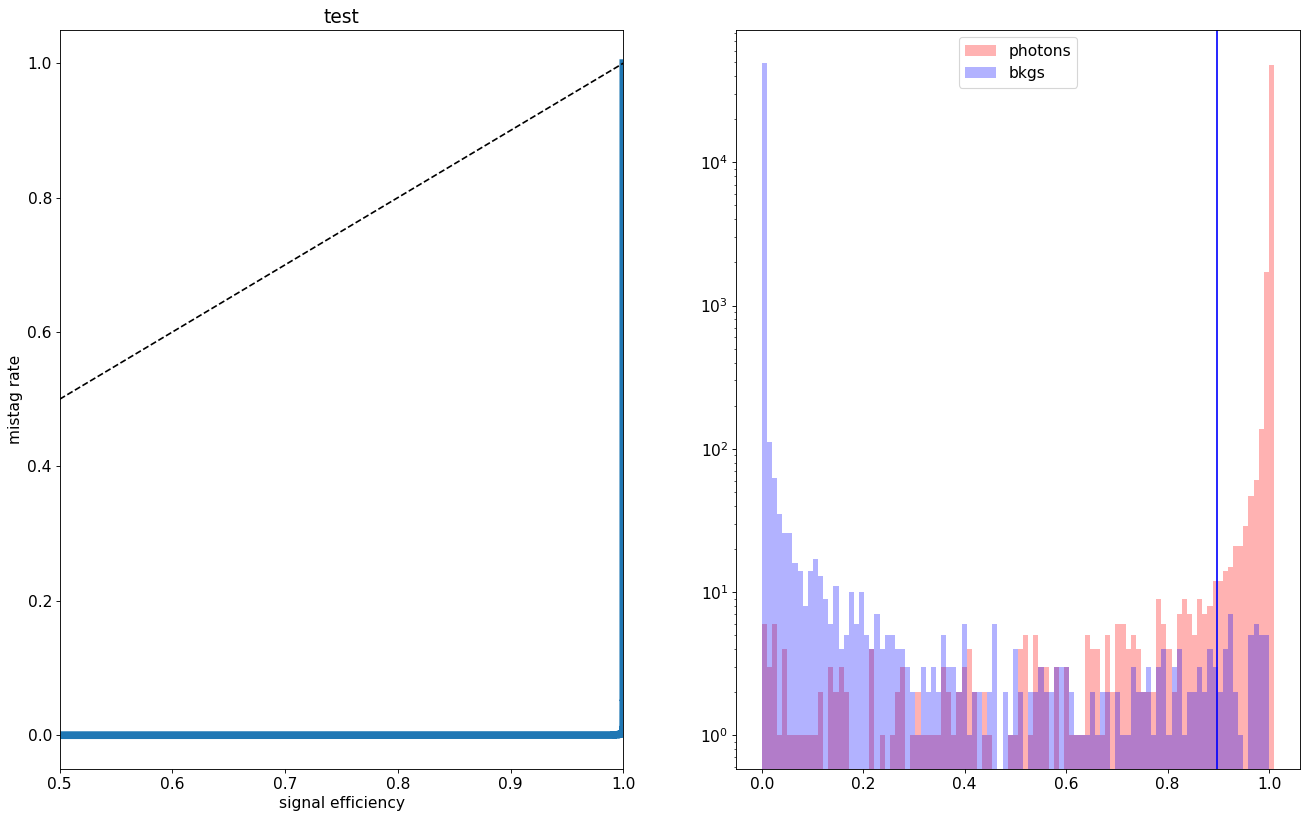

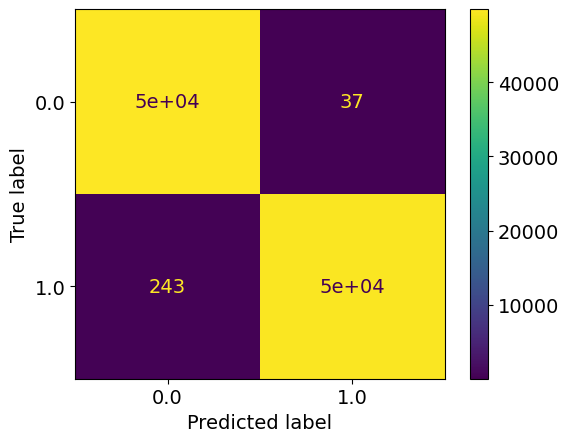

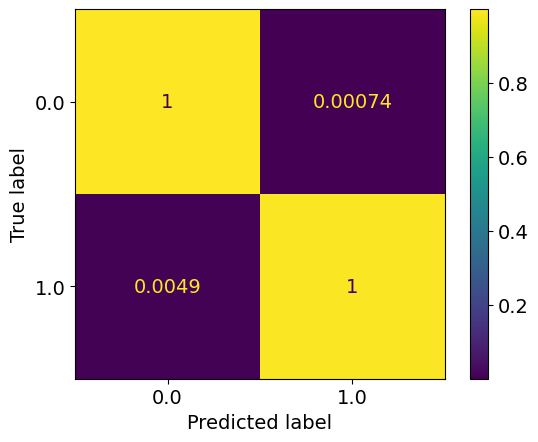

In [17]:
scores = []
trues = []
true_preds, num_preds = 0., 0.
#threshold90 = 0.152
mispredpho = []
mispredbkg = []
for data in tqdm(totalloader): ### change to loaderDNN for DNN
        datax, label, masks, info3d = data[0].to(device), data[1].to(device), data[2].to(device), data[3].to(device)
        #label = label.to(torch.long).squeeze()
        result = model(datax, masks, info3d)
        op = torch.exp(result)[:,1].detach().cpu().flatten().numpy()
        ip = label.detach().cpu().numpy().flatten()
        scores.append(op)
        trues.append( ip )
     
        ######## use the following lines if you want just the overall scores for accuracy etc (Use this when you want to extract threshold and plot confusion matrices)
        
        label = label.to(torch.long).squeeze()
        pred_labels = torch.argmax(result.cpu(), dim=-1) 
        true_preds += (pred_labels == label.cpu()).sum()
        num_preds += label.shape[0]
        
acc = true_preds / num_preds
print("accuracy:",np.mean(np.array(acc)))

########################### this part extracts the threshold value and plots overall confusion matrices

truesa = np.hstack(trues)
scoresa = np.hstack(scores)
fpr, tpr, thresholds = metrics.roc_curve(truesa, scoresa, pos_label=1)
aucv = metrics.auc(fpr, tpr)

tpr90,fpr90,threshold90_tot = 0,0,0
for i,j,k in zip(tpr,fpr,thresholds):
    if i >0.995:
        tpr90 = i
        fpr90 = j
        threshold90_tot = k
        break
print("threshold :",threshold90_tot)
fig, (ax0,ax1) = plt.subplots(1,2,figsize=(20, 12),dpi=80)
plt.rcParams['font.size'] = '14'
### plot AUC
ax0.plot(tpr,fpr, linewidth=7.0, label= "AUC:"+str(round(aucv,3))+" eff:"+str(round(tpr90,3))+" @ bkg rejection rate:"+str(round(1-fpr90,3)))
ax0.set_xlabel("signal efficiency")
ax0.set_ylabel("mistag rate")
ax0.set_xlim([0.5,1])
ax0.plot([0.,1], [0.,1], 'k--')
ax0.title.set_text("test")
plt.legend()
#plt.show()

## plot signal-bkg distribution
ax1.hist(scoresa[truesa == 1],bins=100, range=[0,1.01], label='photons',linewidth=2.0, color="r" , alpha=0.3)
ax1.hist(scoresa[truesa == 0],bins=100, range=[0,1.01], label='bkgs',linewidth=2.0, color="b", alpha=0.3 )
ax1.axvline(threshold90_tot,c="b")
plt.yscale("log")
plt.legend()
plt.show()

#ax.text(0.6,0.6,aucv,)
#plt.yscale("log")
#plt.legend()
#plt.show()



### plot confusion matrices
ConfusionMatrixDisplay.from_predictions(truesa, np.where(scoresa>threshold90_tot, 1, 0))
plt.show()
ConfusionMatrixDisplay.from_predictions(truesa, np.where(scoresa>threshold90_tot, 1, 0), normalize="true")
plt.show()

### Plot mispredicted events

In [18]:
### set batch_size=1
testloader = torch.utils.data.DataLoader(tsdata, batch_size=1,shuffle=True)#, num_workers=2)
totalloader = torch.utils.data.DataLoader(combdataset, batch_size=1,shuffle=True)#, num_workers=2)

#### mispredicted events on test dataset (testloader)

  0%|                                                                                                                                                                                     | 0/19953 [00:00<?, ?it/s]/opt/exp_soft/vo.gridcl.fr/software/torch/2.0.1/py311-cuda117/lib/python3.11/site-packages/torch/nn/modules/module.py:1501: UserWarning: FALLBACK path has been taken inside: runCudaFusionGroup. This is an indication that codegen Failed for some reason.
To debug try disable codegen fallback path via setting the env variable `export PYTORCH_NVFUSER_DISABLE=fallback`
 (Triggered internally at ../third_party/nvfuser/csrc/manager.cpp:335.)
  return forward_call(*args, **kwargs)
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19953/19953 [01:33<00:00, 212.30it/s]


threshold 0.84989595
mispred_pho 45


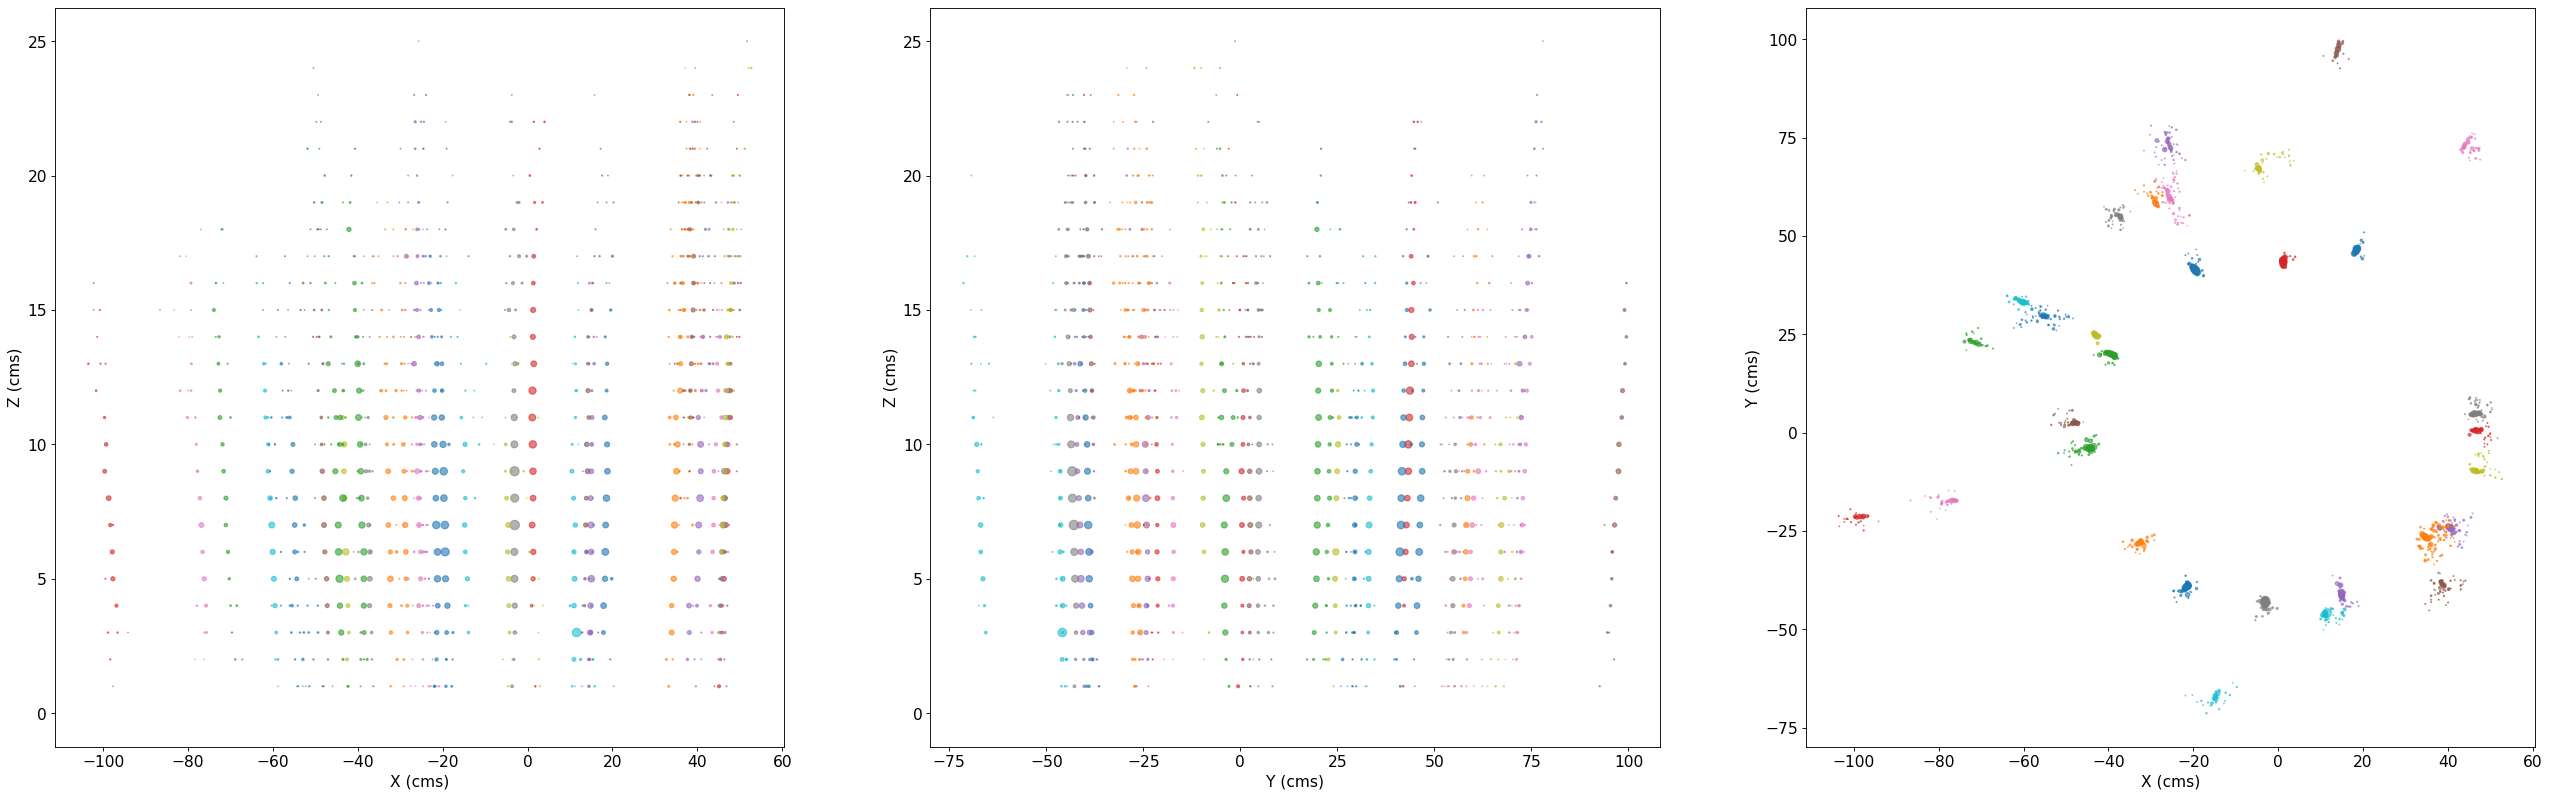

mispred_bkg 7


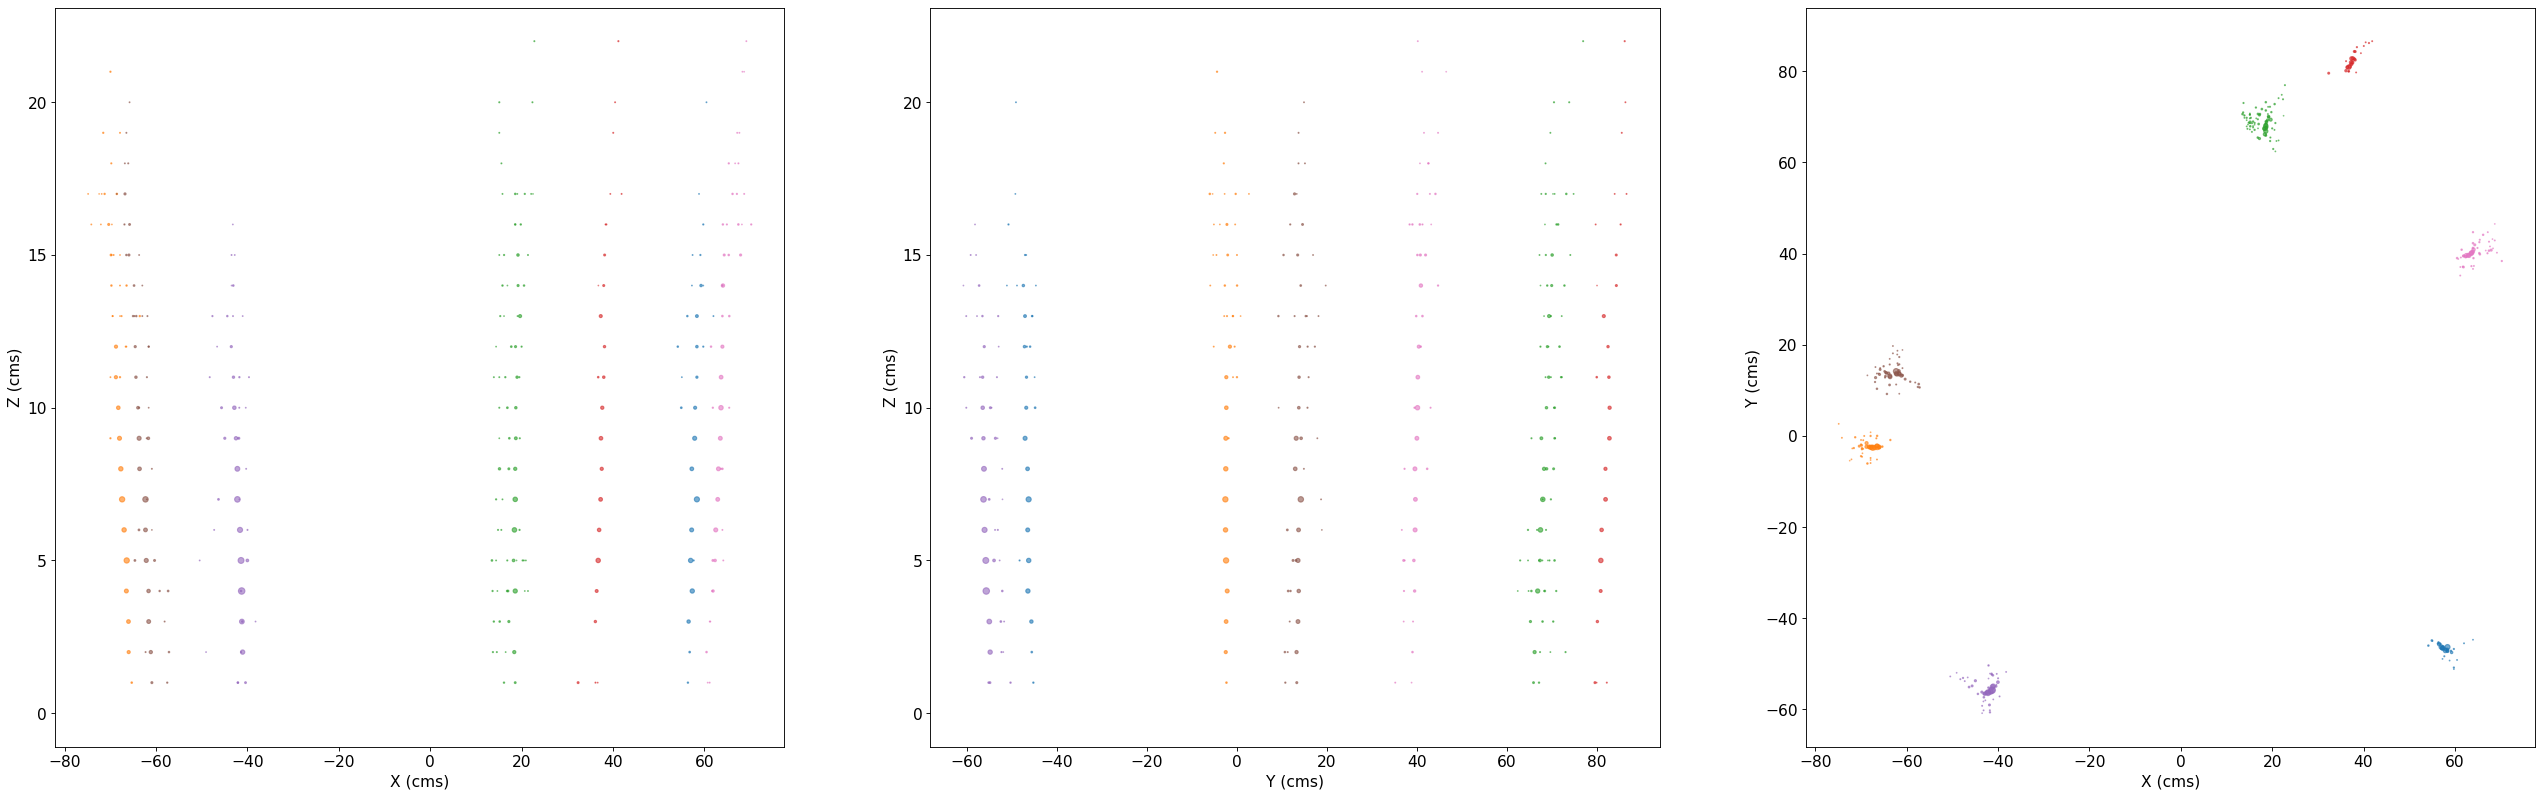

In [19]:
## REMEMBER to specify the threshold (to match the one obtained above)
scores = []
trues = []
true_preds, num_preds = 0., 0.
threshold90 = threshold90_test #0.152
mispredpho = []
mispredbkg = []
for data in tqdm(testloader): ### change to loaderDNN for DNN
        datax, label, masks, info3d = data[0].to(device), data[1].to(device), data[2].to(device), data[3].to(device)
        #label = label.to(torch.long).squeeze()
        result = model(datax, masks, info3d)
        op = torch.exp(result)[:,1].detach().cpu().flatten().numpy()
        ip = label.detach().cpu().numpy().flatten()
        scores.append(op)
        trues.append( ip )

######## use the following lines if you want to store mispredicted event indices for plotting  (REMEMBER to set batch_size=1)

        opt = np.where(np.hstack(op)>threshold90, 1, 0)
        if (ip == 1)&(opt == 0):
            mispredpho.append(datax.detach().cpu().numpy())
        elif (ip == 0)&(opt == 1):
            mispredbkg.append(datax.detach().cpu().numpy())



#Plot mispredicted events:
print("threshold", threshold90)

## mispredicted PHOTONS
fig, (ax0,ax1, ax2) = plt.subplots(1,3,figsize=(40, 12),dpi=80)
print("mispred_pho",len(mispredpho))
cc = 0
for uarray in mispredpho:
    
    uarray = uarray.reshape(uarray.shape[1],uarray.shape[2])
    #uarray = uarray[uarray[:,2]>0]
    ax0.scatter(uarray[:,0],uarray[:,2],s=uarray[:,3]*10,alpha=0.6)
    ax0.set_xlabel('X (cms)')
    ax0.set_ylabel('Z (cms)')
    ax1.scatter(uarray[:,1],uarray[:,2],s=uarray[:,3]*10,alpha=0.6)
    ax1.set_xlabel('Y (cms)')
    ax1.set_ylabel('Z (cms)')

    ax2.scatter(uarray[:,0],uarray[:,1],s=uarray[:,3]*10,alpha=0.6)
    ax2.set_xlabel('X (cms)')
    ax2.set_ylabel('Y (cms)')
    cc += 1
    if cc > 30:
        break    

plt.show()

## mispredicted PIONS
fig, (ax0,ax1, ax2) = plt.subplots(1,3,figsize=(40, 12),dpi=80)
print("mispred_bkg",len(mispredbkg))
cc = 0
for uarray in mispredbkg:
    
    uarray = uarray.reshape(uarray.shape[1],uarray.shape[2])
    #uarray = uarray[uarray[:,2]>0]
    ax0.scatter(uarray[:,0],uarray[:,2],s=uarray[:,3]*10,alpha=0.6)
    ax0.set_xlabel('X (cms)')
    ax0.set_ylabel('Z (cms)')
    ax1.scatter(uarray[:,1],uarray[:,2],s=uarray[:,3]*10,alpha=0.6)
    ax1.set_xlabel('Y (cms)')
    ax1.set_ylabel('Z (cms)')

    ax2.scatter(uarray[:,0],uarray[:,1],s=uarray[:,3]*10,alpha=0.6)
    ax2.set_xlabel('X (cms)')
    ax2.set_ylabel('Y (cms)')
    cc += 1
    if cc > 30:
        break    

plt.show()

Plot Barycenter of mispredicted photons
len: 45
[7.7365007, 7.6756835, 9.655704, 10.791046, 14.192359, 8.265371, 7.890803, 6.9440794, 7.075753, 8.066567, 8.080289, 8.561115, 8.115561, 8.347059, 8.831314, 9.314702, 7.6246414, 8.88132, 11.775137, 5.348284, 7.9790406, 10.560233, 9.440712, 7.5042505, 7.0392647, 15.210203, 8.951667, 9.00635, 6.5491595, 7.4551873, 7.3067684, 8.442131, 9.011386, 8.488918, 7.475987, 8.950702, 8.14391, 8.580036, 7.2401257, 7.9761705, 7.227501, 9.846311, 6.284522, 7.5826683, 8.072128]


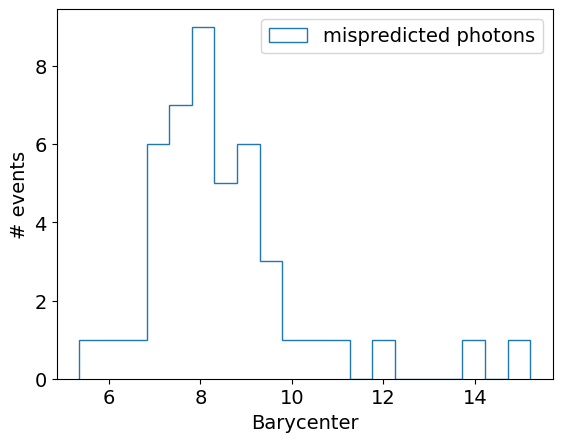

Plot Barycenter of mispredicted pions
len: 7
[7.7365007, 7.6756835, 9.655704, 10.791046, 14.192359, 8.265371, 7.890803, 6.9440794, 7.075753, 8.066567, 8.080289, 8.561115, 8.115561, 8.347059, 8.831314, 9.314702, 7.6246414, 8.88132, 11.775137, 5.348284, 7.9790406, 10.560233, 9.440712, 7.5042505, 7.0392647, 15.210203, 8.951667, 9.00635, 6.5491595, 7.4551873, 7.3067684, 8.442131, 9.011386, 8.488918, 7.475987, 8.950702, 8.14391, 8.580036, 7.2401257, 7.9761705, 7.227501, 9.846311, 6.284522, 7.5826683, 8.072128]


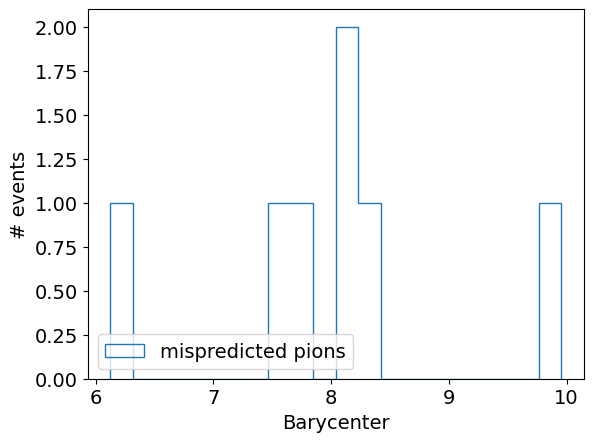

In [31]:
# mispredicted PHOTONS
print("Plot Barycenter of mispredicted photons")

fig, ax = plt.subplots(1,1)#,figsize=(40, 12),dpi=80)

barycenter_mis_pho = []
for uarray in mispredpho:
    
    uarray = uarray.reshape(uarray.shape[1],uarray.shape[2])

    barycenter_z = np.average(uarray[:,2], weights=uarray[:,3])
    barycenter_mis_pho.append(barycenter_z)
    #print(barycenter_z)

print("len:",len(barycenter_mis_pho))
print(barycenter_mis_pho)

ax.hist(barycenter_mis_pho, bins=20, histtype='step',linewidth=1,label='mispredicted photons')
ax.legend()
ax.set_xlabel('Barycenter')
ax.set_ylabel('# events')
 
plt.show()


### -------------
# mispredicted PIONS
print("Plot Barycenter of mispredicted pions")

fig, ax = plt.subplots(1,1)#,figsize=(40, 12),dpi=80)

barycenter_mis_bkg = []
for uarray in mispredbkg:
    
    uarray = uarray.reshape(uarray.shape[1],uarray.shape[2])

    barycenter_z = np.average(uarray[:,2], weights=uarray[:,3])
    barycenter_mis_bkg.append(barycenter_z)
    #print(barycenter_z)

print("len:",len(barycenter_mis_bkg))
print(barycenter_mis_pho)

ax.hist(barycenter_mis_bkg, bins=20, histtype='step',linewidth=1,label='mispredicted pions')
ax.legend()
ax.set_xlabel('Barycenter')
ax.set_ylabel('# events')
 

plt.show()


#### mispredicted events on full dataset (totalloader)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 99761/99761 [08:37<00:00, 192.85it/s]


threshold 0.89756536
mispred_pho 243


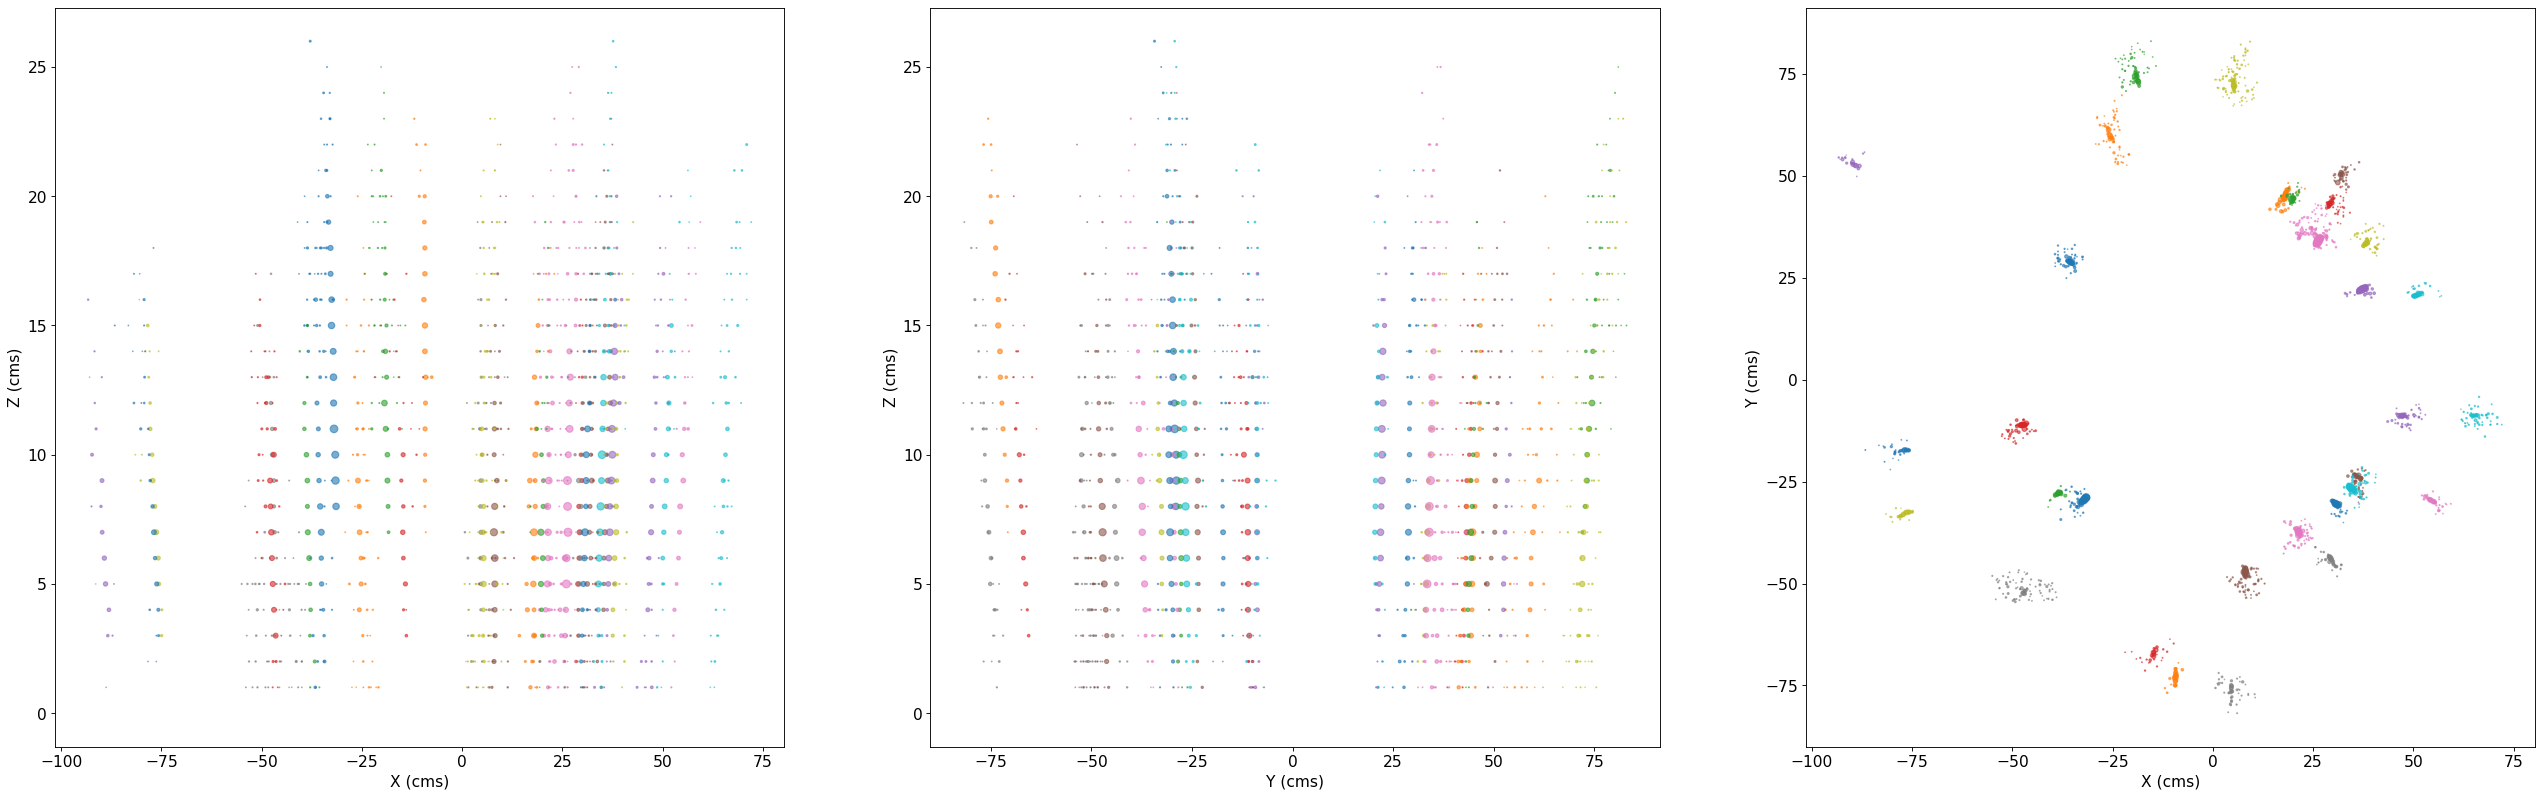

mispred_bkg 37


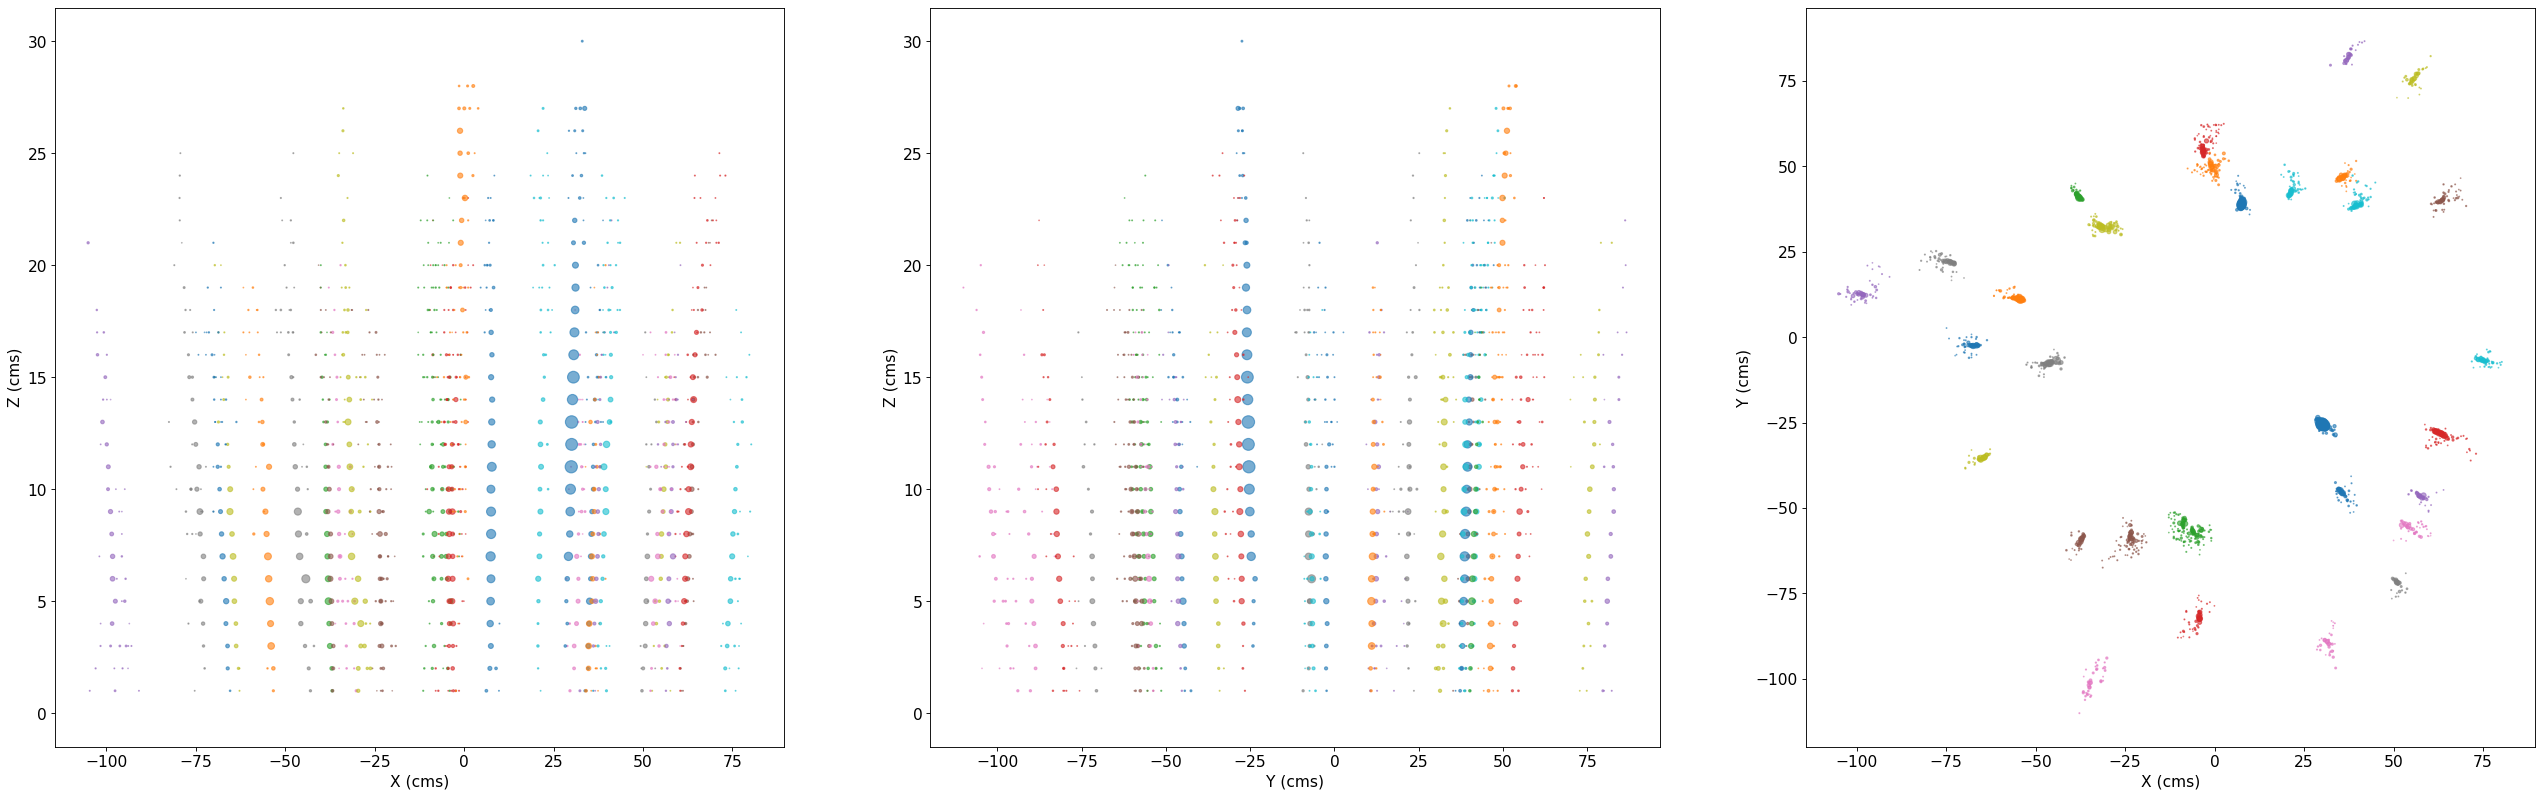

In [33]:
## REMEMBER to specify the threshold (to match the one obtained above)
scores = []
trues = []
true_preds, num_preds = 0., 0.
threshold90 = threshold90_tot #0.152
mispredpho = []
mispredbkg = []
for data in tqdm(totalloader): ### change to loaderDNN for DNN
        datax, label, masks, info3d = data[0].to(device), data[1].to(device), data[2].to(device), data[3].to(device)
        #label = label.to(torch.long).squeeze()
        result = model(datax, masks, info3d)
        op = torch.exp(result)[:,1].detach().cpu().flatten().numpy()
        ip = label.detach().cpu().numpy().flatten()
        scores.append(op)
        trues.append( ip )

######## use the following lines if you want to store mispredicted event indices for plotting  (REMEMBER to set batch_size=1)

        opt = np.where(np.hstack(op)>threshold90, 1, 0)
        if (ip == 1)&(opt == 0):
            mispredpho.append(datax.detach().cpu().numpy())
        elif (ip == 0)&(opt == 1):
            mispredbkg.append(datax.detach().cpu().numpy())



#Plot mispredicted events:
print("threshold", threshold90)

## mispredicted PHOTONS
fig, (ax0,ax1, ax2) = plt.subplots(1,3,figsize=(40, 12),dpi=80)
print("mispred_pho",len(mispredpho))
cc = 0
for uarray in mispredpho:
    
    uarray = uarray.reshape(uarray.shape[1],uarray.shape[2])
    #uarray = uarray[uarray[:,2]>0]
    ax0.scatter(uarray[:,0],uarray[:,2],s=uarray[:,3]*10,alpha=0.6)
    ax0.set_xlabel('X (cms)')
    ax0.set_ylabel('Z (cms)')
    ax1.scatter(uarray[:,1],uarray[:,2],s=uarray[:,3]*10,alpha=0.6)
    ax1.set_xlabel('Y (cms)')
    ax1.set_ylabel('Z (cms)')

    ax2.scatter(uarray[:,0],uarray[:,1],s=uarray[:,3]*10,alpha=0.6)
    ax2.set_xlabel('X (cms)')
    ax2.set_ylabel('Y (cms)')
    cc += 1
    if cc > 30:
        break    

plt.show()

## mispredicted PIONS
fig, (ax0,ax1, ax2) = plt.subplots(1,3,figsize=(40, 12),dpi=80)
print("mispred_bkg",len(mispredbkg))
cc = 0
for uarray in mispredbkg:
    
    uarray = uarray.reshape(uarray.shape[1],uarray.shape[2])
    #uarray = uarray[uarray[:,2]>0]
    ax0.scatter(uarray[:,0],uarray[:,2],s=uarray[:,3]*10,alpha=0.6)
    ax0.set_xlabel('X (cms)')
    ax0.set_ylabel('Z (cms)')
    ax1.scatter(uarray[:,1],uarray[:,2],s=uarray[:,3]*10,alpha=0.6)
    ax1.set_xlabel('Y (cms)')
    ax1.set_ylabel('Z (cms)')

    ax2.scatter(uarray[:,0],uarray[:,1],s=uarray[:,3]*10,alpha=0.6)
    ax2.set_xlabel('X (cms)')
    ax2.set_ylabel('Y (cms)')
    cc += 1
    if cc > 30:
        break    

plt.show()

Plot Barycenter of mispredicted photons
len: 243
[13.642353, 14.81793, 7.722816, 7.905439, 8.443501, 10.408845, 8.696791, 7.077218, 8.427083, 9.625117, 7.890803, 7.6246414, 12.82772, 8.066567, 10.039024, 9.132606, 8.881081, 8.442131, 7.8216834, 9.895441, 9.002269, 7.435711, 7.4609647, 7.755746, 6.997405, 7.3460007, 8.515311, 8.115935, 8.18169, 10.723167, 7.939785, 7.2401257, 7.5357804, 8.305317, 11.783158, 8.407922, 12.043221, 9.00635, 13.598361, 8.0690565, 8.951667, 7.475987, 23.09353, 11.433775, 8.026922, 9.025097, 10.262636, 7.565188, 8.49446, 9.011386, 9.043145, 9.586171, 7.2823124, 9.440712, 8.1419935, 7.5633698, 8.163768, 8.082437, 8.595469, 7.6756835, 17.680037, 6.284522, 7.7365007, 7.2399282, 8.14391, 6.737071, 8.072128, 9.655704, 8.010266, 9.60035, 9.874723, 8.433183, 10.531245, 23.099178, 9.119078, 7.332547, 13.83166, 7.559685, 9.653444, 7.4932227, 7.058178, 14.192359, 9.026817, 10.791046, 9.768231, 7.7126684, 22.462023, 8.386793, 10.381339, 7.865737, 10.706019, 8.8328285, 8.

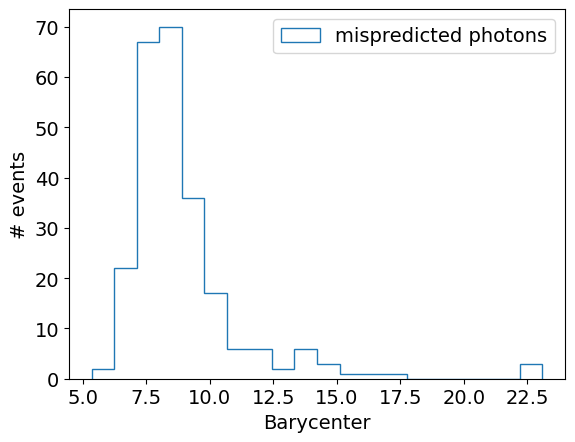

Plot Barycenter of mispredicted pions
len: 37
[13.642353, 14.81793, 7.722816, 7.905439, 8.443501, 10.408845, 8.696791, 7.077218, 8.427083, 9.625117, 7.890803, 7.6246414, 12.82772, 8.066567, 10.039024, 9.132606, 8.881081, 8.442131, 7.8216834, 9.895441, 9.002269, 7.435711, 7.4609647, 7.755746, 6.997405, 7.3460007, 8.515311, 8.115935, 8.18169, 10.723167, 7.939785, 7.2401257, 7.5357804, 8.305317, 11.783158, 8.407922, 12.043221, 9.00635, 13.598361, 8.0690565, 8.951667, 7.475987, 23.09353, 11.433775, 8.026922, 9.025097, 10.262636, 7.565188, 8.49446, 9.011386, 9.043145, 9.586171, 7.2823124, 9.440712, 8.1419935, 7.5633698, 8.163768, 8.082437, 8.595469, 7.6756835, 17.680037, 6.284522, 7.7365007, 7.2399282, 8.14391, 6.737071, 8.072128, 9.655704, 8.010266, 9.60035, 9.874723, 8.433183, 10.531245, 23.099178, 9.119078, 7.332547, 13.83166, 7.559685, 9.653444, 7.4932227, 7.058178, 14.192359, 9.026817, 10.791046, 9.768231, 7.7126684, 22.462023, 8.386793, 10.381339, 7.865737, 10.706019, 8.8328285, 8.709

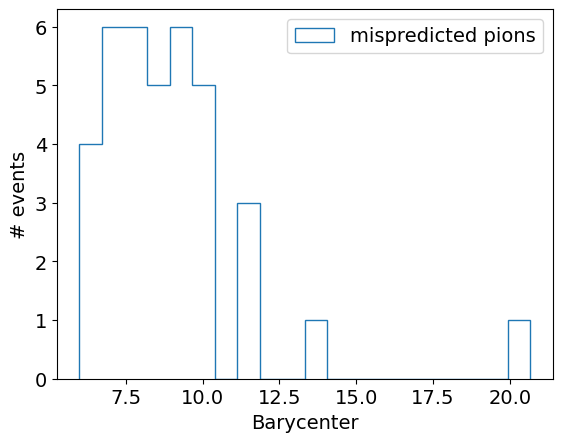

In [35]:
# mispredicted PHOTONS
print("Plot Barycenter of mispredicted photons")

fig, ax = plt.subplots(1,1)#,figsize=(40, 12),dpi=80)

barycenter_mis_pho = []
for uarray in mispredpho:
    
    uarray = uarray.reshape(uarray.shape[1],uarray.shape[2])

    barycenter_z = np.average(uarray[:,2], weights=uarray[:,3])
    barycenter_mis_pho.append(barycenter_z)
    #print(barycenter_z)

print("len:",len(barycenter_mis_pho))
print(barycenter_mis_pho)

ax.hist(barycenter_mis_pho, bins=20, histtype='step',linewidth=1,label='mispredicted photons')
ax.legend()
ax.set_xlabel('Barycenter')
ax.set_ylabel('# events')
 
plt.show()


### -------------
# mispredicted PIONS
print("Plot Barycenter of mispredicted pions")

fig, ax = plt.subplots(1,1)#,figsize=(40, 12),dpi=80)

barycenter_mis_bkg = []
for uarray in mispredbkg:
    
    uarray = uarray.reshape(uarray.shape[1],uarray.shape[2])

    barycenter_z = np.average(uarray[:,2], weights=uarray[:,3])
    barycenter_mis_bkg.append(barycenter_z)
    #print(barycenter_z)

print("len:",len(barycenter_mis_bkg))
print(barycenter_mis_pho)

ax.hist(barycenter_mis_bkg, bins=20, histtype='step',linewidth=1,label='mispredicted pions')
ax.legend()
ax.set_xlabel('Barycenter')
ax.set_ylabel('# events')
 

plt.show()